# Unlock Phase 1

In [ ]:
%reset -f
!pip install faiss-gpu
!pip install celluloid
import faiss
import numpy as np
from scipy.stats import norm
import time
import torch
from google.colab import files
import random
from sklearn.neighbors import NearestNeighbors
device = 'cuda'
res = faiss.StandardGpuResources()
select = 0
MonteCarlo = 2
Residence = torch.tensor(np.loadtxt('lucknow_agent_location.dat'),dtype=torch.double,device='cuda')
Age = torch.tensor(np.loadtxt('lucknow_Age.dat'),dtype=torch.long,device='cuda')
H_Size = torch.tensor(np.loadtxt('lucknow_Age_House.dat'),dtype=torch.long,device='cuda')
H_Size[H_Size==0] = 1
H_Number = torch.tensor(np.loadtxt('lucknow_House_number.dat'),dtype=torch.long,device='cuda')
H_location = torch.tensor(np.loadtxt('lucknow_household_location.dat'),dtype=torch.long,device='cuda')
# Total Population
Population = 64560
# Number of Children (0), Adults (1), Seniors (2) and Infections (3)
Demography = torch.tensor([round(0.2516*Population),
                           round(0.6835*Population),
                           0,
                           0,
                           8],dtype=torch.long,device='cuda')
Demography[2] = Population-torch.sum(Demography[:2]) 
Demography[3] = 20
# Layout Size: XMinimum (0), XMaximum (1), YMinimum (2), YMaximum (3), Grid Resolution (4)
Layout = torch.tensor([0,5000,0,2000,1000],dtype=torch.double,device='cuda')
# Minimum (0), Maximum (1), Inner (2), Innermost (3) Allowed Speeds
VelocityParameters = torch.tensor([-500,500,200,10,1],dtype=torch.long,device='cuda')
# Collision Radius (0), Infection Radius (1), OuterCircle (2), InnerCircle (3), Reached Goal (4)
Radii = torch.tensor([5,2,570,120,5],dtype=torch.long,device='cuda') # Infection Radius(20) > Collision Radius(5/50) --> no social distancing
# Total time (days), Resolution(minutes)
Time = torch.tensor([31,15],dtype=torch.long, device='cuda') 
# TimeSteps in a day (1 step = 15mins) and total
TimeStepsDay = torch.div(24*60,Time[1].item())
# Total time steps in 31 days
TimeStepsTotal = TimeStepsDay*Time[0].long()
# Re-assign x and y initial positions
# Assign positions within unit radius
adjustment = 0.5
Residence = H_location[H_Number] + torch.DoubleTensor(Population,2).uniform_(-adjustment,adjustment).cuda()
# Check if the newly assigned x co-ordinate is within the boundary
Residence[Residence[:,0]>Layout[1],0] = (torch.DoubleTensor(Population).uniform_(Layout[1]-adjustment,Layout[1]).cuda())[Residence[:,0]>Layout[1]]
Residence[Residence[:,0]<Layout[0],0] = (torch.DoubleTensor(Population).uniform_(Layout[0],Layout[0]+adjustment).cuda())[Residence[:,0]<Layout[0]]
# Check if the newly assigned y co-ordinate is within the boundary
Residence[Residence[:,1]>Layout[3],1] = (torch.DoubleTensor(Population).uniform_(Layout[3]-adjustment,Layout[3]).cuda())[Residence[:,1]>Layout[3]]
Residence[Residence[:,1]<Layout[2],1] = (torch.DoubleTensor(Population).uniform_(Layout[2],Layout[2]+adjustment).cuda())[Residence[:,1]<Layout[2]]
Activities = np.zeros((20,96),dtype=np.float32)
# Children
# Errands 
Activities[0,24:36]=0.005*norm.pdf(np.arange(6,9,step=0.25), 7.5, 1) # 6-9
Activities[0,36:56]=0.01*norm.pdf(np.arange(9,14,step=0.25), 11.5, 1) # 9-14
Activities[0,56:72]=0.025*norm.pdf(np.arange(14,18,step=0.25), 17, 1) # 14-21
# Adults
# Errands 
Activities[8,24:36]=0.025*norm.pdf(np.arange(6,9,step=0.25), 7.5, 1) # 6-9
Activities[8,36:56]=0.05*norm.pdf(np.arange(9,14,step=0.25), 11.5, 1) # 9-14
Activities[8,56:72]=0.075*norm.pdf(np.arange(14,18,step=0.25), 17, 1) # 14-21
# Nomadic
Activities[12,24:48] = 0.1*norm.pdf(np.arange(6,12,step=0.25), 10, 1) # 6-12
Activities[12,48:72] = 0.25*norm.pdf(np.arange(12,18,step=0.25), 16, 1) # 12-21
# Nomads go home (18) # Weekday
Activities[18,0:24] = np.ones(24)
Activities[18,84:96] = np.ones(12)
# Nomads go home (19) # Weekend
Activities[19,0:96] = np.ones(96)
# Children
# Market
Activities[1,24:48]=0.01*norm.pdf(np.arange(6,12,step=0.25), 10, 1) # 6-12
Activities[1,48:72]=0.02*norm.pdf(np.arange(12,18,step=0.25), 16, 1) # 12-21
# Adults
# Market
Activities[9,24:48]=0.015*norm.pdf(np.arange(6,12,step=0.25), 10, 1) # 6-12
Activities[9,48:72]=0.03*norm.pdf(np.arange(12,18,step=0.25), 17, 1) # 12-21
# Office 
Activities[10,24:48]= 2*norm.pdf(np.arange(6,12,step=0.25), 9, 1) # 6-12
Activities[11,48:72] = 2*norm.pdf(np.arange(12,18,step=0.25), 16, 1) # 12-21
# Weekday Activities
Limits = torch.tensor([0,0,0,0,0,0,1,100,1,100,0,0,
                       0,0,0,0,0,0,0,0,0,0,0,0,
                       0,0,0,0,0,100,2,100,2,100,0,0,
                       5,100,0,0,1,100,1,100,1,100,0,0,
                       8,100,0,0,2,100,1,100,1,100,1,100,
                       0,0,0,0,0,0,0,0,1,100,1,100],dtype=torch.long,device='cuda')
# Weekend Activities                    
Limits_Weekend = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0],dtype=torch.long,device='cuda')
Location_one = torch.tensor([12,13,14,15,16,17],dtype=torch.long,device='cuda') # Location of i
Location_two = torch.tensor([[12,0,0,15,16,0],
                             [0,0,0,0,0,0],
                             [0,0,14,15,16,0],
                             [12,0,14,15,16,0],
                             [12,0,14,15,16,17],
                             [0,0,0,0,16,17]],dtype=torch.long,device='cuda') # Corresponding locations of j   
def goal_assign(x,y,minbias,maxbias,xhalfmark,yhalfmark):
  '''
  Generate Random Goals
  '''
  # ordinate
  l = torch.zeros((Population),dtype=torch.double,device='cuda')
  # abscissa
  m = torch.zeros((Population),dtype=torch.double,device='cuda')
  temp = x -  torch.FloatTensor(Population).uniform_(minbias,maxbias).cuda()
  l[x>xhalfmark] = temp[x>xhalfmark] 
  temp = y -  torch.FloatTensor(Population).uniform_(minbias,maxbias).cuda()
  m[y>yhalfmark] = temp[y>yhalfmark] 
  temp = x +  torch.FloatTensor(Population).uniform_(minbias,maxbias).cuda()
  l[x<xhalfmark] = temp[x<xhalfmark] 
  temp = y +  torch.FloatTensor(Population).uniform_(minbias,maxbias).cuda()
  m[y<yhalfmark] = temp[y<yhalfmark] 
  return l,m   

def generateMatrix(agents,matrixone,limits,Population, H_Number, index,con_one, con_two,Time_Daily,matrixthree,distance,radius):
  '''
  Generate a conditional contact matrix
  '''
  # Store end result
  matrixtwo = torch.zeros((2,Population,20),dtype=torch.double,device='cuda')
  count=0
  for i in range(6):
    vec_con1 = torch.zeros((Population),device='cuda',dtype=torch.bool)
    vec_con1 += (agents==con_one[i])
    Time_Daily[vec_con1==True,i]+=1
    for j in range(6):
      temp = torch.zeros((Population,20),device='cuda',dtype=torch.int32)
      vec_con2 = torch.zeros((Population,20),device='cuda',dtype=torch.bool)      
      if (con_two[i][j]!=0):
        if (count==0):          
          vec_con2 = torch.logical_and(H_Number[index]==H_Number[:,None],(agents[index]==con_two[i][j]))
        else:
          vec_con2 = (agents[index]==con_two[i][j])
        temp = vec_con1[:,None]*vec_con2
        matrixone[:,count] += torch.sum(temp,1)
        #matrixone[:,count] += torch.sum(torch.logical_and(temp,distance<radius),1)
        if (count!=0):
          matrixone[matrixone[:,count]>limits[:,count],count] = limits[matrixone[:,count]>limits[:,count],count]
        #tempone = temp*(1-(torch.cumsum(torch.logical_and(temp,distance<radius),axis=1)>matrixone[:,count][:,None]).long())
        tempone = temp*(1-(torch.cumsum(temp,axis=1)>matrixone[:,count][:,None]).long())
        matrixtwo[0] += tempone
        matrixtwo[1] = temp
        if (torch.where(vec_con1==True)[0].size(0)!=0):
          matrixthree[i,j] += torch.where(tempone==1)[0].size(0)/torch.where(vec_con1==True)[0].size(0)
      count+=1
  return matrixtwo[0],matrixtwo[1], matrixone, matrixthree, Time_Daily

def nearest_destination(Population,centroids,Residence): 
  '''
  Find the nearest destination: Office/School/Market
  '''
  distance = torch.zeros((Population,len(centroids)),device='cuda',dtype=torch.double)
  for i in range(len(centroids)):
    # Check the distance from the centroid of the zone to each household location
    distance[:,i] = torch.linalg.norm(Residence-Centroids[i],axis=1)
  return torch.argmin(distance,axis=1)

# Schools
# Co-ordinates of different schools
School=torch.tensor([[1500,2000,200,500],
                     [2000,2500,1000,1500],
                     [600,1000,1100,1500],
                     [3900,4500,500,700]],dtype=torch.long,device='cuda')
# Generate Destinations in different school zones
School_Positions = torch.zeros((Population,8),dtype=torch.double,device='cuda')
# x-co-ordinate
School_Positions[:,0] = torch.DoubleTensor(Population).uniform_(School[0,0],School[0,1])
School_Positions[:,2] = torch.DoubleTensor(Population).uniform_(School[1,0],School[1,1])
School_Positions[:,4] = torch.DoubleTensor(Population).uniform_(School[2,0],School[2,1])
School_Positions[:,6] = torch.DoubleTensor(Population).uniform_(School[3,0],School[3,1])
# y-co-ordinate
School_Positions[:,1] = torch.DoubleTensor(Population).uniform_(School[0,2],School[0,3])
School_Positions[:,3] = torch.DoubleTensor(Population).uniform_(School[1,2],School[1,3])
School_Positions[:,5] = torch.DoubleTensor(Population).uniform_(School[2,2],School[2,3])
School_Positions[:,7] = torch.DoubleTensor(Population).uniform_(School[3,2],School[3,3])

# Offices
# Co-ordinates of different offices
Office = torch.tensor([[0,500,500,1000],
                      [4000,4500,1000,1500],
                      [2000,3000,500,1000]],dtype=torch.long,device='cuda')
# Generate destinations in office zones
Office_Positions = torch.zeros((Population,6),dtype=torch.double,device='cuda')
# x co-ordinate
Office_Positions[:,0] = torch.DoubleTensor(Population).uniform_(Office[0,0],Office[0,1])
Office_Positions[:,2] = torch.DoubleTensor(Population).uniform_(Office[1,0],Office[1,1])
Office_Positions[:,4] = torch.DoubleTensor(Population).uniform_(Office[2,0],Office[2,1])
# y co-ordinate
Office_Positions[:,1] = torch.DoubleTensor(Population).uniform_(Office[0,2],Office[0,3])
Office_Positions[:,3] = torch.DoubleTensor(Population).uniform_(Office[1,2],Office[1,3])
Office_Positions[:,5] = torch.DoubleTensor(Population).uniform_(Office[2,2],Office[2,3])

# Markets
# Co-ordinates of different markets
Market = torch.tensor([[3000,3500,1500,2000],
                       [4600,5000,700,900],
                       [900,1500,600,1000],
                       [0,400,1000,1300],
                       [1000,1500,1500,2000]],dtype=torch.long,device='cuda')
# Generate destinations in market zones
Market_Positions = torch.zeros((Population,10),dtype=torch.double,device='cuda')
# x co-ordinate
Market_Positions[:,0] = torch.DoubleTensor(Population).uniform_(Market[0,0],Market[0,1])
Market_Positions[:,2] = torch.DoubleTensor(Population).uniform_(Market[1,0],Market[1,1])
Market_Positions[:,4] = torch.DoubleTensor(Population).uniform_(Market[2,0],Market[2,1])
Market_Positions[:,6] = torch.DoubleTensor(Population).uniform_(Market[3,0],Market[3,1])
Market_Positions[:,8] = torch.DoubleTensor(Population).uniform_(Market[4,0],Market[4,1])
# y co-ordinate
Market_Positions[:,1] = torch.DoubleTensor(Population).uniform_(Market[0,2],Market[0,3])
Market_Positions[:,3] = torch.DoubleTensor(Population).uniform_(Market[1,2],Market[1,3])
Market_Positions[:,5] = torch.DoubleTensor(Population).uniform_(Market[2,2],Market[2,3])
Market_Positions[:,7] = torch.DoubleTensor(Population).uniform_(Market[3,2],Market[3,3])
Market_Positions[:,9] = torch.DoubleTensor(Population).uniform_(Market[4,2],Market[4,3])

# Centroids of each zone
Centroids = torch.zeros((12,2),dtype=torch.double,device='cuda')
# Centroids of school zones
Centroids[:4,0] = School[:,0] + 0.5*School[:,1]
Centroids[:4,1] = School[:,2] + 0.5*School[:,3]
# Centroids of office zones
Centroids[4:7,0] = Office[:,0] + 0.5*Office[:,1]
Centroids[4:7,1] = Office[:,2] + 0.5*Office[:,3]
# Centroids of market zones
Centroids[7:12,0] = Market[:,0] + 0.5*Market[:,1]
Centroids[7:12,1] = Market[:,2] + 0.5*Market[:,3]

# Find nearest destination
Nearest = torch.zeros((Population,3),device='cuda',dtype=torch.long)
# Nearest school
Nearest[:,0] = nearest_destination(Population,Centroids[:4],Residence)
# Nearest office
Nearest[:,1] = nearest_destination(Population,Centroids[4:7],Residence)
# Nearest market
Nearest[:,2] = nearest_destination(Population,Centroids[7:12],Residence)
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Disease Transmission Parameters
# -------------------------------------

# States: SIT/SIN/AIT/AIN/SUT/SUN
States = torch.tensor(([0,0,0,0,0,1,2,3],
                       [0,0,0,1,0,0,0,0],
                       [6,7,6,7,0,0,0,0],
                       [9,9,9,9,0,0,0,0],
                       [0,0,0,0,0,0,0,0],
                       [0,1,2,3,4,5,6,7]),dtype=torch.int,device='cuda')
# Disease Transition Probabilities
Transition = torch.zeros((3,6,8),dtype=torch.double,device='cuda')
undercount = 0
# Children 
Transition[0] = torch.transpose(torch.tensor(([0,0,0.12495,0.00005,0,0.875],
                                              [0,0,0.09994,0.00006,undercount,0.9-undercount],
                                              [0,0.00998,0.19,0.00002,0,0.8],
                                              [0,0.02996,0.12,0.00004,undercount,0.85-undercount],
                                              [0.2537,0,0,0,0,0.7463],
                                              [0.2537,0,0,0,0,0.7463],
                                              [0.2537,0,0,0,0,0.7463],
                                              [0.2537,0,0,0,0,0.7463]),dtype=torch.double,device='cuda'),0,1) 
# Adults
Transition[1] = torch.transpose(torch.tensor(([0,0,0.124,0.001,0,0.875],
                                              [0,0,0.06,0.04,undercount,0.9-undercount],
                                              [0,0.03993,0.16,0.00007,0,0.8],
                                              [0,0.0493,0.1,0.0007,undercount,0.85-undercount],
                                              [0.5,0,0,0,0,0.5],
                                              [0.5,0,0,0,0,0.5],
                                              [0.5,0,0,0,0,0.5],
                                              [0.5,0,0,0,0,0.5]),dtype=torch.double,device='cuda'),0,1) 
# Seniors
Transition[2] = torch.transpose(torch.tensor(([0,0,0.065,0.06,0,0.875],
                                              [0,0,0.02,0.08,undercount,0.9-undercount],
                                              [0,0.08,0.1,0.02,0,0.8],
                                              [0,0.1,0.01,0.04,undercount,0.85-undercount],
                                              [0.5951,0,0,0,0,0.4049],
                                              [0.5951,0,0,0,0,0.4049],
                                              [0.5951,0,0,0,0,0.4049],
                                              [0.5951,0,0,0,0,0.4049]),dtype=torch.double,device='cuda'),0,1)
# Storage Parameters
# Outermost Loop (Scenario/Final Parameters)
# Disease Transmission: S/IT/INT/R/D/Total (7+7, Mean and Variance states) 
FinalTimeSeries = torch.zeros((65,(TimeStepsTotal.long().item())+1), dtype=torch.float,device='cuda')
# Time to infection, death, recovery (Mean - 0,1,2, Variance - 3,4,5)
FinalConstants = torch.zeros((20), dtype=torch.float,device='cuda')
InteractionsFinal = torch.zeros((2,6,6),dtype=torch.float,device='cuda')
# Outermost loop
# Second Loop (MonteCarlo Run Parameters)
# ResultsTimeSeries (Time Series for MC runs)(0-6)
ResultsTMC = torch.zeros((MonteCarlo,29,(TimeStepsTotal.long().item())+1), dtype=torch.float,device='cuda')
# Results Constants: Time to Infection: Overall(0), Recovery(1), Death(2)
ResultsCMC = torch.zeros((MonteCarlo,10,1), dtype=torch.float,device='cuda')
InteractionsMC = torch.zeros((MonteCarlo,2,6,6), dtype=torch.float,device='cuda') 
for mc in range(MonteCarlo): 
  # Create N agents;
  # Age = 0,     
  # x_position = 1, 
  # y_position = 2, 
  # x_velocity = 3, 
  # y_velocity = 4, 
  # occupation = 5,
  # current_task = 7, 
  # status_of_task = 8, 
  # goal_x = 9, 
  # goal_y = 10,
  # infection_status = 14, 
  # infection_state = 15, 
  # time_of_infectiousness = 16
  Agents = torch.zeros((Population,20),dtype=torch.double,device='cuda')
  # Assign Age 
  Agents[:,0] = Age
  # Indices of Children
  Children = torch.where(Agents[:,0]==0)[0]
  # Indices of Adults
  Adults = torch.where(Agents[:,0]==1)[0]
  # Indices of Seniors
  Seniors = torch.where(Agents[:,0]==2)[0]
  # Assign x and y Positions
  # PositionX (1)
  Agents[:,1] = Residence[:,0].detach().clone()
  # PositionY (2)
  Agents[:,2] = Residence[:,1].detach().clone()
  # Assign x and y Velocity Components
  # VelocityX (3)
  Agents[:,3] = torch.DoubleTensor(Population).uniform_(VelocityParameters[0],VelocityParameters[1])
  # VelocityY (4)
  Agents[:,4] = torch.DoubleTensor(Population).uniform_(VelocityParameters[0],VelocityParameters[1])
  # Social Distance:  
  SD = Radii[0]*torch.ones((Population),dtype=torch.long,device='cuda')
  # Fraction not following (0: Everyone, 1: No one)
  SD[torch.tensor([True,False],device='cuda')[torch.multinomial(torch.tensor([0.9,0.1]),Population,replacement=True)]] = 0
  # Occupation (5): 
  # School-going Children (1)
  Agents[Children[:int(0.75*Demography[0])],5] = 1
  # School-going Adults (1)
  Agents[Adults[:int(0.05*Demography[1])],5] = 1
  # School-going Seniors (1)
  Agents[Seniors[:int(0.02*Demography[2])],5] = 1
  # Stay-at-home adults (2)
  Agents[Adults[int(0.05*Demography[1]):int(0.25*Demography[1])],5] = 2
  # Office Going Adults (3)
  Agents[Adults[int(0.25*Demography[1]):int(0.85*Demography[1])],5] = 3
  # Nomadic Adults (4)
  Agents[Adults[int(0.85*Demography[1]):Demography[1]],5] = 4
  # Stay-at-home Seniors (5)
  Agents[Seniors[int(0.02*Demography[2]):int(0.62*Demography[2])],5] = 5 
  # Office Going Seniors (6)
  Agents[Seniors[int(0.62*Demography[2]):int(0.95*Demography[2])],5] = 6
  # Nomadic Seniors (7)
  Agents[Seniors[int(0.95*Demography[2]):Demography[2]],5] = 7
   # Reduce office-goers by fraction
  stay = torch.where(torch.logical_or(Agents[:,5]==3,Agents[:,5]==6))[0]
  staynumber = stay[:int(0.9*stay.size(0))]
  Agents[staynumber[Agents[staynumber,0]==1],5] = 2
  Agents[staynumber[Agents[staynumber,0]==2],5] = 5
  # Assign Infection Status: Infected and Tested (1), Uninfect(0), Infected and Not Tested (3)
  # 0.5% infections among children, 49% infections among adults, 50.5% among seniors
  Agents[Children[:int(0.005*Demography[3])],14] = 3 # Infected 
  Agents[Adults[int(0.005*Demography[3]):int(0.49*Demography[3])],14] = 3 # Infected 
  Agents[Seniors[int(0.49*Demography[3]):Demography[3]],14] = 3 # Infected 
  Agents[torch.where(Agents[:,14]==3)[0][:int(Demography[4])],14] = 1 # Confirmed Infections
  # Assign Infection State: SIT=0, SIN=1, AIT=2, AIN=3, SUT=4, SUN=5, AUT=6, AUN=7
  # Infected
  # 80% of the infections are asymptomatic
  # 20% of the infections are symptomatic
  Agents[torch.where(Agents[:,14]==3)[0][:int(0.8*Demography[3])],15] = 3 # AIN
  Agents[torch.where(Agents[:,14]==3)[0][int(0.8*Demography[3]):Demography[3]],15] = 1 # SIN
  # Uninfected
  # 85% of the uninfected are asymptomatic
  # 15% of the uninfected are symptomatic
  Agents[torch.where(Agents[:,14]==0)[0][:int(0.85*(Population-Demography[3]))],15] = 7 # AUN
  Agents[torch.where(Agents[:,14]==0)[0][int(0.85*(Population-Demography[3])):Population-Demography[3]],15] = 5 # SUN
  Agents[torch.where(Agents[:,14]==1)[0],15] = 2
  # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  # Placeholder Variables
  # -------------------------------------

  # Vectors 
  Vectors = torch.zeros((12,Population),device='cuda',dtype=torch.double)
  # Distance Matrix(0), Index Matrix(1), Condition Matrix(2)
  Matrixs = torch.zeros((5,Population,20),dtype=torch.double,device='cuda')
  # Initial Position 
  CurrentPosition = torch.dstack((Agents[:,1],Agents[:,2]))
  # Initial Velocity
  Velocity = torch.dstack((Agents[:,3],Agents[:,4]))
  # All agents are initially at home (12)
  Agents[:,7] = 12
  # Status of the task is complete and initially at home (12)
  Agents[:,8] = Agents[:,7].detach().clone()
  # Ordinate of goal position
  Agents[:,9] = Agents[:,1].detach().clone()
  # Abscissa of goal position
  Agents[:,10] = Agents[:,2].detach().clone()
  # Initial Goals are to remain at home
  Destination = torch.dstack((Agents[:,1],Agents[:,2]))
  # Days 
  Days = torch.tensor([0],device='cuda')       
  # Distance
  Distance = torch.zeros((Population),dtype=torch.double,device='cuda')
  # Infection Status over Time
  # Overall
  Results = torch.tensor([torch.where(Agents[:,14]==0)[0].size()[0], #0:Uninfected
                          torch.where(Agents[:,14]==1)[0].size()[0], #1:Infected and Tested
                          torch.where(Agents[:,14]==2)[0].size()[0], #2:Unreported Recoveries
                          torch.where(Agents[:,14]==3)[0].size()[0], #3:Infected and Not Tested
                          torch.where(Agents[:,14]==4)[0].size()[0], #4:Unreported Deaths
                          torch.where(Agents[:,14]==5)[0].size()[0], #5:Reported Recoveries
                          torch.where(Agents[:,14]==6)[0].size()[0]],dtype=torch.long,device='cuda') #6:Reported Deaths  
  # Children
  ResultsC = torch.tensor([torch.where(Agents[Children,14]==0)[0].size()[0],
                          torch.where(Agents[Children,14]==1)[0].size()[0],
                          torch.where(Agents[Children,14]==2)[0].size()[0],
                          torch.where(Agents[Children,14]==3)[0].size()[0],
                          torch.where(Agents[Children,14]==4)[0].size()[0],
                          torch.where(Agents[Children,14]==5)[0].size()[0],
                          torch.where(Agents[Children,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')   
  # Adults  
  ResultsA = torch.tensor([torch.where(Agents[Adults,14]==0)[0].size()[0],
                          torch.where(Agents[Adults,14]==1)[0].size()[0],
                          torch.where(Agents[Adults,14]==2)[0].size()[0],
                          torch.where(Agents[Adults,14]==3)[0].size()[0],
                          torch.where(Agents[Adults,14]==4)[0].size()[0],
                          torch.where(Agents[Adults,14]==5)[0].size()[0],
                          torch.where(Agents[Adults,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')   
  # Seniors
  ResultsS = torch.tensor([torch.where(Agents[Seniors,14]==0)[0].size()[0],
                          torch.where(Agents[Seniors,14]==1)[0].size()[0],
                          torch.where(Agents[Seniors,14]==2)[0].size()[0],
                          torch.where(Agents[Seniors,14]==3)[0].size()[0],
                          torch.where(Agents[Seniors,14]==4)[0].size()[0],
                          torch.where(Agents[Seniors,14]==5)[0].size()[0],
                          torch.where(Agents[Seniors,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')   

  # Interactions: Weekday=0, Weekend=1, Contact_Matrix=2
  Interactions = torch.zeros((3,6,6),dtype=torch.double,device='cuda')
  # Weekday = 0, Weekend = 1
  Time_avg = torch.zeros((2,6),dtype=torch.double,device='cuda')
  Time_Daily = torch.zeros((Population,6),dtype=torch.long,device='cuda')
  # Number of contacts on a day to day basis: Daily_Contact=0, Contact_Limit=1
  Contacts = torch.zeros((2,Population,36),dtype=torch.long,device='cuda')
  StatusTime = Agents[:,8].detach().clone()
  for t in range(TimeStepsTotal.long().item()):

    Days = torch.floor(torch.div(t,TimeStepsDay).cuda())
    # Time of the day
    time_of_day = t%96 
    # Day of the week
    day_of_week = Days%7 

    # ------------------------------------------------
    # Store parameters from the previous run
    # ------------------------------------------------

    # Infection Status from previous iteration
    Vectors[4] = Agents[:,14].detach().clone()
    # Infection State from previous iteration
    Vectors[5] = Agents[:,15].detach().clone()
    # Rtime
    Vectors[6] = Vectors[1].detach().clone()

    # ---------------------------------------------
    # Find Limits for the day
    # ---------------------------------------------

    if time_of_day==0:
      # Assign contact limits for the weekend
      if torch.logical_or(day_of_week==5,day_of_week==6):
        for i in range(1,36):
          Contacts[1][:,i] = Limits_Weekend[2*i+1]
      else:
        # Assign contact limits for the weekday
        for i in range(1,36):
          Contacts[1][:,i] = Limits[2*i+1]

    #Agents[:,15]: SIT=0, SIN=1, AIT=2, AIN=3, SUT=4, SUN=5, AUT=6, AUN=7
    #Unconfirmed to Confirmed (30 times underreported)
    Vectors[0] = torch.rand(Population,device='cuda').double()< 0.0000103#0.00000220627#0.00000051702#0.00000101702 #0.0000450422
    Vectors[7] = torch.logical_and(Agents[:,15]==1,Vectors[0]==True)
    Agents[Vectors[7].bool(),15] = 0 # SIN --> SIT
    Vectors[7] = torch.logical_and(Agents[:,15]==3,Vectors[0]==True)
    Agents[Vectors[7].bool(),15] = 2 # AIN --> AIT
    # Confirmed Cases
    # Infected and Tested
    Agents[:,14][torch.logical_or(Agents[:,15]==0,Agents[:,15]==2)] = 1
    # Unconfirmed
    Agents[:,14][torch.logical_or(Agents[:,15]==1,Agents[:,15]==3)] = 3  

    # ---------------------------------------------
    # State Transition of Infected Agents
    # ---------------------------------------------

    # Find all agents who have been infected for more than a day
    Vectors[8] = torch.logical_and(torch.logical_and(torch.logical_or(Vectors[4]==1,Vectors[4]==3),Agents[:,16]%TimeStepsDay==0),Agents[:,16]>0)
    #Vectors[8] = torch.logical_or(Vectors[4]==1,Vectors[4]==3)
    # SIT=0: Is the person in state 0 a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==0),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,0][torch.multinomial(Transition[0][:,0],Population,replacement=True)][Vectors[7].bool()].double()
    # SIT=0: Is the person in state 0 an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==0),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,0][torch.multinomial(Transition[1][:,0],Population,replacement=True)][Vectors[7].bool()].double()
    # SIT=0: Is the person in state 0 a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==0),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,0][torch.multinomial(Transition[2][:,0],Population,replacement=True)][Vectors[7].bool()].double()  
    # SIN=1: Is the person in state 1 a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==1),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,1][torch.multinomial(Transition[0][:,1],Population,replacement=True)][Vectors[7].bool()].double()
    # SIN=1: Is the person in state 1 an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==1),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,1][torch.multinomial(Transition[1][:,1],Population,replacement=True)][Vectors[7].bool()].double()
    # SIN=1: Is the person in state 1 a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==1),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,1][torch.multinomial(Transition[2][:,1],Population,replacement=True)][Vectors[7].bool()].double()
    # AIT=2: Is the person in state 2 a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==2),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,2][torch.multinomial(Transition[0][:,2],Population,replacement=True)][Vectors[7].bool()].double()
    # AIT=2: Is the person in state 2 an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==2),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,2][torch.multinomial(Transition[1][:,2],Population,replacement=True)][Vectors[7].bool()].double()
    # AIT=2: Is the person in state 2 a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==2),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,2][torch.multinomial(Transition[2][:,2],Population,replacement=True)][Vectors[7].bool()].double()
    # AIN=3: Is the person in state 3 a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==3),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,3][torch.multinomial(Transition[0][:,3],Population,replacement=True)][Vectors[7].bool()].double()
    # AIN=3: Is the person in state 3 an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==3),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,3][torch.multinomial(Transition[1][:,3],Population,replacement=True)][Vectors[7].bool()].double()
    # AIN=3: Is the person in state 3 a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==3),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,3][torch.multinomial(Transition[2][:,3],Population,replacement=True)][Vectors[7].bool()].double()
    # Recovery
    Agents[:,14][(Vectors[4]==1) & (Agents[:,15]==6)] = 5 # Reported recoveries
    Agents[:,14][(Vectors[4]==3) & (Agents[:,15]==7)] = 2 # Unreported recoveries
    # Deaths
    Agents[:,14][(Vectors[4]==1) & (Agents[:,15]==9)] = 6 # Reported recoveries
    Agents[:,14][(Vectors[4]==3) & (Agents[:,15]==9)] = 4 # Unreported recoveries  
    # Time Since Infection
    Vectors[8] = torch.logical_or(Agents[:,14]==1,Agents[:,14]==3)
    Agents[:,16][Vectors[8].bool()] = Agents[:,16][Vectors[8].bool()]+1
    Agents[:,17][Vectors[8].bool()] = torch.round(torch.div(Agents[:,16][Vectors[8].bool()],TimeStepsDay-1)) 

    # -----------------------------------------
    # State Transition of Uninfected Agents
    # -----------------------------------------  

    # Find agents in the vicinity
    CurrentPosition_numpy = np.float32(CurrentPosition[0].cpu().detach().numpy())
    # Create a faiss array
    index_flat = faiss.IndexFlatL2(CurrentPosition_numpy.shape[1])
    gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
    gpu_index_flat.add(CurrentPosition_numpy)                  
    m, n = gpu_index_flat.search(CurrentPosition_numpy, 20)
    Matrixs[1] = torch.from_numpy(n).long()
    #Matrixs[1] = torch.reshape(q[q!=torch.arange(0,Population,step=1)[:,None]],(Population,19))
    # Distances 
    Matrixs[0] = torch.squeeze(torch.cdist(CurrentPosition[0][:,None],CurrentPosition[0][Matrixs[1].long()],p=2))
    Matrixs[0][Matrixs[1]==torch.arange(0,Population,step=1).cuda()[:,None]] = float("Inf")
    # Location Matching and Contact Number Check
    Matrixs[2],Matrixs[4],Contacts[0],Interactions[2],Time_Daily = generateMatrix(Agents[:,8],Contacts[0],Contacts[1],Population,H_Number,Matrixs[1].long(),Location_one, Location_two,Time_Daily,Interactions[2],Matrixs[0],Radii[1])

    if time_of_day==0:
      # Over weekends
      if torch.logical_or(day_of_week==5,day_of_week==6):
        Time_avg[1] += torch.mean(Time_Daily.double(),0)
        Time_Daily = torch.zeros((Population,6),dtype=torch.long,device='cuda')
        Interactions[1] += Interactions[2]/48#torch.reshape(torch.sum(Contacts[0],0),(6,6))
        Interactions[2] = torch.zeros((6,6),dtype=torch.double,device='cuda')
        Contacts[0] = torch.zeros((Population,36),dtype=torch.long,device='cuda')
      else:
      # Over weekdays
        Time_avg[0] += torch.mean(Time_Daily.double(),0)
        Time_Daily = torch.zeros((Population,6),dtype=torch.long,device='cuda')
        Interactions[0] += Interactions[2]/48#torch.reshape(torch.sum(Contacts[0],0),(6,6))
        Interactions[2] = torch.zeros((6,6),dtype=torch.double,device='cuda')
        Contacts[0] = torch.zeros((Population,36),dtype=torch.long,device='cuda')
  
    # Find agents with infections in the vicinity
    Vectors[3] = torch.sum(torch.logical_and(torch.logical_and(Matrixs[2].bool()==True,Matrixs[0]<Radii[1]),torch.logical_or(Vectors[4][Matrixs[1].long()]==1,Vectors[4][Matrixs[1].long()]==3)),1)
    # Find all uninfected agents with infections in their vicinity
    Vectors[8] = torch.logical_and(Vectors[4]==0,Vectors[3].long()>0)
    # SUT=4: Is the susceptible person a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==4),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,4][torch.multinomial(Transition[0][:,4],Population,replacement=True)][Vectors[7].bool()].double()
    # SUT=4: Is the susceptible person an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==4),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,4][torch.multinomial(Transition[1][:,4],Population,replacement=True)][Vectors[7].bool()].double()
    # SUT=4: Is the susceptible person a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==4),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,4][torch.multinomial(Transition[2][:,4],Population,replacement=True)][Vectors[7].bool()].double()
    # SUN=5: Is the susceptible person a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==5),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,5][torch.multinomial(Transition[0][:,5],Population,replacement=True)][Vectors[7].bool()].double()
    # SUN=5: Is the susceptible person an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==5),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,5][torch.multinomial(Transition[1][:,5],Population,replacement=True)][Vectors[7].bool()].double()
    # SUN=5: Is the susceptible person a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==5),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,5][torch.multinomial(Transition[2][:,5],Population,replacement=True)][Vectors[7].bool()].double()
    # AUT=6: Is the susceptible person a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==6),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,6][torch.multinomial(Transition[0][:,6],Population,replacement=True)][Vectors[7].bool()].double()
    # AUT=6: Is the susceptible person an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==6),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,6][torch.multinomial(Transition[1][:,6],Population,replacement=True)][Vectors[7].bool()].double()
    # AUT=6: Is the susceptible person a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==6),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,6][torch.multinomial(Transition[2][:,6],Population,replacement=True)][Vectors[7].bool()].double()
    # AUN=7: Is the susceptible person a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==7),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,7][torch.multinomial(Transition[0][:,7],Population,replacement=True)][Vectors[7].bool()].double()
    # AUN=7: Is the susceptible person an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==7),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,7][torch.multinomial(Transition[1][:,7],Population,replacement=True)][Vectors[7].bool()].double()
    # AUN=7: Is the susceptible person a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==7),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,7][torch.multinomial(Transition[2][:,7],Population,replacement=True)][Vectors[7].bool()].double() 


    # -----------------------------------------
    # Task Allocation
    # ----------------------------------------- 

    # Weekday
    if day_of_week<5:
      
      # Children
      # School going children at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==0,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going children: School (1), Random (4), Market (7), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,4,7,12],device='cuda')[torch.multinomial(torch.tensor([Activities[2,time_of_day],Activities[0,time_of_day],Activities[1,time_of_day],1-Activities[0,time_of_day]-Activities[1,time_of_day]-Activities[2,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home kids
      Vectors[8] = torch.logical_and(Agents[:,5]==0, Agents[:,8]==12)
      # Destination for children: Random (4), Market (7), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([4,7,12],device='cuda')[torch.multinomial(torch.tensor([Activities[0,time_of_day],Activities[1,time_of_day],1-Activities[0,time_of_day]-Activities[1,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids at school
      Vectors[8] = Agents[:,8]==13
      # Remain in School: Stay at school (13), Go home (0) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,13],device='cuda')[torch.multinomial(torch.tensor([Activities[3,time_of_day],1-Activities[3,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==0,Agents[:,8]==15)
      # Stay there (15), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==0,Agents[:,8]==17)
      # Stay there (17), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      
      # Adults
      # School going adults at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==1,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going adults: School (1), Random (5), Market (8), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[2,time_of_day],Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[2,time_of_day]-Activities[8,time_of_day]-Activities[9,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Office going adults
      Vectors[8] = torch.logical_and(Agents[:,5]==3, Agents[:,8]==12)
      # Destination for office going adults: Office (2), Random (5), Market (8), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([2,5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[10,time_of_day],Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[8,time_of_day]-Activities[9,time_of_day]-Activities[10,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Stay at home adults
      Vectors[8] = torch.logical_and(Agents[:,5]==2,Agents[:,8]==12)  
      # Destination for adults: Random (5), Market (8), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[8,time_of_day]-Activities[9,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic adults at home
      Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(Agents[:,5]==4,Agents[:,8]==12))
      # Adults who are nomads: Go elsewhere (10), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([10,12],device='cuda')[torch.multinomial(torch.tensor([Activities[12,time_of_day],1-Activities[12,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic adults on the move
      Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(Agents[:,5]==4,Agents[:,8]==16)) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,10,16],device='cuda')[torch.multinomial(torch.tensor([Activities[18,time_of_day],Activities[12,time_of_day],1-Activities[18,time_of_day]-Activities[12,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults at the office
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==14)  
      # Stay there (14), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,14],device='cuda')[torch.multinomial(torch.tensor([Activities[11,time_of_day],1-Activities[11,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==15)  
      # Stay there (15), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==17)  
      # Stay there (17), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      
      # Seniors
      # School going seniors at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==2,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going seniors: School (1), Random (6), Market (9), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[2,time_of_day],Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[2,time_of_day]-Activities[8,time_of_day]-Activities[9,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Office going seniors
      Vectors[8] = torch.logical_and(Agents[:,5]==6, Agents[:,8]==12)  
      # Destination for office going seniors: Office (3), Random (6), Market (9), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([3,6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[10,time_of_day],Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[8,time_of_day]-Activities[9,time_of_day]-Activities[10,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home seniors
      Vectors[8] = torch.logical_and(Agents[:,5]==5,Agents[:,8]==12)  
      # Destination for seniors: Random (6), Market (9), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[8,time_of_day]-Activities[9,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic Seniors at home
      Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(Agents[:,5]==7,Agents[:,8]==12))  
      # Seniors who are nomads: Go elsewhere (11), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([11,12],device='cuda')[torch.multinomial(torch.tensor([Activities[12,time_of_day],1-Activities[12,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic Seniors on the move
      Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(Agents[:,5]==7,Agents[:,8]==16))  
      # Seniors who are nomads: Go home (0), Go elsewhere (11), Stay there (16)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,11,16],device='cuda')[torch.multinomial(torch.tensor([Activities[18,time_of_day],Activities[12,time_of_day],1-Activities[12,time_of_day]-Activities[18,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Seniors at office 
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==14)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,14],device='cuda')[torch.multinomial(torch.tensor([Activities[11,time_of_day],1-Activities[11,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()  
      # Seniors running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==15)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Seniors at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==17)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()

    else:

      # Children
      # School going children
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==0,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going children: School (1), Random (4), Market (7), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,4,7,12],device='cuda')[torch.multinomial(torch.tensor([Activities[6,time_of_day],Activities[4,time_of_day],Activities[5,time_of_day],1-Activities[4,time_of_day]-Activities[5,time_of_day]-Activities[6,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home kids
      Vectors[8] = torch.logical_and(Agents[:,5]==0, Agents[:,8]==12)
      # Destination for children: Random (4), Market (7), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([4,7,12],device='cuda')[torch.multinomial(torch.tensor([Activities[4,time_of_day],Activities[5,time_of_day],1-Activities[4,time_of_day]-Activities[5,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids at school
      Vectors[8] = Agents[:,8]==13
      # Remain in School: Stay at school (13), Go home (0) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,13],device='cuda')[torch.multinomial(torch.tensor([Activities[7,time_of_day],1-Activities[7,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==0,Agents[:,8]==15)
      # Stay there (15), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==0,Agents[:,8]==17)
      # Stay there Market (17), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      
      # Adults
      # School going adults at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==1,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going adults: School (1), Random (5), Market (8), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[6,time_of_day],Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[6,time_of_day]-Activities[13,time_of_day]-Activities[14,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Office going adults 
      Vectors[8] = torch.logical_and(Agents[:,5]==3, Agents[:,8]==12)  
      # Destination for office going adults: Office (2), Random (5), Market (8), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([2,5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[15,time_of_day],Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[13,time_of_day]-Activities[14,time_of_day]-Activities[15,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home adults
      Vectors[8] = torch.logical_and(Agents[:,5]==2,Agents[:,8]==12)  
      # Destination for adults: Random (5), Market (8), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[13,time_of_day]-Activities[14,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic adults at home
      Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(Agents[:,5]==4,Agents[:,8]==12))
      # Adults who are nomads: Go elsewhere (10), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([10,12],device='cuda')[torch.multinomial(torch.tensor([Activities[17,time_of_day],1-Activities[17,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic adults on the move
      Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(Agents[:,5]==4,Agents[:,8]==16))
      # Adults who are nomads: Go home (0), Go elsehwere (10),Stay there (16)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,10,16],device='cuda')[torch.multinomial(torch.tensor([Activities[19,time_of_day],Activities[17,time_of_day],1-Activities[17,time_of_day]-Activities[19,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==15)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults returning from market
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==17)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults returning from office
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==14)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,14],device='cuda')[torch.multinomial(torch.tensor([Activities[16,time_of_day],1-Activities[16,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      
      # Seniors
      # School going seniors at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==2,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going adults: School (1), Random (6), Market (9), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[6,time_of_day],Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[6,time_of_day]-Activities[13,time_of_day]-Activities[14,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Office going seniors
      Vectors[8] = torch.logical_and(Agents[:,5]==6, Agents[:,8]==12)  
      # Destination for office going seniors: Office (3), Random (6), Market (9), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([3,6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[15,time_of_day],Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[13,time_of_day]-Activities[14,time_of_day]-Activities[15,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home seniors
      Vectors[8] = torch.logical_and(Agents[:,5]==5,Agents[:,8]==12)  
      # Destination for seniors: Random (6), Market (9), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[13,time_of_day]-Activities[14,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic Seniors at home
      Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(Agents[:,5]==7,Agents[:,8]==12))  
      # Seniors who are nomads: Go elsewhere (11), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([11,12],device='cuda')[torch.multinomial(torch.tensor([Activities[17,time_of_day],1-Activities[17,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic Seniors on the move
      Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(Agents[:,5]==7,Agents[:,8]==16))  
      # Seniors who are nomads: Go home(0), Go elsewhere (11), Stay there (16)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,11,16],device='cuda')[torch.multinomial(torch.tensor([Activities[19,time_of_day],Activities[17,time_of_day],1-Activities[19,time_of_day]-Activities[17,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Seniors at office 
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==14)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,14],device='cuda')[torch.multinomial(torch.tensor([Activities[16,time_of_day],1-Activities[16,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()  
      # Seniors running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==15)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Seniors at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==17)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
    
    # --------------------------------
    # Assign Task-based Goal Positions
    # --------------------------------

    for i in range(len(School)):
      # Goal of School Going Children
      Vectors[8] = torch.logical_and(Nearest[:,0]==i,torch.logical_and(Agents[:,8]==12,Agents[:,7]==1))# Stay at home (12) --> Go to School (1)
      Agents[:,9][Vectors[8]==1] = School_Positions[Vectors[8]==1,2*i]
      Agents[:,10][Vectors[8]==1] = School_Positions[Vectors[8]==1,2*i+1]
    for i in range(len(Office)):
      # Goal of Office Going Adults and Seniors
      Vectors[8] = torch.logical_and(Nearest[:,0]==i,torch.logical_and(Agents[:,8]==12,torch.logical_or(Agents[:,7]==2,Agents[:,7]==3)))# Stay at home --> Office (Adults/Seniors)
      Agents[:,9][Vectors[8]==1] = Office_Positions[Vectors[8]==1,2*i]
      Agents[:,10][Vectors[8]==1] = Office_Positions[Vectors[8]==1,2*i+1]
    for i in range(len(Market)):
      # Goal of Market Going Adults/Seniors/Children
      Vectors[8] = torch.logical_and(Nearest[:,1]==i,torch.logical_and(Agents[:,8]==12,torch.logical_or(torch.logical_or(Agents[:,7]==7,Agents[:,7]==8),Agents[:,7]==9))) # Home --> Market
      temp1 = torch.where(Vectors[8]==1)[0].size(0)
      Agents[:,9][Vectors[8]==1] = Market_Positions[torch.randperm(Population)[:int(temp1)],2*i]
      Agents[:,10][Vectors[8]==1] = Market_Positions[torch.randperm(Population)[:int(temp1)],2*i+1]
    # Goal of Adults running mobile jobs
    mobile = goal_assign(CurrentPosition[0][:,0],CurrentPosition[0][:,1],300,800,0.5*Layout[1],0.5*Layout[3]) #300,800
    Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(torch.logical_or(Agents[:,8]==16,Agents[:,8]==12),Agents[:,7]==10))
    temp1 = torch.where(Vectors[8]==1)[0].size(0)
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1]
    # Goal of Seniors running mobile jobs
    mobile = goal_assign(CurrentPosition[0][:,0],CurrentPosition[0][:,1],300,800,0.5*Layout[1],0.5*Layout[3]) #300,800
    Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(torch.logical_or(Agents[:,8]==16,Agents[:,8]==12),Agents[:,7]==11))
    temp1 = torch.where(Vectors[8]==1)[0].size(0)
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1]
    # Goal of kids running errands
    Vectors[8] = torch.logical_and(Agents[:,8]==12,Agents[:,7]==4)
    mobile = goal_assign(Agents[:,1].clone(),Agents[:,2].clone(),300,500,0.5*Layout[1],0.5*Layout[3])#300,500
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1]
    # Goal of adults running errands
    Vectors[8] = torch.logical_and(Agents[:,8]==12,Agents[:,7]==5)
    mobile = goal_assign(Agents[:,1].clone(),Agents[:,2].clone(),300,800,0.5*Layout[1],0.5*Layout[3])#300,800
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1]
    # Goal of seniors running errands
    Vectors[8] = torch.logical_and(Agents[:,8]==12,Agents[:,7]==6)
    mobile = goal_assign(Agents[:,1].clone(),Agents[:,2].clone(),300,800,0.5*Layout[1],0.5*Layout[3])#300,800
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1] 
    # Goal of Agents Going Home
    Vectors[8] = torch.logical_or(torch.logical_and(Agents[:,8]==12,Agents[:,7]==12),Agents[:,7]==0)
    Agents[:,9][Vectors[8]==1] = Agents[Vectors[8]==1,1].clone().detach()
    Agents[:,10][Vectors[8]==1] = Agents[Vectors[8]==1,2].clone().detach()
    
    # -----------------------------
    # Move Towards a Goal
    # -----------------------------

    # New goal position corresponding to the assigned task
    Destination = torch.dstack((Agents[:,9],Agents[:,10]))
    # Distance between the current position and assigned goal
    Distance = torch.linalg.norm(CurrentPosition[0]-Destination[0],dim=1)
    # Goal following velocity vector
    Velocity[0] += Destination[0]-CurrentPosition[0]

    # ------------------------------
    # Collision Avoidance 
    # ------------------------------

    # Reset avoidance vector in every iteration
    VRule = torch.zeros((Population,2),dtype=torch.double,device='cuda') 
    # Find agents inside critical radius 
    Matrixs[3] = torch.logical_and(torch.logical_and(Matrixs[0]<SD[:,None],Matrixs[0]!=0),Matrixs[4]==True)
    # Collision Avoidance Vector
    Difference = CurrentPosition[0][:,None]-CurrentPosition[0][Matrixs[1].long()]
    Difference[~Matrixs[3].bool()] = 0
    # Number of agents inside the critical radius
    Vectors[9] = torch.sum(Matrixs[3],1)
    # Normalizing the displacement vector
    Difference[Matrixs[3].bool()]/=torch.square(Matrixs[0][Matrixs[3].bool()])[:,None]
    VRule[Vectors[9]>0] = torch.div(torch.sum(Difference,1)[Vectors[9]>0],torch.sum(Matrixs[3],1)[Vectors[9]>0][:,None]).double()
    # Total Collision avoidance vector component
    VRule[Vectors[9]>0] -= Velocity[0][Vectors[9]>0].clone().detach()

    # --------------------
    # Update Velocity
    # --------------------

    # Update the velocity of agents
    Vectors[8] = torch.logical_and(torch.sum(Matrixs[3],1)>0,Agents[:,8]>=12)
    Velocity[0][Vectors[8]==1] += VRule[Vectors[8]==1].clone().detach()

    # ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Limit Speed  
    # --------------------  

    # Speed is MaximumVelocity when outside the outer circle
    Velocity[0][Distance>Radii[2]] = torch.div(Velocity[0][Distance>Radii[2]],torch.norm(Velocity[0],dim=1)[Distance>Radii[2]][:,None])*VelocityParameters[1]   
    Vectors[8] = torch.logical_and(Distance<=Radii[2],torch.linalg.norm(Velocity[0],dim=1)!=0)
    # Adjustment of velocity according to an exponential function in the intermediate region
    Velocity[0][Vectors[8]==1] = torch.div(Velocity[0][Vectors[8]==1],torch.norm(Velocity[0],dim=1)[Vectors[8]==1][:,None])*(1000*torch.exp(-0.009*(Radii[2]-Distance[Vectors[8]==1][:,None])))
    Vectors[8] = torch.logical_and(Distance<=Radii[4],torch.linalg.norm(Velocity[0],dim=1)!=0)
    # Adjustment of velocity in the innermost circle
    Velocity[0][Vectors[8]==1] = torch.div(Velocity[0][Vectors[8]==1],torch.norm(Velocity[0],dim=1)[Vectors[8]==1][:,None])*VelocityParameters[4]
    Vectors[8] = torch.logical_and(Distance<=Radii[4],torch.linalg.norm(Velocity[0],dim=1)==0)
    # Minimum velocity in the innermost circle
    Velocity[0][Vectors[8]==1] = torch.sign(Velocity[0][Vectors[8]==1])*torch.tensor([0.4,0.4],dtype=torch.double,device='cuda')

    # --------------------
    # Update Position
    # --------------------

    # Update the position of agents
    CurrentPosition[0] += Velocity[0]

    # ---------------
    # Retention
    # ---------------
    
    # Change position if an agent goes out of the box (Wrap-around)
    CurrentPosition[0][CurrentPosition[0][:,0] > Layout[1],0] = torch.DoubleTensor(1).uniform_(Layout[1]-10,Layout[1]).cuda()
    CurrentPosition[0][CurrentPosition[0][:,0] < Layout[0],0] = torch.DoubleTensor(1).uniform_(Layout[0],Layout[0]+10).cuda()
    CurrentPosition[0][CurrentPosition[0][:,1] > Layout[3],1] = torch.DoubleTensor(1).uniform_(Layout[3]-10,Layout[3]).cuda()
    CurrentPosition[0][CurrentPosition[0][:,1] < Layout[2],1] = torch.DoubleTensor(1).uniform_(Layout[2],Layout[2]+10).cuda()

    # -------------------
    # Current Task Status
    # -------------------

    # Set status of those within 10 units of their destination as reached, rest in process (9)
    # Find distance between current location and goal
    Vectors[10] = torch.linalg.norm(CurrentPosition[0]-Destination[0],dim=1)
    # If distance is greater than 10, agent is moving towards the goal
    Agents[torch.logical_and(Vectors[10]>=Radii[4],Agents[:,7]<=11),8] = Agents[torch.logical_and(Vectors[10]>=Radii[4],Agents[:,7]<=11),7]
    # Reached goal
    # At home
    Agents[torch.logical_or(Agents[:,7]==12,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==0)),8] = 12
    # At school
    Agents[torch.logical_or(Agents[:,7]==13,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==1)),8] = 13
    # Adults in office
    Agents[torch.logical_and(Agents[:,0]==1,torch.logical_or(Agents[:,7]==14,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==2))),8] = 14
    # Seniors in office
    Agents[torch.logical_and(Agents[:,0]==2,torch.logical_or(Agents[:,7]==14,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==3))),8] = 14
    # Kids running errands
    Agents[torch.logical_and(Agents[:,0]==0,torch.logical_or(Agents[:,7]==15,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==4))),8] = 15
    # Adults running errands
    Agents[torch.logical_and(Agents[:,0]==1,torch.logical_or(Agents[:,7]==15,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==5))),8] = 15
    # Seniors running errands
    Agents[torch.logical_and(Agents[:,0]==2,torch.logical_or(Agents[:,7]==15,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==6))),8] = 15
    # Nomadic adults
    Agents[torch.logical_and(Agents[:,0]==1,torch.logical_or(Agents[:,7]==16,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==10))),8] = 16
    # Nomadic seniors
    Agents[torch.logical_and(Agents[:,0]==2,torch.logical_or(Agents[:,7]==16,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==11))),8] = 16
    # Kids at market
    Agents[torch.logical_and(Agents[:,0]==0,torch.logical_or(Agents[:,7]==17,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==7))),8] = 17
    # Adults at market
    Agents[torch.logical_and(Agents[:,0]==1,torch.logical_or(Agents[:,7]==17,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==8))),8] = 17
    # Seniors at market
    Agents[torch.logical_and(Agents[:,0]==2,torch.logical_or(Agents[:,7]==17,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==9))),8] = 17

    # ---------------
    # Compute Time 
    # --------------

    # Time to infection
    Vectors[1][Vectors[4]==0] += 1

    # ----------------------------
    # Compute Reproduction Number
    # ----------------------------
    # With confirmed infections in vicinity
    Vectors[8] = torch.logical_and(Vectors[4]==0,Agents[:,14]==3)
    Matrixs[0][torch.logical_and(torch.logical_and(Matrixs[2].bool()==True,Matrixs[0]<Radii[1]),torch.logical_or(Vectors[4][Matrixs[1].long()]==1,Vectors[4][Matrixs[1].long()]==3))==False] = float('inf')
    if torch.where(Vectors[8]==True)[0].size()[0]>0:
      # Find the nearest individual who infected me 
      temp = torch.min(Matrixs[0][Vectors[8]==True],1)[1]
      for l in range(temp.size()[0]):
        Vectors[2][(Matrixs[1].long())[temp[l]]]+=1

    # ---------------------------------------------
    # Store Values of the Current Iteration
    # ---------------------------------------------
    StatusTime = torch.dstack((StatusTime,Agents[:,8]))

    # Store Infection status for the next iteration
    Results = torch.dstack((Results,torch.tensor([torch.where(Agents[:,14]==0)[0].size()[0],
                                                  torch.where(Agents[:,14]==1)[0].size()[0],
                                                  torch.where(Agents[:,14]==2)[0].size()[0],
                                                  torch.where(Agents[:,14]==3)[0].size()[0],
                                                  torch.where(Agents[:,14]==4)[0].size()[0],
                                                  torch.where(Agents[:,14]==5)[0].size()[0],
                                                  torch.where(Agents[:,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')))

    ResultsC = torch.dstack((ResultsC,torch.tensor([torch.where(Agents[Children,14]==0)[0].size()[0],
                                                    torch.where(Agents[Children,14]==1)[0].size()[0],
                                                    torch.where(Agents[Children,14]==2)[0].size()[0],
                                                    torch.where(Agents[Children,14]==3)[0].size()[0],
                                                    torch.where(Agents[Children,14]==4)[0].size()[0],
                                                    torch.where(Agents[Children,14]==5)[0].size()[0],
                                                    torch.where(Agents[Children,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')))
    
    ResultsA = torch.dstack((ResultsA,torch.tensor([torch.where(Agents[Adults,14]==0)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==1)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==2)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==3)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==4)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==5)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')))
    
    ResultsS = torch.dstack((ResultsS,torch.tensor([torch.where(Agents[Seniors,14]==0)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==1)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==2)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==3)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==4)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==5)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')))
  ResultsTMC[mc][0:7][:] = Results[0] # Disease
  ResultsTMC[mc][7:14][:] = ResultsC[0] # Children
  ResultsTMC[mc][14:21][:] = ResultsA[0] # Adults
  ResultsTMC[mc][21:28][:] = ResultsS[0] # Seniors
  # Overall: Time to Infection, Time to Recover, Time to Death
  ResultsCMC[mc][0:3] = torch.tensor([[torch.mean(Vectors[1][Vectors[1]>0])/TimeStepsDay.item()],
                                    [torch.mean(Agents[:,17][torch.logical_or(Vectors[4]==2,Vectors[4]==5)].double())],
                                    [torch.mean(Agents[:,17][torch.logical_or(Vectors[4]==4,Vectors[4]==6)].double())]],device='cuda',dtype=torch.double)
  # Overall: Effective Reproduction Number
  ResultsCMC[mc][3] = torch.mean(Vectors[2][Vectors[4]!=0])
  # Overall: Average time of infectiousness
  ResultsCMC[mc][4] = torch.mean(Agents[Vectors[4]!=0,16]/96)

  # Overall: Time to Infection, Time to Recover, Time to Death
  ResultsCMC[mc][5:8] = torch.tensor([[torch.mean(Vectors[1][Vectors[1]>0])/TimeStepsDay.item()],
                                    [torch.mean(Agents[:,17][Vectors[4]==5].double())],
                                    [torch.mean(Agents[:,17][Vectors[4]==6].double())]],device='cuda',dtype=torch.double)
  # Overall: Effective Reproduction Number
  ResultsCMC[mc][8] = torch.mean(Vectors[2][torch.logical_and(Vectors[4]!=0,torch.logical_or(Vectors[4]==1,((Vectors[4]==5)|(Vectors[4]==6))))])
  # Overall: Average time of infectiousness
  ResultsCMC[mc][9] = torch.mean(Agents[torch.logical_and(Vectors[4]!=0,torch.logical_or(Vectors[4]==1,((Vectors[4]==5)|(Vectors[4]==6)))),16]/96)

  # Contact Matrix
  InteractionsMC[mc][0][0] = Interactions[0][0]/23
  InteractionsMC[mc][0][1] = Interactions[0][1]/23
  InteractionsMC[mc][0][2] = Interactions[0][2]/23
  InteractionsMC[mc][0][3] = Interactions[0][3]/23
  InteractionsMC[mc][0][4] = Interactions[0][4]/23
  InteractionsMC[mc][0][5] = Interactions[0][5]/23
  InteractionsMC[mc][1][0] = Interactions[1][0]/8
  InteractionsMC[mc][1][1] = Interactions[1][1]/8
  InteractionsMC[mc][1][2] = Interactions[1][2]/8
  InteractionsMC[mc][1][3] = Interactions[1][3]/8
  InteractionsMC[mc][1][4] = Interactions[1][4]/8
  InteractionsMC[mc][1][5] = Interactions[1][5]/8

# Overall: Confirmed and Cumulative=0, Total Infections (T/N)=1,
# Confirmed Infections=2, Confirmed Recoveries=3, Confirmed Deaths=4,
# Total Recoveries=5, Total Deaths=6, Cumulative (T/N) = 7
FinalTimeSeries[0][:] = torch.mean((ResultsTMC[:][:,1]+ResultsTMC[:][:,6]+ResultsTMC[:][:,5]).double(),0)
FinalTimeSeries[1][:] = torch.mean((ResultsTMC[:][:,3]+ResultsTMC[:][:,1]).double(),0)
FinalTimeSeries[2][:] = torch.mean(ResultsTMC[:][:,1].double(),0)
FinalTimeSeries[3][:] = torch.mean(ResultsTMC[:][:,5].double(),0)
FinalTimeSeries[4][:] = torch.mean(ResultsTMC[:][:,6].double(),0)
FinalTimeSeries[5][:] = torch.mean((ResultsTMC[:][:,5]+ResultsTMC[:][:,2]).double(),0)
FinalTimeSeries[6][:] = torch.mean((ResultsTMC[:][:,6]+ResultsTMC[:][:,4]).double(),0)
FinalTimeSeries[7][:] = torch.mean((ResultsTMC[:][:,1]+ResultsTMC[:][:,3]+ResultsTMC[:][:,5]+ResultsTMC[:][:,2]+ResultsTMC[:][:,4]+ResultsTMC[:][:,6]).double(),0)
FinalTimeSeries[8][:] = torch.std((ResultsTMC[:][:,1]+ResultsTMC[:][:,6]+ResultsTMC[:][:,5]).double(),0)
FinalTimeSeries[9][:] = torch.std((ResultsTMC[:][:,1]+ResultsTMC[:][:,3]).double(),0)
FinalTimeSeries[10][:] = torch.std(ResultsTMC[:][:,1].double(),0)
FinalTimeSeries[11][:] = torch.std(ResultsTMC[:][:,5].double(),0)
FinalTimeSeries[12][:] = torch.std(ResultsTMC[:][:,6].double(),0)
FinalTimeSeries[13][:] = torch.std((ResultsTMC[:][:,2]+ResultsTMC[:][:,5]).double(),0)
FinalTimeSeries[14][:] = torch.std((ResultsTMC[:][:,4]+ResultsTMC[:][:,6]).double(),0)
FinalTimeSeries[15][:] = torch.std((ResultsTMC[:][:,1]+ResultsTMC[:][:,3]+ResultsTMC[:][:,2]+ResultsTMC[:][:,5]+ResultsTMC[:][:,4]+ResultsTMC[:][:,6]).double(),0)

# Children: Confirmed and Cumulative=16, Total Infections (T/N)=17,
# Confirmed Infections=18, Confirmed Recoveries=19, Confirmed Deaths=20,
# Total Recoveries=21, Total Deaths=22, Cumulative (T/N) = 23
FinalTimeSeries[16][:] = torch.mean((ResultsTMC[:][:,8]+ResultsTMC[:][:,12]+ResultsTMC[:][:,13]).double(),0)
FinalTimeSeries[17][:] = torch.mean((ResultsTMC[:][:,8]+ResultsTMC[:][:,10]).double(),0)
FinalTimeSeries[18][:] = torch.mean(ResultsTMC[:][:,8].double(),0)
FinalTimeSeries[19][:] = torch.mean(ResultsTMC[:][:,12].double(),0)
FinalTimeSeries[20][:] = torch.mean(ResultsTMC[:][:,13].double(),0)
FinalTimeSeries[21][:] = torch.mean((ResultsTMC[:][:,12]+ResultsTMC[:][:,9]).double(),0)
FinalTimeSeries[22][:] = torch.mean((ResultsTMC[:][:,13]+ResultsTMC[:][:,11]).double(),0)
FinalTimeSeries[23][:] = torch.mean((ResultsTMC[:][:,8]+ResultsTMC[:][:,9]+ResultsTMC[:][:,10]+ResultsTMC[:][:,11]+ResultsTMC[:][:,12]+ResultsTMC[:][:,13]).double(),0)                                                                                                                              
FinalTimeSeries[24][:] = torch.std((ResultsTMC[:][:,8]+ResultsTMC[:][:,12]+ResultsTMC[:][:,13]).double(),0)
FinalTimeSeries[25][:] = torch.std((ResultsTMC[:][:,8]+ResultsTMC[:][:,10]).double(),0)
FinalTimeSeries[26][:] = torch.std(ResultsTMC[:][:,8].double(),0)
FinalTimeSeries[27][:] = torch.std(ResultsTMC[:][:,12].double(),0)
FinalTimeSeries[28][:] = torch.std(ResultsTMC[:][:,13].double(),0)
FinalTimeSeries[29][:] = torch.std((ResultsTMC[:][:,12]+ResultsTMC[:][:,9]).double(),0)
FinalTimeSeries[30][:] = torch.std((ResultsTMC[:][:,13]+ResultsTMC[:][:,11]).double(),0)
FinalTimeSeries[31][:] = torch.std((ResultsTMC[:][:,8]+ResultsTMC[:][:,9]+ResultsTMC[:][:,10]+ResultsTMC[:][:,11]+ResultsTMC[:][:,12]+ResultsTMC[:][:,13]).double(),0)

# Adults: Confirmed and Cumulative=32, Total Infections (T/N)=33,
# Confirmed Infections=34, Confirmed Recoveries=35, Confirmed Deaths=36,
# Total Recoveries=37, Total Deaths=38, Cumulative (T/N) = 39
FinalTimeSeries[32][:] = torch.mean((ResultsTMC[:][:,15]+ResultsTMC[:][:,19]+ResultsTMC[:][:,20]).double(),0)
FinalTimeSeries[33][:] = torch.mean((ResultsTMC[:][:,15]+ResultsTMC[:][:,17]).double(),0)
FinalTimeSeries[34][:] = torch.mean(ResultsTMC[:][:,15].double(),0)
FinalTimeSeries[35][:] = torch.mean(ResultsTMC[:][:,19].double(),0)
FinalTimeSeries[36][:] = torch.mean(ResultsTMC[:][:,20].double(),0)
FinalTimeSeries[37][:] = torch.mean((ResultsTMC[:][:,19]+ResultsTMC[:][:,16]).double(),0)
FinalTimeSeries[38][:] = torch.mean((ResultsTMC[:][:,20]+ResultsTMC[:][:,18]).double(),0)
FinalTimeSeries[39][:] = torch.mean((ResultsTMC[:][:,15]+ResultsTMC[:][:,16]+ResultsTMC[:][:,17]+ResultsTMC[:][:,18]+ResultsTMC[:][:,19]+ResultsTMC[:][:,20]).double(),0)
FinalTimeSeries[40][:] = torch.std((ResultsTMC[:][:,15]+ResultsTMC[:][:,19]+ResultsTMC[:][:,20]).double(),0)
FinalTimeSeries[41][:] = torch.std((ResultsTMC[:][:,15]+ResultsTMC[:][:,17]).double(),0)
FinalTimeSeries[42][:] = torch.std(ResultsTMC[:][:,15].double(),0)
FinalTimeSeries[43][:] = torch.std(ResultsTMC[:][:,19].double(),0)
FinalTimeSeries[44][:] = torch.std(ResultsTMC[:][:,20].double(),0)
FinalTimeSeries[45][:] = torch.std((ResultsTMC[:][:,19]+ResultsTMC[:][:,16]).double(),0)
FinalTimeSeries[46][:] = torch.std((ResultsTMC[:][:,20]+ResultsTMC[:][:,18]).double(),0)
FinalTimeSeries[47][:] = torch.std((ResultsTMC[:][:,15]+ResultsTMC[:][:,16]+ResultsTMC[:][:,17]+ResultsTMC[:][:,18]+ResultsTMC[:][:,19]+ResultsTMC[:][:,20]).double(),0)

# Seniors: Confirmed and Cumulative=48, Total Infections (T/N)=49,
# Confirmed Infections=50, Confirmed Recoveries=51, Confirmed Deaths=52,
# Total Recoveries=53, Total Deaths=54, Cumulative (T/N) = 55
FinalTimeSeries[48][:] = torch.mean((ResultsTMC[:][:,22]+ResultsTMC[:][:,26]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[49][:] = torch.mean((ResultsTMC[:][:,22]+ResultsTMC[:][:,24]).double(),0)
FinalTimeSeries[50][:] = torch.mean(ResultsTMC[:][:,22].double(),0)
FinalTimeSeries[51][:] = torch.mean(ResultsTMC[:][:,26].double(),0)
FinalTimeSeries[52][:] = torch.mean(ResultsTMC[:][:,27].double(),0)
FinalTimeSeries[53][:] = torch.mean((ResultsTMC[:][:,23]+ResultsTMC[:][:,26]).double(),0)
FinalTimeSeries[54][:] = torch.mean((ResultsTMC[:][:,25]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[55][:] = torch.mean((ResultsTMC[:][:,22]+ResultsTMC[:][:,23]+ResultsTMC[:][:,24]+ResultsTMC[:][:,25]+ResultsTMC[:][:,26]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[56][:] = torch.std((ResultsTMC[:][:,22]+ResultsTMC[:][:,26]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[57][:] = torch.std((ResultsTMC[:][:,22]+ResultsTMC[:][:,24]).double(),0)
FinalTimeSeries[58][:] = torch.std(ResultsTMC[:][:,22].double(),0)
FinalTimeSeries[59][:] = torch.std(ResultsTMC[:][:,26].double(),0)
FinalTimeSeries[60][:] = torch.std(ResultsTMC[:][:,27].double(),0)
FinalTimeSeries[61][:] = torch.std((ResultsTMC[:][:,23]+ResultsTMC[:][:,26]).double(),0)
FinalTimeSeries[62][:] = torch.std((ResultsTMC[:][:,25]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[63][:] = torch.std((ResultsTMC[:][:,22]+ResultsTMC[:][:,23]+ResultsTMC[:][:,24]+ResultsTMC[:][:,25]+ResultsTMC[:][:,26]+ResultsTMC[:][:,27]).double(),0)

# Overall: Time to Infection=0, Time to Recover=1, Time to Death=2, Rep Number=3, Time of Infectiousness=4
# Confirmed: Time to Infection=5, Time to Recover=6, Time to Death=7, Rep Number=8, Time of Infectiousness=9
FinalConstants[0] = torch.mean(ResultsCMC[:][:,0][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,0]),ResultsCMC[:][:,0]==0)==False)].double(),0)
FinalConstants[1] = torch.mean(ResultsCMC[:][:,1][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,1]),ResultsCMC[:][:,1]==0)==False)].double(),0)
FinalConstants[2] = torch.mean(ResultsCMC[:][:,2][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,2]),ResultsCMC[:][:,2]==0)==False)].double(),0)
FinalConstants[3] = torch.std(ResultsCMC[:][:,0][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,0]),ResultsCMC[:][:,0]==0)==False)].double(),0)
FinalConstants[4] = torch.std(ResultsCMC[:][:,1][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,1]),ResultsCMC[:][:,1]==0)==False)].double(),0)
FinalConstants[5] = torch.std(ResultsCMC[:][:,2][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,2]),ResultsCMC[:][:,2]==0)==False)].double(),0) 
FinalConstants[6] = torch.mean(ResultsCMC[:][:,3].double())
FinalConstants[7] = torch.std(ResultsCMC[:][:,3].double())
FinalConstants[8] = torch.mean(ResultsCMC[:][:,4].double())
FinalConstants[9] = torch.std(ResultsCMC[:][:,4].double())
FinalConstants[10] = torch.mean(ResultsCMC[:][:,5][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,5]),ResultsCMC[:][:,5]==0)==False)].double(),0)
FinalConstants[11] = torch.mean(ResultsCMC[:][:,6][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,6]),ResultsCMC[:][:,6]==0)==False)].double(),0)
FinalConstants[12] = torch.mean(ResultsCMC[:][:,7][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,7]),ResultsCMC[:][:,7]==0)==False)].double(),0)
FinalConstants[13] = torch.std(ResultsCMC[:][:,5][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,5]),ResultsCMC[:][:,5]==0)==False)].double(),0)
FinalConstants[14] = torch.std(ResultsCMC[:][:,6][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,6]),ResultsCMC[:][:,6]==0)==False)].double(),0)
FinalConstants[15] = torch.std(ResultsCMC[:][:,7][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,7]),ResultsCMC[:][:,7]==0)==False)].double(),0) 
FinalConstants[16] = torch.mean(ResultsCMC[:][:,8].double())
FinalConstants[17] = torch.std(ResultsCMC[:][:,8].double())
FinalConstants[18] = torch.mean(ResultsCMC[:][:,9].double())
FinalConstants[19] = torch.std(ResultsCMC[:][:,9].double())

InteractionsFinal[0] = torch.mean(InteractionsMC[:][:,0],0)
InteractionsFinal[1] = torch.mean(InteractionsMC[:][:,1],0)

## Plots

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import HTML
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import collections as matcoll
from matplotlib import cm
import numpy as np
from scipy.stats import norm

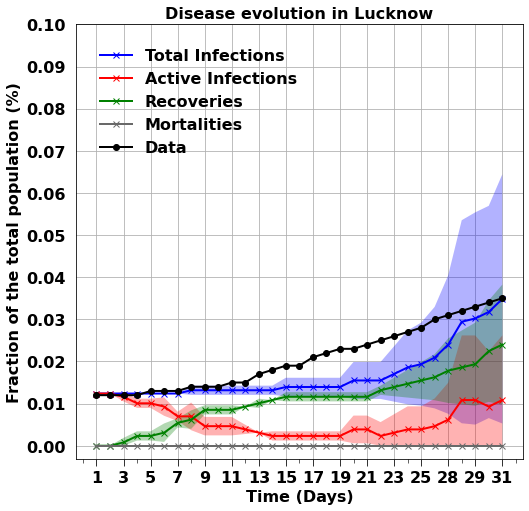

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

s = 96

t=96*31

x = (np.arange(0,t,step=s)/96)+1

cinf_mean = ((FinalTimeSeries[0]/Population)*100).cpu().detach().numpy()
cinf_std = ((FinalTimeSeries[8]/Population)*100).cpu().detach().numpy()

ainf_mean = ((FinalTimeSeries[2]/Population)*100).cpu().detach().numpy()
ainf_std = ((FinalTimeSeries[10]/Population)*100).cpu().detach().numpy()

recovered_mean = ((FinalTimeSeries[3]/Population)*100).cpu().detach().numpy()
recovered_std = ((FinalTimeSeries[11]/Population)*100).cpu().detach().numpy()

deceased_mean = ((FinalTimeSeries[4]/Population)*100).cpu().detach().numpy()
deceased_std = ((FinalTimeSeries[12]/Population)*100).cpu().detach().numpy() 

rinf_mean = recovered_mean
rinf_std = recovered_std

dinf_mean = deceased_mean
dinf_std = deceased_std
data = np.array([0.012,0.012,0.012,0.012,0.013,0.013,0.013,0.014,0.014,0.014,0.015,
                 0.015,0.017,0.018,0.019,0.019,0.021,0.022,0.023,0.023,0.024,0.025,
                 0.026,0.027,0.028,0.030,0.031,0.032,0.033,0.034,0.035])

plt.plot(x,cinf_mean[np.arange(0,t,step=s)],'x-',color='blue',linewidth=2,linestyle='-')
ax.fill_between(x, np.clip(cinf_mean[np.arange(0,t,step=s)]-cinf_std[np.arange(0,t,step=s)],0,np.inf), np.clip(cinf_mean[np.arange(0,t,step=s)]+cinf_std[np.arange(0,t,step=s)],0,np.inf) ,alpha=0.3, facecolor='blue')

plt.plot(x,ainf_mean[np.arange(0,t,step=s)],'x-',color='r',linewidth=2,linestyle='-')
ax.fill_between(x, np.clip(ainf_mean[np.arange(0,t,step=s)]-ainf_std[np.arange(0,t,step=s)],0,np.inf), np.clip(ainf_mean[np.arange(0,t,step=s)]+ainf_std[np.arange(0,t,step=s)],0,np.inf) ,alpha=0.3, facecolor='r')

plt.plot(x,rinf_mean[np.arange(0,t,step=s)],'x-',color='g',linewidth=2,linestyle='-')
ax.fill_between(x, np.clip(rinf_mean[np.arange(0,t,step=s)]-rinf_std[np.arange(0,t,step=s)],0,np.inf), np.clip(rinf_mean[np.arange(0,t,step=s)]+rinf_std[np.arange(0,t,step=s)],0,np.inf) ,alpha=0.3, facecolor='g')

plt.plot(x,dinf_mean[np.arange(0,t,step=s)],'x-',color='dimgray',linewidth=2,linestyle='-')
ax.fill_between(x, np.clip(dinf_mean[np.arange(0,t,step=s)]-dinf_std[np.arange(0,t,step=s)],0,np.inf), np.clip(dinf_mean[np.arange(0,t,step=s)]+dinf_std[np.arange(0,t,step=s)],0,np.inf) ,alpha=0.3, facecolor='dimgray')

plt.plot(np.arange(1,32,step=1),data,'o-',color='black',linewidth=2)

plt.rcParams['figure.facecolor'] = 'ivory'

plt.rcParams["font.weight"] = "bold"

plt.rcParams["axes.labelweight"] = "bold"

ax.grid()

ax.set_axisbelow(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(16))
ax.tick_params(which='major', length=7, color='black')
ax.tick_params(which='minor', length=4, color='black' )
ax.xaxis.set_minor_locator(plt.MaxNLocator())

ax.tick_params(which='both', # Options for both major and minor ticks
               top=False, # turn off top ticks
               left=False, # turn off left ticks
               right=False,  # turn off right ticks
               bottom=True) # turn off bottom ticks
ax.set_xticks(np.arange(1,32,step=2))
ax.set_xticklabels(["1","3","5","7","9","11","13","15","17","19","21","23","25",
                    "28","29","31"])

plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(np.arange(0,0.11,step=0.01),fontsize=16,fontweight='bold')

plt.xlabel('Time (Days)',fontsize=16,fontweight='bold')

plt.ylabel('Fraction of the total population (%)',fontsize=16,fontweight='bold')

plt.legend(['Total Infections','Active Infections','Recoveries','Mortalities','Data'],
           fontsize=16,loc="upper left",fancybox=True, 
           framealpha=0.0, shadow=False, borderpad=1)

plt.title('Disease evolution in Lucknow',fontsize=16,fontweight='bold')

plt.savefig('FL_1.pdf',format='pdf', bbox_inches='tight',Transparent=True)

#files.download('FL_1.pdf')

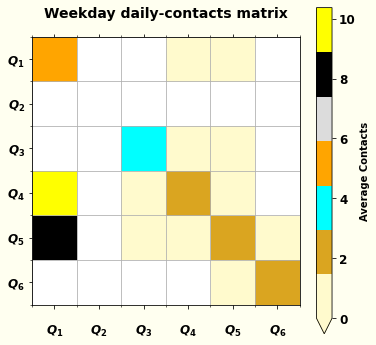

In [ ]:
fig,ax = plt.subplots(figsize=(6, 6))

data1 = InteractionsFinal[0].cpu().detach().numpy()

data1 = np.ma.masked_where(data1 == 0, data1)

data2 = InteractionsFinal[0].cpu().detach().numpy()

data1[0,0] = 5.2

data2[0,0] = 5.2

vmin = np.min(np.array([data1,data2]))

vmax = np.max(np.array([data1,data2]))

alpha = ['$Q_{1}$','$Q_{2}$','$Q_{3}$','$Q_{4}$','$Q_{5}$','$Q_{6}$']

cmap = ListedColormap(["lemonchiffon","goldenrod","cyan","orange","gainsboro", "black","yellow"])

cax = ax.matshow(data1,interpolation='nearest',cmap=cmap, rasterized=True, vmin=vmin, vmax=vmax)

cbar=fig.colorbar(cax,extend='min', label='Average Contacts')

plt.gca().set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')

plt.gca().set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')

plt.grid(which='minor')

cmap.set_bad(color='white')

ax.set_xticklabels(['']+alpha,y=-0.15,fontsize=12)

ax.set_yticklabels(['']+alpha,fontsize=12)

cbar.ax.tick_params(labelsize=12)

plt.title('Weekday daily-contacts matrix',fontweight='bold',fontsize=14)

plt.savefig('IFL_1.pdf',format='pdf', bbox_inches='tight',Transparent=True)

#files.download('IFL_1.pdf')

In [ ]:
!pip install hickle
import hickle as hk
from google.colab import files
hk.dump(FinalTimeSeries.cpu().detach().numpy(),'TS_FL_1.hkl', mode='w')
hk.dump(FinalConstants.cpu().detach().numpy(),'C_FL_1.hkl', mode='w')
hk.dump(InteractionsFinal.cpu().detach().numpy(),'I_FL_1.hkl', mode='w')
files.download('TS_FL_1.hkl')
files.download('C_FL_1.hkl')
files.download('I_FL_1.hkl')

     |████████████████████████████████| 49 kB 2.5 MB/s 
     |████████████████████████████████| 2.9 MB 6.5 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Unlock Phase 2

In [ ]:
%reset -f
!pip install faiss-gpu
!pip install celluloid
import faiss
import numpy as np
from scipy.stats import norm
import time
import torch
from google.colab import files
import random
from sklearn.neighbors import NearestNeighbors
device = 'cuda'
res = faiss.StandardGpuResources()
select = 0
MonteCarlo = 2
Residence = torch.tensor(np.loadtxt('lucknow_agent_location.dat'),dtype=torch.double,device='cuda')
Age = torch.tensor(np.loadtxt('lucknow_Age.dat'),dtype=torch.long,device='cuda')
H_Size = torch.tensor(np.loadtxt('lucknow_Age_House.dat'),dtype=torch.long,device='cuda')
H_Size[H_Size==0] = 1
H_Number = torch.tensor(np.loadtxt('lucknow_House_number.dat'),dtype=torch.long,device='cuda')
H_location = torch.tensor(np.loadtxt('lucknow_household_location.dat'),dtype=torch.long,device='cuda')
# Total Population
Population = 64560
# Number of Children (0), Adults (1), Seniors (2) and Infections (3)
Demography = torch.tensor([round(0.2516*Population),
                           round(0.6835*Population),
                           0,
                           0,
                           8],dtype=torch.long,device='cuda')
Demography[2] = Population-torch.sum(Demography[:2]) 
Demography[3] = 20
# Layout Size: XMinimum (0), XMaximum (1), YMinimum (2), YMaximum (3), Grid Resolution (4)
Layout = torch.tensor([0,5000,0,2000,1000],dtype=torch.double,device='cuda')
# Minimum (0), Maximum (1), Inner (2), Innermost (3) Allowed Speeds
VelocityParameters = torch.tensor([-500,500,200,10,1],dtype=torch.long,device='cuda')
# Collision Radius (0), Infection Radius (1), OuterCircle (2), InnerCircle (3), Reached Goal (4)
Radii = torch.tensor([5,2,570,120,5],dtype=torch.long,device='cuda') # Infection Radius(20) > Collision Radius(5/50) --> no social distancing
# Total time (days), Resolution(minutes)
Time = torch.tensor([31,15],dtype=torch.long, device='cuda') 
# TimeSteps in a day (1 step = 15mins) and total
TimeStepsDay = torch.div(24*60,Time[1].item())
# Total time steps in 31 days
TimeStepsTotal = TimeStepsDay*Time[0].long()
# Re-assign x and y initial positions
# Assign positions within unit radius
adjustment = 0.5
Residence = H_location[H_Number] + torch.DoubleTensor(Population,2).uniform_(-adjustment,adjustment).cuda()
# Check if the newly assigned x co-ordinate is within the boundary
Residence[Residence[:,0]>Layout[1],0] = (torch.DoubleTensor(Population).uniform_(Layout[1]-adjustment,Layout[1]).cuda())[Residence[:,0]>Layout[1]]
Residence[Residence[:,0]<Layout[0],0] = (torch.DoubleTensor(Population).uniform_(Layout[0],Layout[0]+adjustment).cuda())[Residence[:,0]<Layout[0]]
# Check if the newly assigned y co-ordinate is within the boundary
Residence[Residence[:,1]>Layout[3],1] = (torch.DoubleTensor(Population).uniform_(Layout[3]-adjustment,Layout[3]).cuda())[Residence[:,1]>Layout[3]]
Residence[Residence[:,1]<Layout[2],1] = (torch.DoubleTensor(Population).uniform_(Layout[2],Layout[2]+adjustment).cuda())[Residence[:,1]<Layout[2]]
Activities = np.zeros((20,96),dtype=np.float32)
# Children
# Errands 
Activities[0,24:36]=0.005*norm.pdf(np.arange(6,9,step=0.25), 7.5, 1) # 6-9
Activities[0,36:56]=0.01*norm.pdf(np.arange(9,14,step=0.25), 11.5, 1) # 9-14
Activities[0,56:72]=0.025*norm.pdf(np.arange(14,18,step=0.25), 17, 1) # 14-21
# Adults
# Errands 
Activities[8,24:36]=0.025*norm.pdf(np.arange(6,9,step=0.25), 7.5, 1) # 6-9
Activities[8,36:56]=0.05*norm.pdf(np.arange(9,14,step=0.25), 11.5, 1) # 9-14
Activities[8,56:72]=0.075*norm.pdf(np.arange(14,18,step=0.25), 17, 1) # 14-21
# Nomadic
Activities[12,24:48] = 0.1*norm.pdf(np.arange(6,12,step=0.25), 10, 1) # 6-12
Activities[12,48:72] = 0.25*norm.pdf(np.arange(12,18,step=0.25), 16, 1) # 12-21
# Nomads go home (18) # Weekday
Activities[18,0:24] = np.ones(24)
Activities[18,84:96] = np.ones(12)
# Nomads go home (19) # Weekend
Activities[19,0:96] = np.ones(96)
# Children
# Market
Activities[1,24:48]=0.01*norm.pdf(np.arange(6,12,step=0.25), 10, 1) # 6-12
Activities[1,48:72]=0.02*norm.pdf(np.arange(12,18,step=0.25), 16, 1) # 12-21
# Adults
# Market
Activities[9,24:48]=0.015*norm.pdf(np.arange(6,12,step=0.25), 10, 1) # 6-12
Activities[9,48:72]=0.03*norm.pdf(np.arange(12,18,step=0.25), 17, 1) # 12-21
# Office 
Activities[10,24:48]= 2*norm.pdf(np.arange(6,12,step=0.25), 9, 1) # 6-12
Activities[11,48:72] = 2*norm.pdf(np.arange(12,18,step=0.25), 16, 1) # 12-21
# Weekday Activities
Limits = torch.tensor([0,0,0,0,0,0,1,100,1,100,0,0,
                       0,0,0,0,0,0,0,0,0,0,0,0,
                       0,0,0,0,0,100,2,100,2,100,0,0,
                       5,100,0,0,1,100,1,100,1,100,0,0,
                       8,100,0,0,2,100,1,100,1,100,1,100,
                       0,0,0,0,0,0,0,0,1,100,1,100],dtype=torch.long,device='cuda')
# Weekend Activities                    
Limits_Weekend = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0],dtype=torch.long,device='cuda')
Location_one = torch.tensor([12,13,14,15,16,17],dtype=torch.long,device='cuda') # Location of i
Location_two = torch.tensor([[12,0,0,15,16,0],
                             [0,0,0,0,0,0],
                             [0,0,14,15,16,0],
                             [12,0,14,15,16,0],
                             [12,0,14,15,16,17],
                             [0,0,0,0,16,17]],dtype=torch.long,device='cuda') # Corresponding locations of j  
def goal_assign(x,y,minbias,maxbias,xhalfmark,yhalfmark):
  '''
  Generate Random Goals
  '''
  # ordinate
  l = torch.zeros((Population),dtype=torch.double,device='cuda')
  # abscissa
  m = torch.zeros((Population),dtype=torch.double,device='cuda')
  temp = x -  torch.FloatTensor(Population).uniform_(minbias,maxbias).cuda()
  l[x>xhalfmark] = temp[x>xhalfmark] 
  temp = y -  torch.FloatTensor(Population).uniform_(minbias,maxbias).cuda()
  m[y>yhalfmark] = temp[y>yhalfmark] 
  temp = x +  torch.FloatTensor(Population).uniform_(minbias,maxbias).cuda()
  l[x<xhalfmark] = temp[x<xhalfmark] 
  temp = y +  torch.FloatTensor(Population).uniform_(minbias,maxbias).cuda()
  m[y<yhalfmark] = temp[y<yhalfmark] 
  return l,m   

def generateMatrix(agents,matrixone,limits,Population, H_Number, index,con_one, con_two,Time_Daily,matrixthree,distance,radius):
  '''
  Generate a conditional contact matrix
  '''
  # Store end result
  matrixtwo = torch.zeros((2,Population,20),dtype=torch.double,device='cuda')
  count=0
  for i in range(6):
    vec_con1 = torch.zeros((Population),device='cuda',dtype=torch.bool)
    vec_con1 += (agents==con_one[i])
    Time_Daily[vec_con1==True,i]+=1
    for j in range(6):
      temp = torch.zeros((Population,20),device='cuda',dtype=torch.int32)
      vec_con2 = torch.zeros((Population,20),device='cuda',dtype=torch.bool)      
      if (con_two[i][j]!=0):
        if (count==0):          
          vec_con2 = torch.logical_and(H_Number[index]==H_Number[:,None],(agents[index]==con_two[i][j]))
        else:
          vec_con2 = (agents[index]==con_two[i][j])
        temp = vec_con1[:,None]*vec_con2
        matrixone[:,count] += torch.sum(temp,1)
        #matrixone[:,count] += torch.sum(torch.logical_and(temp,distance<radius),1)
        if (count!=0):
          matrixone[matrixone[:,count]>limits[:,count],count] = limits[matrixone[:,count]>limits[:,count],count]
        #tempone = temp*(1-(torch.cumsum(torch.logical_and(temp,distance<radius),axis=1)>matrixone[:,count][:,None]).long())
        tempone = temp*(1-(torch.cumsum(temp,axis=1)>matrixone[:,count][:,None]).long())
        matrixtwo[0] += tempone
        matrixtwo[1] = temp
        if (torch.where(vec_con1==True)[0].size(0)!=0):
          matrixthree[i,j] += torch.where(tempone==1)[0].size(0)/torch.where(vec_con1==True)[0].size(0)
      count+=1
  return matrixtwo[0],matrixtwo[1], matrixone, matrixthree, Time_Daily

def nearest_destination(Population,centroids,Residence): 
  '''
  Find the nearest destination: Office/School/Market
  '''
  distance = torch.zeros((Population,len(centroids)),device='cuda',dtype=torch.double)
  for i in range(len(centroids)):
    # Check the distance from the centroid of the zone to each household location
    distance[:,i] = torch.linalg.norm(Residence-Centroids[i],axis=1)
  return torch.argmin(distance,axis=1)

# Schools
# Co-ordinates of different schools
School=torch.tensor([[1500,2000,200,500],
                     [2000,2500,1000,1500],
                     [600,1000,1100,1500],
                     [3900,4500,500,700]],dtype=torch.long,device='cuda')
# Generate Destinations in different school zones
School_Positions = torch.zeros((Population,8),dtype=torch.double,device='cuda')
# x-co-ordinate
School_Positions[:,0] = torch.DoubleTensor(Population).uniform_(School[0,0],School[0,1])
School_Positions[:,2] = torch.DoubleTensor(Population).uniform_(School[1,0],School[1,1])
School_Positions[:,4] = torch.DoubleTensor(Population).uniform_(School[2,0],School[2,1])
School_Positions[:,6] = torch.DoubleTensor(Population).uniform_(School[3,0],School[3,1])
# y-co-ordinate
School_Positions[:,1] = torch.DoubleTensor(Population).uniform_(School[0,2],School[0,3])
School_Positions[:,3] = torch.DoubleTensor(Population).uniform_(School[1,2],School[1,3])
School_Positions[:,5] = torch.DoubleTensor(Population).uniform_(School[2,2],School[2,3])
School_Positions[:,7] = torch.DoubleTensor(Population).uniform_(School[3,2],School[3,3])

# Offices
# Co-ordinates of different offices
Office = torch.tensor([[0,500,500,1000],
                      [4000,4500,1000,1500],
                      [2000,3000,500,1000]],dtype=torch.long,device='cuda')
# Generate destinations in office zones
Office_Positions = torch.zeros((Population,6),dtype=torch.double,device='cuda')
# x co-ordinate
Office_Positions[:,0] = torch.DoubleTensor(Population).uniform_(Office[0,0],Office[0,1])
Office_Positions[:,2] = torch.DoubleTensor(Population).uniform_(Office[1,0],Office[1,1])
Office_Positions[:,4] = torch.DoubleTensor(Population).uniform_(Office[2,0],Office[2,1])
# y co-ordinate
Office_Positions[:,1] = torch.DoubleTensor(Population).uniform_(Office[0,2],Office[0,3])
Office_Positions[:,3] = torch.DoubleTensor(Population).uniform_(Office[1,2],Office[1,3])
Office_Positions[:,5] = torch.DoubleTensor(Population).uniform_(Office[2,2],Office[2,3])

# Markets
# Co-ordinates of different markets
Market = torch.tensor([[3000,3500,1500,2000],
                       [4600,5000,700,900],
                       [900,1500,600,1000],
                       [0,400,1000,1300],
                       [1000,1500,1500,2000]],dtype=torch.long,device='cuda')
# Generate destinations in market zones
Market_Positions = torch.zeros((Population,10),dtype=torch.double,device='cuda')
# x co-ordinate
Market_Positions[:,0] = torch.DoubleTensor(Population).uniform_(Market[0,0],Market[0,1])
Market_Positions[:,2] = torch.DoubleTensor(Population).uniform_(Market[1,0],Market[1,1])
Market_Positions[:,4] = torch.DoubleTensor(Population).uniform_(Market[2,0],Market[2,1])
Market_Positions[:,6] = torch.DoubleTensor(Population).uniform_(Market[3,0],Market[3,1])
Market_Positions[:,8] = torch.DoubleTensor(Population).uniform_(Market[4,0],Market[4,1])
# y co-ordinate
Market_Positions[:,1] = torch.DoubleTensor(Population).uniform_(Market[0,2],Market[0,3])
Market_Positions[:,3] = torch.DoubleTensor(Population).uniform_(Market[1,2],Market[1,3])
Market_Positions[:,5] = torch.DoubleTensor(Population).uniform_(Market[2,2],Market[2,3])
Market_Positions[:,7] = torch.DoubleTensor(Population).uniform_(Market[3,2],Market[3,3])
Market_Positions[:,9] = torch.DoubleTensor(Population).uniform_(Market[4,2],Market[4,3])

# Centroids of each zone
Centroids = torch.zeros((12,2),dtype=torch.double,device='cuda')
# Centroids of school zones
Centroids[:4,0] = School[:,0] + 0.5*School[:,1]
Centroids[:4,1] = School[:,2] + 0.5*School[:,3]
# Centroids of office zones
Centroids[4:7,0] = Office[:,0] + 0.5*Office[:,1]
Centroids[4:7,1] = Office[:,2] + 0.5*Office[:,3]
# Centroids of market zones
Centroids[7:12,0] = Market[:,0] + 0.5*Market[:,1]
Centroids[7:12,1] = Market[:,2] + 0.5*Market[:,3]

# Find nearest destination
Nearest = torch.zeros((Population,3),device='cuda',dtype=torch.long)
# Nearest school
Nearest[:,0] = nearest_destination(Population,Centroids[:4],Residence)
# Nearest office
Nearest[:,1] = nearest_destination(Population,Centroids[4:7],Residence)
# Nearest market
Nearest[:,2] = nearest_destination(Population,Centroids[7:12],Residence)
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Disease Transmission Parameters
# -------------------------------------

# States: SIT/SIN/AIT/AIN/SUT/SUN
States = torch.tensor(([0,0,0,0,0,1,2,3],
                       [0,0,0,1,0,0,0,0],
                       [6,7,6,7,0,0,0,0],
                       [9,9,9,9,0,0,0,0],
                       [0,0,0,0,0,0,0,0],
                       [0,1,2,3,4,5,6,7]),dtype=torch.int,device='cuda')
# Disease Transition Probabilities
Transition = torch.zeros((3,6,8),dtype=torch.double,device='cuda')
undercount = 0
# Children 
Transition[0] = torch.transpose(torch.tensor(([0,0,0.12495,0.00005,0,0.875],
                                              [0,0,0.09994,0.00006,undercount,0.9-undercount],
                                              [0,0.00998,0.19,0.00002,0,0.8],
                                              [0,0.02996,0.12,0.00004,undercount,0.85-undercount],
                                              [0.2537,0,0,0,0,0.7463],
                                              [0.2537,0,0,0,0,0.7463],
                                              [0.2537,0,0,0,0,0.7463],
                                              [0.2537,0,0,0,0,0.7463]),dtype=torch.double,device='cuda'),0,1) 
# Adults
Transition[1] = torch.transpose(torch.tensor(([0,0,0.124,0.001,0,0.875],
                                              [0,0,0.06,0.04,undercount,0.9-undercount],
                                              [0,0.03993,0.16,0.00007,0,0.8],
                                              [0,0.0493,0.1,0.0007,undercount,0.85-undercount],
                                              [0.5,0,0,0,0,0.5],
                                              [0.5,0,0,0,0,0.5],
                                              [0.5,0,0,0,0,0.5],
                                              [0.5,0,0,0,0,0.5]),dtype=torch.double,device='cuda'),0,1) 
# Seniors
Transition[2] = torch.transpose(torch.tensor(([0,0,0.065,0.06,0,0.875],
                                              [0,0,0.02,0.08,undercount,0.9-undercount],
                                              [0,0.08,0.1,0.02,0,0.8],
                                              [0,0.1,0.01,0.04,undercount,0.85-undercount],
                                              [0.5951,0,0,0,0,0.4049],
                                              [0.5951,0,0,0,0,0.4049],
                                              [0.5951,0,0,0,0,0.4049],
                                              [0.5951,0,0,0,0,0.4049]),dtype=torch.double,device='cuda'),0,1)
# Storage Parameters
# Outermost Loop (Scenario/Final Parameters)
# Disease Transmission: S/IT/INT/R/D/Total (7+7, Mean and Variance states) 
FinalTimeSeries = torch.zeros((65,(TimeStepsTotal.long().item())+1), dtype=torch.float,device='cuda')
# Time to infection, death, recovery (Mean - 0,1,2, Variance - 3,4,5)
FinalConstants = torch.zeros((20), dtype=torch.float,device='cuda')
InteractionsFinal = torch.zeros((2,6,6),dtype=torch.float,device='cuda')
# Outermost loop
# Second Loop (MonteCarlo Run Parameters)
# ResultsTimeSeries (Time Series for MC runs)(0-6)
ResultsTMC = torch.zeros((MonteCarlo,29,(TimeStepsTotal.long().item())+1), dtype=torch.float,device='cuda')
# Results Constants: Time to Infection: Overall(0), Recovery(1), Death(2)
ResultsCMC = torch.zeros((MonteCarlo,10,1), dtype=torch.float,device='cuda')
InteractionsMC = torch.zeros((MonteCarlo,2,6,6), dtype=torch.float,device='cuda') 
for mc in range(MonteCarlo): 
  # Create N agents;
  # Age = 0,     
  # x_position = 1, 
  # y_position = 2, 
  # x_velocity = 3, 
  # y_velocity = 4, 
  # occupation = 5,
  # current_task = 7, 
  # status_of_task = 8, 
  # goal_x = 9, 
  # goal_y = 10,
  # infection_status = 14, 
  # infection_state = 15, 
  # time_of_infectiousness = 16
  Agents = torch.zeros((Population,20),dtype=torch.double,device='cuda')
  # Assign Age 
  Agents[:,0] = Age
  # Indices of Children
  Children = torch.where(Agents[:,0]==0)[0]
  # Indices of Adults
  Adults = torch.where(Agents[:,0]==1)[0]
  # Indices of Seniors
  Seniors = torch.where(Agents[:,0]==2)[0]
  # Assign x and y Positions
  # PositionX (1)
  Agents[:,1] = Residence[:,0].detach().clone()
  # PositionY (2)
  Agents[:,2] = Residence[:,1].detach().clone()
  # Assign x and y Velocity Components
  # VelocityX (3)
  Agents[:,3] = torch.DoubleTensor(Population).uniform_(VelocityParameters[0],VelocityParameters[1])
  # VelocityY (4)
  Agents[:,4] = torch.DoubleTensor(Population).uniform_(VelocityParameters[0],VelocityParameters[1])
  # Social Distance:  
  SD = Radii[0]*torch.ones((Population),dtype=torch.long,device='cuda')
  # Fraction not following (0: Everyone, 1: No one)
  SD[torch.tensor([True,False],device='cuda')[torch.multinomial(torch.tensor([0.9,0.1]),Population,replacement=True)]] = 0
  # Occupation (5): 
  # School-going Children (1)
  Agents[Children[:int(0.75*Demography[0])],5] = 1
  # School-going Adults (1)
  Agents[Adults[:int(0.05*Demography[1])],5] = 1
  # School-going Seniors (1)
  Agents[Seniors[:int(0.02*Demography[2])],5] = 1
  # Stay-at-home adults (2)
  Agents[Adults[int(0.05*Demography[1]):int(0.25*Demography[1])],5] = 2
  # Office Going Adults (3)
  Agents[Adults[int(0.25*Demography[1]):int(0.85*Demography[1])],5] = 3
  # Nomadic Adults (4)
  Agents[Adults[int(0.85*Demography[1]):Demography[1]],5] = 4
  # Stay-at-home Seniors (5)
  Agents[Seniors[int(0.02*Demography[2]):int(0.62*Demography[2])],5] = 5 
  # Office Going Seniors (6)
  Agents[Seniors[int(0.62*Demography[2]):int(0.95*Demography[2])],5] = 6
  # Nomadic Seniors (7)
  Agents[Seniors[int(0.95*Demography[2]):Demography[2]],5] = 7
  # Assign Infection Status: Infected and Tested (1), Uninfect(0), Infected and Not Tested (3)
  # 0.5% infections among children, 49% infections among adults, 50.5% among seniors
  Agents[Children[:int(0.005*Demography[3])],14] = 3 # Infected 
  Agents[Adults[int(0.005*Demography[3]):int(0.49*Demography[3])],14] = 3 # Infected 
  Agents[Seniors[int(0.49*Demography[3]):Demography[3]],14] = 3 # Infected 
  Agents[torch.where(Agents[:,14]==3)[0][:int(Demography[4])],14] = 1 # Confirmed Infections
  # Assign Infection State: SIT=0, SIN=1, AIT=2, AIN=3, SUT=4, SUN=5, AUT=6, AUN=7
  # Infected
  # 80% of the infections are asymptomatic
  # 20% of the infections are symptomatic
  Agents[torch.where(Agents[:,14]==3)[0][:int(0.8*Demography[3])],15] = 3 # AIN
  Agents[torch.where(Agents[:,14]==3)[0][int(0.8*Demography[3]):Demography[3]],15] = 1 # SIN
  # Uninfected
  # 85% of the uninfected are asymptomatic
  # 15% of the uninfected are symptomatic
  Agents[torch.where(Agents[:,14]==0)[0][:int(0.85*(Population-Demography[3]))],15] = 7 # AUN
  Agents[torch.where(Agents[:,14]==0)[0][int(0.85*(Population-Demography[3])):Population-Demography[3]],15] = 5 # SUN
  Agents[torch.where(Agents[:,14]==1)[0],15] = 2
  # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  # Placeholder Variables
  # -------------------------------------

  # Vectors 
  Vectors = torch.zeros((12,Population),device='cuda',dtype=torch.double)
  # Distance Matrix(0), Index Matrix(1), Condition Matrix(2)
  Matrixs = torch.zeros((5,Population,20),dtype=torch.double,device='cuda')
  # Initial Position 
  CurrentPosition = torch.dstack((Agents[:,1],Agents[:,2]))
  # Initial Velocity
  Velocity = torch.dstack((Agents[:,3],Agents[:,4]))
  # All agents are initially at home (12)
  Agents[:,7] = 12
  # Status of the task is complete and initially at home (12)
  Agents[:,8] = Agents[:,7].detach().clone()
  # Ordinate of goal position
  Agents[:,9] = Agents[:,1].detach().clone()
  # Abscissa of goal position
  Agents[:,10] = Agents[:,2].detach().clone()
  # Initial Goals are to remain at home
  Destination = torch.dstack((Agents[:,1],Agents[:,2]))
  # Days 
  Days = torch.tensor([0],device='cuda')       
  # Distance
  Distance = torch.zeros((Population),dtype=torch.double,device='cuda')
  # Infection Status over Time
  # Overall
  Results = torch.tensor([torch.where(Agents[:,14]==0)[0].size()[0], #0:Uninfected
                          torch.where(Agents[:,14]==1)[0].size()[0], #1:Infected and Tested
                          torch.where(Agents[:,14]==2)[0].size()[0], #2:Unreported Recoveries
                          torch.where(Agents[:,14]==3)[0].size()[0], #3:Infected and Not Tested
                          torch.where(Agents[:,14]==4)[0].size()[0], #4:Unreported Deaths
                          torch.where(Agents[:,14]==5)[0].size()[0], #5:Reported Recoveries
                          torch.where(Agents[:,14]==6)[0].size()[0]],dtype=torch.long,device='cuda') #6:Reported Deaths  
  # Children
  ResultsC = torch.tensor([torch.where(Agents[Children,14]==0)[0].size()[0],
                          torch.where(Agents[Children,14]==1)[0].size()[0],
                          torch.where(Agents[Children,14]==2)[0].size()[0],
                          torch.where(Agents[Children,14]==3)[0].size()[0],
                          torch.where(Agents[Children,14]==4)[0].size()[0],
                          torch.where(Agents[Children,14]==5)[0].size()[0],
                          torch.where(Agents[Children,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')   
  # Adults  
  ResultsA = torch.tensor([torch.where(Agents[Adults,14]==0)[0].size()[0],
                          torch.where(Agents[Adults,14]==1)[0].size()[0],
                          torch.where(Agents[Adults,14]==2)[0].size()[0],
                          torch.where(Agents[Adults,14]==3)[0].size()[0],
                          torch.where(Agents[Adults,14]==4)[0].size()[0],
                          torch.where(Agents[Adults,14]==5)[0].size()[0],
                          torch.where(Agents[Adults,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')   
  # Seniors
  ResultsS = torch.tensor([torch.where(Agents[Seniors,14]==0)[0].size()[0],
                          torch.where(Agents[Seniors,14]==1)[0].size()[0],
                          torch.where(Agents[Seniors,14]==2)[0].size()[0],
                          torch.where(Agents[Seniors,14]==3)[0].size()[0],
                          torch.where(Agents[Seniors,14]==4)[0].size()[0],
                          torch.where(Agents[Seniors,14]==5)[0].size()[0],
                          torch.where(Agents[Seniors,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')   

  # Interactions: Weekday=0, Weekend=1, Contact_Matrix=2
  Interactions = torch.zeros((3,6,6),dtype=torch.double,device='cuda')
  # Weekday = 0, Weekend = 1
  Time_avg = torch.zeros((2,6),dtype=torch.double,device='cuda')
  Time_Daily = torch.zeros((Population,6),dtype=torch.long,device='cuda')
  # Number of contacts on a day to day basis: Daily_Contact=0, Contact_Limit=1
  Contacts = torch.zeros((2,Population,36),dtype=torch.long,device='cuda')
  StatusTime = Agents[:,8].detach().clone()
  for t in range(TimeStepsTotal.long().item()):

    Days = torch.floor(torch.div(t,TimeStepsDay).cuda())
    # Time of the day
    time_of_day = t%96 
    # Day of the week
    day_of_week = Days%7 

    # ------------------------------------------------
    # Store parameters from the previous run
    # ------------------------------------------------

    # Infection Status from previous iteration
    Vectors[4] = Agents[:,14].detach().clone()
    # Infection State from previous iteration
    Vectors[5] = Agents[:,15].detach().clone()
    # Rtime
    Vectors[6] = Vectors[1].detach().clone()

    # ---------------------------------------------
    # Find Limits for the day
    # ---------------------------------------------

    if time_of_day==0:
      # Assign contact limits for the weekend
      if torch.logical_or(day_of_week==5,day_of_week==6):
        for i in range(1,36):
          Contacts[1][:,i] = Limits_Weekend[2*i+1]
      else:
        # Assign contact limits for the weekday
        for i in range(1,36):
          Contacts[1][:,i] = Limits[2*i+1]

    #Agents[:,15]: SIT=0, SIN=1, AIT=2, AIN=3, SUT=4, SUN=5, AUT=6, AUN=7
    #Unconfirmed to Confirmed (30 times underreported)
    Vectors[0] = torch.rand(Population,device='cuda').double()< 0.0000103#0.00000220627#0.0000000.00000051702 #0.0000450422
    Vectors[7] = torch.logical_and(Agents[:,15]==1,Vectors[0]==True)
    Agents[Vectors[7].bool(),15] = 0 # SIN --> SIT
    Vectors[7] = torch.logical_and(Agents[:,15]==3,Vectors[0]==True)
    Agents[Vectors[7].bool(),15] = 2 # AIN --> AIT
    # Confirmed Cases
    # Infected and Tested
    Agents[:,14][torch.logical_or(Agents[:,15]==0,Agents[:,15]==2)] = 1
    # Unconfirmed
    Agents[:,14][torch.logical_or(Agents[:,15]==1,Agents[:,15]==3)] = 3  

    # ---------------------------------------------
    # State Transition of Infected Agents
    # ---------------------------------------------

    # Find all agents who have been infected for more than a day
    Vectors[8] = torch.logical_and(torch.logical_and(torch.logical_or(Vectors[4]==1,Vectors[4]==3),Agents[:,16]%TimeStepsDay==0),Agents[:,16]>0)
    #Vectors[8] = torch.logical_or(Vectors[4]==1,Vectors[4]==3)
    # SIT=0: Is the person in state 0 a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==0),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,0][torch.multinomial(Transition[0][:,0],Population,replacement=True)][Vectors[7].bool()].double()
    # SIT=0: Is the person in state 0 an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==0),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,0][torch.multinomial(Transition[1][:,0],Population,replacement=True)][Vectors[7].bool()].double()
    # SIT=0: Is the person in state 0 a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==0),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,0][torch.multinomial(Transition[2][:,0],Population,replacement=True)][Vectors[7].bool()].double()  
    # SIN=1: Is the person in state 1 a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==1),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,1][torch.multinomial(Transition[0][:,1],Population,replacement=True)][Vectors[7].bool()].double()
    # SIN=1: Is the person in state 1 an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==1),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,1][torch.multinomial(Transition[1][:,1],Population,replacement=True)][Vectors[7].bool()].double()
    # SIN=1: Is the person in state 1 a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==1),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,1][torch.multinomial(Transition[2][:,1],Population,replacement=True)][Vectors[7].bool()].double()
    # AIT=2: Is the person in state 2 a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==2),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,2][torch.multinomial(Transition[0][:,2],Population,replacement=True)][Vectors[7].bool()].double()
    # AIT=2: Is the person in state 2 an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==2),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,2][torch.multinomial(Transition[1][:,2],Population,replacement=True)][Vectors[7].bool()].double()
    # AIT=2: Is the person in state 2 a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==2),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,2][torch.multinomial(Transition[2][:,2],Population,replacement=True)][Vectors[7].bool()].double()
    # AIN=3: Is the person in state 3 a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==3),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,3][torch.multinomial(Transition[0][:,3],Population,replacement=True)][Vectors[7].bool()].double()
    # AIN=3: Is the person in state 3 an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==3),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,3][torch.multinomial(Transition[1][:,3],Population,replacement=True)][Vectors[7].bool()].double()
    # AIN=3: Is the person in state 3 a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==3),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,3][torch.multinomial(Transition[2][:,3],Population,replacement=True)][Vectors[7].bool()].double()
    # Recovery
    Agents[:,14][(Vectors[4]==1) & (Agents[:,15]==6)] = 5 # Reported recoveries
    Agents[:,14][(Vectors[4]==3) & (Agents[:,15]==7)] = 2 # Unreported recoveries
    # Deaths
    Agents[:,14][(Vectors[4]==1) & (Agents[:,15]==9)] = 6 # Reported recoveries
    Agents[:,14][(Vectors[4]==3) & (Agents[:,15]==9)] = 4 # Unreported recoveries  
    # Time Since Infection
    Vectors[8] = torch.logical_or(Agents[:,14]==1,Agents[:,14]==3)
    Agents[:,16][Vectors[8].bool()] = Agents[:,16][Vectors[8].bool()]+1
    Agents[:,17][Vectors[8].bool()] = torch.round(torch.div(Agents[:,16][Vectors[8].bool()],TimeStepsDay-1)) 

    # -----------------------------------------
    # State Transition of Uninfected Agents
    # -----------------------------------------  

    # Find agents in the vicinity
    CurrentPosition_numpy = np.float32(CurrentPosition[0].cpu().detach().numpy())
    # Create a faiss array
    index_flat = faiss.IndexFlatL2(CurrentPosition_numpy.shape[1])
    gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
    gpu_index_flat.add(CurrentPosition_numpy)                  
    m, n = gpu_index_flat.search(CurrentPosition_numpy, 20)
    Matrixs[1] = torch.from_numpy(n).long()
    #Matrixs[1] = torch.reshape(q[q!=torch.arange(0,Population,step=1)[:,None]],(Population,19))
    # Distances 
    Matrixs[0] = torch.squeeze(torch.cdist(CurrentPosition[0][:,None],CurrentPosition[0][Matrixs[1].long()],p=2))
    Matrixs[0][Matrixs[1]==torch.arange(0,Population,step=1).cuda()[:,None]] = float("Inf")
    # Location Matching and Contact Number Check
    Matrixs[2],Matrixs[4],Contacts[0],Interactions[2],Time_Daily = generateMatrix(Agents[:,8],Contacts[0],Contacts[1],Population,H_Number,Matrixs[1].long(),Location_one, Location_two,Time_Daily,Interactions[2],Matrixs[0],Radii[1])

    if torch.logical_or(day_of_week==5,day_of_week==6):
      Time_avg[1] += torch.mean(Time_Daily.double(),0)
      Time_Daily = torch.zeros((Population,6),dtype=torch.long,device='cuda')
      Interactions[1] += Interactions[2]/48#torch.reshape(torch.sum(Contacts[0],0),(6,6))
      Interactions[2] = torch.zeros((6,6),dtype=torch.double,device='cuda')
      Contacts[0] = torch.zeros((Population,36),dtype=torch.long,device='cuda')
    else:
    # Over weekdays
      Time_avg[0] += torch.mean(Time_Daily.double(),0)
      Time_Daily = torch.zeros((Population,6),dtype=torch.long,device='cuda')
      Interactions[0] += Interactions[2]/48#torch.reshape(torch.sum(Contacts[0],0),(6,6))
      Interactions[2] = torch.zeros((6,6),dtype=torch.double,device='cuda')
      Contacts[0] = torch.zeros((Population,36),dtype=torch.long,device='cuda')
  
    # Find agents with infections in the vicinity
    Vectors[3] = torch.sum(torch.logical_and(torch.logical_and(Matrixs[2].bool()==True,Matrixs[0]<Radii[1]),torch.logical_or(Vectors[4][Matrixs[1].long()]==1,Vectors[4][Matrixs[1].long()]==3)),1)
    # Find all uninfected agents with infections in their vicinity
    Vectors[8] = torch.logical_and(Vectors[4]==0,Vectors[3].long()>0)
    # SUT=4: Is the susceptible person a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==4),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,4][torch.multinomial(Transition[0][:,4],Population,replacement=True)][Vectors[7].bool()].double()
    # SUT=4: Is the susceptible person an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==4),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,4][torch.multinomial(Transition[1][:,4],Population,replacement=True)][Vectors[7].bool()].double()
    # SUT=4: Is the susceptible person a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==4),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,4][torch.multinomial(Transition[2][:,4],Population,replacement=True)][Vectors[7].bool()].double()
    # SUN=5: Is the susceptible person a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==5),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,5][torch.multinomial(Transition[0][:,5],Population,replacement=True)][Vectors[7].bool()].double()
    # SUN=5: Is the susceptible person an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==5),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,5][torch.multinomial(Transition[1][:,5],Population,replacement=True)][Vectors[7].bool()].double()
    # SUN=5: Is the susceptible person a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==5),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,5][torch.multinomial(Transition[2][:,5],Population,replacement=True)][Vectors[7].bool()].double()
    # AUT=6: Is the susceptible person a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==6),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,6][torch.multinomial(Transition[0][:,6],Population,replacement=True)][Vectors[7].bool()].double()
    # AUT=6: Is the susceptible person an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==6),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,6][torch.multinomial(Transition[1][:,6],Population,replacement=True)][Vectors[7].bool()].double()
    # AUT=6: Is the susceptible person a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==6),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,6][torch.multinomial(Transition[2][:,6],Population,replacement=True)][Vectors[7].bool()].double()
    # AUN=7: Is the susceptible person a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==7),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,7][torch.multinomial(Transition[0][:,7],Population,replacement=True)][Vectors[7].bool()].double()
    # AUN=7: Is the susceptible person an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==7),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,7][torch.multinomial(Transition[1][:,7],Population,replacement=True)][Vectors[7].bool()].double()
    # AUN=7: Is the susceptible person a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==7),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,7][torch.multinomial(Transition[2][:,7],Population,replacement=True)][Vectors[7].bool()].double() 


    # -----------------------------------------
    # Task Allocation
    # ----------------------------------------- 

    # Weekday
    if day_of_week<5:
      
      # Children
      # School going children at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==0,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going children: School (1), Random (4), Market (7), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,4,7,12],device='cuda')[torch.multinomial(torch.tensor([Activities[2,time_of_day],Activities[0,time_of_day],Activities[1,time_of_day],1-Activities[0,time_of_day]-Activities[1,time_of_day]-Activities[2,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home kids
      Vectors[8] = torch.logical_and(Agents[:,5]==0, Agents[:,8]==12)
      # Destination for children: Random (4), Market (7), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([4,7,12],device='cuda')[torch.multinomial(torch.tensor([Activities[0,time_of_day],Activities[1,time_of_day],1-Activities[0,time_of_day]-Activities[1,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids at school
      Vectors[8] = Agents[:,8]==13
      # Remain in School: Stay at school (13), Go home (0) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,13],device='cuda')[torch.multinomial(torch.tensor([Activities[3,time_of_day],1-Activities[3,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==0,Agents[:,8]==15)
      # Stay there (15), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==0,Agents[:,8]==17)
      # Stay there (17), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      
      # Adults
      # School going adults at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==1,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going adults: School (1), Random (5), Market (8), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[2,time_of_day],Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[2,time_of_day]-Activities[8,time_of_day]-Activities[9,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Office going adults
      Vectors[8] = torch.logical_and(Agents[:,5]==3, Agents[:,8]==12)
      # Destination for office going adults: Office (2), Random (5), Market (8), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([2,5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[10,time_of_day],Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[8,time_of_day]-Activities[9,time_of_day]-Activities[10,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Stay at home adults
      Vectors[8] = torch.logical_and(Agents[:,5]==2,Agents[:,8]==12)  
      # Destination for adults: Random (5), Market (8), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[8,time_of_day]-Activities[9,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic adults at home
      Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(Agents[:,5]==4,Agents[:,8]==12))
      # Adults who are nomads: Go elsewhere (10), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([10,12],device='cuda')[torch.multinomial(torch.tensor([Activities[12,time_of_day],1-Activities[12,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic adults on the move
      Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(Agents[:,5]==4,Agents[:,8]==16)) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,10,16],device='cuda')[torch.multinomial(torch.tensor([Activities[18,time_of_day],Activities[12,time_of_day],1-Activities[18,time_of_day]-Activities[12,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults at the office
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==14)  
      # Stay there (14), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,14],device='cuda')[torch.multinomial(torch.tensor([Activities[11,time_of_day],1-Activities[11,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==15)  
      # Stay there (15), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==17)  
      # Stay there (17), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      
      # Seniors
      # School going seniors at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==2,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going seniors: School (1), Random (6), Market (9), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[2,time_of_day],Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[2,time_of_day]-Activities[8,time_of_day]-Activities[9,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Office going seniors
      Vectors[8] = torch.logical_and(Agents[:,5]==6, Agents[:,8]==12)  
      # Destination for office going seniors: Office (3), Random (6), Market (9), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([3,6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[10,time_of_day],Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[8,time_of_day]-Activities[9,time_of_day]-Activities[10,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home seniors
      Vectors[8] = torch.logical_and(Agents[:,5]==5,Agents[:,8]==12)  
      # Destination for seniors: Random (6), Market (9), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[8,time_of_day]-Activities[9,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic Seniors at home
      Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(Agents[:,5]==7,Agents[:,8]==12))  
      # Seniors who are nomads: Go elsewhere (11), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([11,12],device='cuda')[torch.multinomial(torch.tensor([Activities[12,time_of_day],1-Activities[12,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic Seniors on the move
      Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(Agents[:,5]==7,Agents[:,8]==16))  
      # Seniors who are nomads: Go home (0), Go elsewhere (11), Stay there (16)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,11,16],device='cuda')[torch.multinomial(torch.tensor([Activities[18,time_of_day],Activities[12,time_of_day],1-Activities[12,time_of_day]-Activities[18,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Seniors at office 
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==14)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,14],device='cuda')[torch.multinomial(torch.tensor([Activities[11,time_of_day],1-Activities[11,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()  
      # Seniors running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==15)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Seniors at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==17)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()

    else:

      # Children
      # School going children
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==0,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going children: School (1), Random (4), Market (7), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,4,7,12],device='cuda')[torch.multinomial(torch.tensor([Activities[6,time_of_day],Activities[4,time_of_day],Activities[5,time_of_day],1-Activities[4,time_of_day]-Activities[5,time_of_day]-Activities[6,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home kids
      Vectors[8] = torch.logical_and(Agents[:,5]==0, Agents[:,8]==12)
      # Destination for children: Random (4), Market (7), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([4,7,12],device='cuda')[torch.multinomial(torch.tensor([Activities[4,time_of_day],Activities[5,time_of_day],1-Activities[4,time_of_day]-Activities[5,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids at school
      Vectors[8] = Agents[:,8]==13
      # Remain in School: Stay at school (13), Go home (0) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,13],device='cuda')[torch.multinomial(torch.tensor([Activities[7,time_of_day],1-Activities[7,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==0,Agents[:,8]==15)
      # Stay there (15), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==0,Agents[:,8]==17)
      # Stay there Market (17), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      
      # Adults
      # School going adults at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==1,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going adults: School (1), Random (5), Market (8), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[6,time_of_day],Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[6,time_of_day]-Activities[13,time_of_day]-Activities[14,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Office going adults 
      Vectors[8] = torch.logical_and(Agents[:,5]==3, Agents[:,8]==12)  
      # Destination for office going adults: Office (2), Random (5), Market (8), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([2,5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[15,time_of_day],Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[13,time_of_day]-Activities[14,time_of_day]-Activities[15,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home adults
      Vectors[8] = torch.logical_and(Agents[:,5]==2,Agents[:,8]==12)  
      # Destination for adults: Random (5), Market (8), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[13,time_of_day]-Activities[14,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic adults at home
      Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(Agents[:,5]==4,Agents[:,8]==12))
      # Adults who are nomads: Go elsewhere (10), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([10,12],device='cuda')[torch.multinomial(torch.tensor([Activities[17,time_of_day],1-Activities[17,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic adults on the move
      Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(Agents[:,5]==4,Agents[:,8]==16))
      # Adults who are nomads: Go home (0), Go elsehwere (10),Stay there (16)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,10,16],device='cuda')[torch.multinomial(torch.tensor([Activities[19,time_of_day],Activities[17,time_of_day],1-Activities[17,time_of_day]-Activities[19,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==15)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults returning from market
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==17)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults returning from office
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==14)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,14],device='cuda')[torch.multinomial(torch.tensor([Activities[16,time_of_day],1-Activities[16,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      
      # Seniors
      # School going seniors at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==2,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going adults: School (1), Random (6), Market (9), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[6,time_of_day],Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[6,time_of_day]-Activities[13,time_of_day]-Activities[14,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Office going seniors
      Vectors[8] = torch.logical_and(Agents[:,5]==6, Agents[:,8]==12)  
      # Destination for office going seniors: Office (3), Random (6), Market (9), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([3,6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[15,time_of_day],Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[13,time_of_day]-Activities[14,time_of_day]-Activities[15,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home seniors
      Vectors[8] = torch.logical_and(Agents[:,5]==5,Agents[:,8]==12)  
      # Destination for seniors: Random (6), Market (9), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[13,time_of_day]-Activities[14,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic Seniors at home
      Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(Agents[:,5]==7,Agents[:,8]==12))  
      # Seniors who are nomads: Go elsewhere (11), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([11,12],device='cuda')[torch.multinomial(torch.tensor([Activities[17,time_of_day],1-Activities[17,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic Seniors on the move
      Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(Agents[:,5]==7,Agents[:,8]==16))  
      # Seniors who are nomads: Go home(0), Go elsewhere (11), Stay there (16)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,11,16],device='cuda')[torch.multinomial(torch.tensor([Activities[19,time_of_day],Activities[17,time_of_day],1-Activities[19,time_of_day]-Activities[17,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Seniors at office 
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==14)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,14],device='cuda')[torch.multinomial(torch.tensor([Activities[16,time_of_day],1-Activities[16,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()  
      # Seniors running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==15)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Seniors at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==17)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
    
    # --------------------------------
    # Assign Task-based Goal Positions
    # --------------------------------

    for i in range(len(School)):
      # Goal of School Going Children
      Vectors[8] = torch.logical_and(Nearest[:,0]==i,torch.logical_and(Agents[:,8]==12,Agents[:,7]==1))# Stay at home (12) --> Go to School (1)
      Agents[:,9][Vectors[8]==1] = School_Positions[Vectors[8]==1,2*i]
      Agents[:,10][Vectors[8]==1] = School_Positions[Vectors[8]==1,2*i+1]
    for i in range(len(Office)):
      # Goal of Office Going Adults and Seniors
      Vectors[8] = torch.logical_and(Nearest[:,0]==i,torch.logical_and(Agents[:,8]==12,torch.logical_or(Agents[:,7]==2,Agents[:,7]==3)))# Stay at home --> Office (Adults/Seniors)
      Agents[:,9][Vectors[8]==1] = Office_Positions[Vectors[8]==1,2*i]
      Agents[:,10][Vectors[8]==1] = Office_Positions[Vectors[8]==1,2*i+1]
    for i in range(len(Market)):
      # Goal of Market Going Adults/Seniors/Children
      Vectors[8] = torch.logical_and(Nearest[:,1]==i,torch.logical_and(Agents[:,8]==12,torch.logical_or(torch.logical_or(Agents[:,7]==7,Agents[:,7]==8),Agents[:,7]==9))) # Home --> Market
      temp1 = torch.where(Vectors[8]==1)[0].size(0)
      Agents[:,9][Vectors[8]==1] = Market_Positions[torch.randperm(Population)[:int(temp1)],2*i]
      Agents[:,10][Vectors[8]==1] = Market_Positions[torch.randperm(Population)[:int(temp1)],2*i+1]
    # Goal of Adults running mobile jobs
    mobile = goal_assign(CurrentPosition[0][:,0],CurrentPosition[0][:,1],300,800,0.5*Layout[1],0.5*Layout[3]) #300,800
    Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(torch.logical_or(Agents[:,8]==16,Agents[:,8]==12),Agents[:,7]==10))
    temp1 = torch.where(Vectors[8]==1)[0].size(0)
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1]
    # Goal of Seniors running mobile jobs
    mobile = goal_assign(CurrentPosition[0][:,0],CurrentPosition[0][:,1],300,800,0.5*Layout[1],0.5*Layout[3]) #300,800
    Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(torch.logical_or(Agents[:,8]==16,Agents[:,8]==12),Agents[:,7]==11))
    temp1 = torch.where(Vectors[8]==1)[0].size(0)
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1]
    # Goal of kids running errands
    Vectors[8] = torch.logical_and(Agents[:,8]==12,Agents[:,7]==4)
    mobile = goal_assign(Agents[:,1].clone(),Agents[:,2].clone(),300,500,0.5*Layout[1],0.5*Layout[3])#300,500
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1]
    # Goal of adults running errands
    Vectors[8] = torch.logical_and(Agents[:,8]==12,Agents[:,7]==5)
    mobile = goal_assign(Agents[:,1].clone(),Agents[:,2].clone(),300,800,0.5*Layout[1],0.5*Layout[3])#300,800
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1]
    # Goal of seniors running errands
    Vectors[8] = torch.logical_and(Agents[:,8]==12,Agents[:,7]==6)
    mobile = goal_assign(Agents[:,1].clone(),Agents[:,2].clone(),300,800,0.5*Layout[1],0.5*Layout[3])#300,800
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1] 
    # Goal of Agents Going Home
    Vectors[8] = torch.logical_or(torch.logical_and(Agents[:,8]==12,Agents[:,7]==12),Agents[:,7]==0)
    Agents[:,9][Vectors[8]==1] = Agents[Vectors[8]==1,1].clone().detach()
    Agents[:,10][Vectors[8]==1] = Agents[Vectors[8]==1,2].clone().detach()
    
    # -----------------------------
    # Move Towards a Goal
    # -----------------------------

    # New goal position corresponding to the assigned task
    Destination = torch.dstack((Agents[:,9],Agents[:,10]))
    # Distance between the current position and assigned goal
    Distance = torch.linalg.norm(CurrentPosition[0]-Destination[0],dim=1)
    # Goal following velocity vector
    Velocity[0] += Destination[0]-CurrentPosition[0]

    # ------------------------------
    # Collision Avoidance 
    # ------------------------------

    # Reset avoidance vector in every iteration
    VRule = torch.zeros((Population,2),dtype=torch.double,device='cuda') 
    # Find agents inside critical radius 
    Matrixs[3] = torch.logical_and(torch.logical_and(Matrixs[0]<SD[:,None],Matrixs[0]!=0),Matrixs[4]==True)
    # Collision Avoidance Vector
    Difference = CurrentPosition[0][:,None]-CurrentPosition[0][Matrixs[1].long()]
    Difference[~Matrixs[3].bool()] = 0
    # Number of agents inside the critical radius
    Vectors[9] = torch.sum(Matrixs[3],1)
    # Normalizing the displacement vector
    Difference[Matrixs[3].bool()]/=torch.square(Matrixs[0][Matrixs[3].bool()])[:,None]
    VRule[Vectors[9]>0] = torch.div(torch.sum(Difference,1)[Vectors[9]>0],torch.sum(Matrixs[3],1)[Vectors[9]>0][:,None]).double()
    # Total Collision avoidance vector component
    VRule[Vectors[9]>0] -= Velocity[0][Vectors[9]>0].clone().detach()

    # --------------------
    # Update Velocity
    # --------------------

    # Update the velocity of agents
    Vectors[8] = torch.logical_and(torch.sum(Matrixs[3],1)>0,Agents[:,8]>=12)
    Velocity[0][Vectors[8]==1] += VRule[Vectors[8]==1].clone().detach()

    # ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Limit Speed  
    # --------------------  

    # Speed is MaximumVelocity when outside the outer circle
    Velocity[0][Distance>Radii[2]] = torch.div(Velocity[0][Distance>Radii[2]],torch.norm(Velocity[0],dim=1)[Distance>Radii[2]][:,None])*VelocityParameters[1]   
    Vectors[8] = torch.logical_and(Distance<=Radii[2],torch.linalg.norm(Velocity[0],dim=1)!=0)
    # Adjustment of velocity according to an exponential function in the intermediate region
    Velocity[0][Vectors[8]==1] = torch.div(Velocity[0][Vectors[8]==1],torch.norm(Velocity[0],dim=1)[Vectors[8]==1][:,None])*(1000*torch.exp(-0.009*(Radii[2]-Distance[Vectors[8]==1][:,None])))
    Vectors[8] = torch.logical_and(Distance<=Radii[4],torch.linalg.norm(Velocity[0],dim=1)!=0)
    # Adjustment of velocity in the innermost circle
    Velocity[0][Vectors[8]==1] = torch.div(Velocity[0][Vectors[8]==1],torch.norm(Velocity[0],dim=1)[Vectors[8]==1][:,None])*VelocityParameters[4]
    Vectors[8] = torch.logical_and(Distance<=Radii[4],torch.linalg.norm(Velocity[0],dim=1)==0)
    # Minimum velocity in the innermost circle
    Velocity[0][Vectors[8]==1] = torch.sign(Velocity[0][Vectors[8]==1])*torch.tensor([0.4,0.4],dtype=torch.double,device='cuda')

    # --------------------
    # Update Position
    # --------------------

    # Update the position of agents
    CurrentPosition[0] += Velocity[0]

    # ---------------
    # Retention
    # ---------------
    
    # Change position if an agent goes out of the box (Wrap-around)
    CurrentPosition[0][CurrentPosition[0][:,0] > Layout[1],0] = torch.DoubleTensor(1).uniform_(Layout[1]-10,Layout[1]).cuda()
    CurrentPosition[0][CurrentPosition[0][:,0] < Layout[0],0] = torch.DoubleTensor(1).uniform_(Layout[0],Layout[0]+10).cuda()
    CurrentPosition[0][CurrentPosition[0][:,1] > Layout[3],1] = torch.DoubleTensor(1).uniform_(Layout[3]-10,Layout[3]).cuda()
    CurrentPosition[0][CurrentPosition[0][:,1] < Layout[2],1] = torch.DoubleTensor(1).uniform_(Layout[2],Layout[2]+10).cuda()

    # -------------------
    # Current Task Status
    # -------------------

    # Set status of those within 10 units of their destination as reached, rest in process (9)
    # Find distance between current location and goal
    Vectors[10] = torch.linalg.norm(CurrentPosition[0]-Destination[0],dim=1)
    # If distance is greater than 10, agent is moving towards the goal
    Agents[torch.logical_and(Vectors[10]>=Radii[4],Agents[:,7]<=11),8] = Agents[torch.logical_and(Vectors[10]>=Radii[4],Agents[:,7]<=11),7]
    # Reached goal
    # At home
    Agents[torch.logical_or(Agents[:,7]==12,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==0)),8] = 12
    # At school
    Agents[torch.logical_or(Agents[:,7]==13,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==1)),8] = 13
    # Adults in office
    Agents[torch.logical_and(Agents[:,0]==1,torch.logical_or(Agents[:,7]==14,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==2))),8] = 14
    # Seniors in office
    Agents[torch.logical_and(Agents[:,0]==2,torch.logical_or(Agents[:,7]==14,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==3))),8] = 14
    # Kids running errands
    Agents[torch.logical_and(Agents[:,0]==0,torch.logical_or(Agents[:,7]==15,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==4))),8] = 15
    # Adults running errands
    Agents[torch.logical_and(Agents[:,0]==1,torch.logical_or(Agents[:,7]==15,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==5))),8] = 15
    # Seniors running errands
    Agents[torch.logical_and(Agents[:,0]==2,torch.logical_or(Agents[:,7]==15,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==6))),8] = 15
    # Nomadic adults
    Agents[torch.logical_and(Agents[:,0]==1,torch.logical_or(Agents[:,7]==16,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==10))),8] = 16
    # Nomadic seniors
    Agents[torch.logical_and(Agents[:,0]==2,torch.logical_or(Agents[:,7]==16,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==11))),8] = 16
    # Kids at market
    Agents[torch.logical_and(Agents[:,0]==0,torch.logical_or(Agents[:,7]==17,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==7))),8] = 17
    # Adults at market
    Agents[torch.logical_and(Agents[:,0]==1,torch.logical_or(Agents[:,7]==17,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==8))),8] = 17
    # Seniors at market
    Agents[torch.logical_and(Agents[:,0]==2,torch.logical_or(Agents[:,7]==17,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==9))),8] = 17

    # ---------------
    # Compute Time 
    # --------------

    # Time to infection
    Vectors[1][Vectors[4]==0] += 1

    # ----------------------------
    # Compute Reproduction Number
    # ----------------------------
    # With confirmed infections in vicinity
    Vectors[8] = torch.logical_and(Vectors[4]==0,Agents[:,14]==3)
    Matrixs[0][torch.logical_and(torch.logical_and(Matrixs[2].bool()==True,Matrixs[0]<Radii[1]),torch.logical_or(Vectors[4][Matrixs[1].long()]==1,Vectors[4][Matrixs[1].long()]==3))==False] = float('inf')
    if torch.where(Vectors[8]==True)[0].size()[0]>0:
      # Find the nearest individual who infected me 
      temp = torch.min(Matrixs[0][Vectors[8]==True],1)[1]
      for l in range(temp.size()[0]):
        Vectors[2][(Matrixs[1].long())[temp[l]]]+=1

    # ---------------------------------------------
    # Store Values of the Current Iteration
    # ---------------------------------------------
    StatusTime = torch.dstack((StatusTime,Agents[:,8]))

    # Store Infection status for the next iteration
    Results = torch.dstack((Results,torch.tensor([torch.where(Agents[:,14]==0)[0].size()[0],
                                                  torch.where(Agents[:,14]==1)[0].size()[0],
                                                  torch.where(Agents[:,14]==2)[0].size()[0],
                                                  torch.where(Agents[:,14]==3)[0].size()[0],
                                                  torch.where(Agents[:,14]==4)[0].size()[0],
                                                  torch.where(Agents[:,14]==5)[0].size()[0],
                                                  torch.where(Agents[:,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')))

    ResultsC = torch.dstack((ResultsC,torch.tensor([torch.where(Agents[Children,14]==0)[0].size()[0],
                                                    torch.where(Agents[Children,14]==1)[0].size()[0],
                                                    torch.where(Agents[Children,14]==2)[0].size()[0],
                                                    torch.where(Agents[Children,14]==3)[0].size()[0],
                                                    torch.where(Agents[Children,14]==4)[0].size()[0],
                                                    torch.where(Agents[Children,14]==5)[0].size()[0],
                                                    torch.where(Agents[Children,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')))
    
    ResultsA = torch.dstack((ResultsA,torch.tensor([torch.where(Agents[Adults,14]==0)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==1)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==2)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==3)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==4)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==5)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')))
    
    ResultsS = torch.dstack((ResultsS,torch.tensor([torch.where(Agents[Seniors,14]==0)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==1)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==2)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==3)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==4)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==5)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')))
  ResultsTMC[mc][0:7][:] = Results[0] # Disease
  ResultsTMC[mc][7:14][:] = ResultsC[0] # Children
  ResultsTMC[mc][14:21][:] = ResultsA[0] # Adults
  ResultsTMC[mc][21:28][:] = ResultsS[0] # Seniors
  # Overall: Time to Infection, Time to Recover, Time to Death
  ResultsCMC[mc][0:3] = torch.tensor([[torch.mean(Vectors[1][Vectors[1]>0])/TimeStepsDay.item()],
                                    [torch.mean(Agents[:,17][torch.logical_or(Vectors[4]==2,Vectors[4]==5)].double())],
                                    [torch.mean(Agents[:,17][torch.logical_or(Vectors[4]==4,Vectors[4]==6)].double())]],device='cuda',dtype=torch.double)
  # Overall: Effective Reproduction Number
  ResultsCMC[mc][3] = torch.mean(Vectors[2][Vectors[4]!=0])
  # Overall: Average time of infectiousness
  ResultsCMC[mc][4] = torch.mean(Agents[Vectors[4]!=0,16]/96)

  # Overall: Time to Infection, Time to Recover, Time to Death
  ResultsCMC[mc][5:8] = torch.tensor([[torch.mean(Vectors[1][Vectors[1]>0])/TimeStepsDay.item()],
                                    [torch.mean(Agents[:,17][Vectors[4]==5].double())],
                                    [torch.mean(Agents[:,17][Vectors[4]==6].double())]],device='cuda',dtype=torch.double)
  # Overall: Effective Reproduction Number
  ResultsCMC[mc][8] = torch.mean(Vectors[2][torch.logical_and(Vectors[4]!=0,torch.logical_or(Vectors[4]==1,((Vectors[4]==5)|(Vectors[4]==6))))])
  # Overall: Average time of infectiousness
  ResultsCMC[mc][9] = torch.mean(Agents[torch.logical_and(Vectors[4]!=0,torch.logical_or(Vectors[4]==1,((Vectors[4]==5)|(Vectors[4]==6)))),16]/96)

  # Contact Matrix
  InteractionsMC[mc][0][0] = Interactions[0][0]/23
  InteractionsMC[mc][0][1] = Interactions[0][1]/23
  InteractionsMC[mc][0][2] = Interactions[0][2]/23
  InteractionsMC[mc][0][3] = Interactions[0][3]/23
  InteractionsMC[mc][0][4] = Interactions[0][4]/23
  InteractionsMC[mc][0][5] = Interactions[0][5]/23
  InteractionsMC[mc][1][0] = Interactions[1][0]/8
  InteractionsMC[mc][1][1] = Interactions[1][1]/8
  InteractionsMC[mc][1][2] = Interactions[1][2]/8
  InteractionsMC[mc][1][3] = Interactions[1][3]/8
  InteractionsMC[mc][1][4] = Interactions[1][4]/8
  InteractionsMC[mc][1][5] = Interactions[1][5]/8

# Overall: Confirmed and Cumulative=0, Total Infections (T/N)=1,
# Confirmed Infections=2, Confirmed Recoveries=3, Confirmed Deaths=4,
# Total Recoveries=5, Total Deaths=6, Cumulative (T/N) = 7
FinalTimeSeries[0][:] = torch.mean((ResultsTMC[:][:,1]+ResultsTMC[:][:,6]+ResultsTMC[:][:,5]).double(),0)
FinalTimeSeries[1][:] = torch.mean((ResultsTMC[:][:,3]+ResultsTMC[:][:,1]).double(),0)
FinalTimeSeries[2][:] = torch.mean(ResultsTMC[:][:,1].double(),0)
FinalTimeSeries[3][:] = torch.mean(ResultsTMC[:][:,5].double(),0)
FinalTimeSeries[4][:] = torch.mean(ResultsTMC[:][:,6].double(),0)
FinalTimeSeries[5][:] = torch.mean((ResultsTMC[:][:,5]+ResultsTMC[:][:,2]).double(),0)
FinalTimeSeries[6][:] = torch.mean((ResultsTMC[:][:,6]+ResultsTMC[:][:,4]).double(),0)
FinalTimeSeries[7][:] = torch.mean((ResultsTMC[:][:,1]+ResultsTMC[:][:,3]+ResultsTMC[:][:,5]+ResultsTMC[:][:,2]+ResultsTMC[:][:,4]+ResultsTMC[:][:,6]).double(),0)
FinalTimeSeries[8][:] = torch.std((ResultsTMC[:][:,1]+ResultsTMC[:][:,6]+ResultsTMC[:][:,5]).double(),0)
FinalTimeSeries[9][:] = torch.std((ResultsTMC[:][:,1]+ResultsTMC[:][:,3]).double(),0)
FinalTimeSeries[10][:] = torch.std(ResultsTMC[:][:,1].double(),0)
FinalTimeSeries[11][:] = torch.std(ResultsTMC[:][:,5].double(),0)
FinalTimeSeries[12][:] = torch.std(ResultsTMC[:][:,6].double(),0)
FinalTimeSeries[13][:] = torch.std((ResultsTMC[:][:,2]+ResultsTMC[:][:,5]).double(),0)
FinalTimeSeries[14][:] = torch.std((ResultsTMC[:][:,4]+ResultsTMC[:][:,6]).double(),0)
FinalTimeSeries[15][:] = torch.std((ResultsTMC[:][:,1]+ResultsTMC[:][:,3]+ResultsTMC[:][:,2]+ResultsTMC[:][:,5]+ResultsTMC[:][:,4]+ResultsTMC[:][:,6]).double(),0)

# Children: Confirmed and Cumulative=16, Total Infections (T/N)=17,
# Confirmed Infections=18, Confirmed Recoveries=19, Confirmed Deaths=20,
# Total Recoveries=21, Total Deaths=22, Cumulative (T/N) = 23
FinalTimeSeries[16][:] = torch.mean((ResultsTMC[:][:,8]+ResultsTMC[:][:,12]+ResultsTMC[:][:,13]).double(),0)
FinalTimeSeries[17][:] = torch.mean((ResultsTMC[:][:,8]+ResultsTMC[:][:,10]).double(),0)
FinalTimeSeries[18][:] = torch.mean(ResultsTMC[:][:,8].double(),0)
FinalTimeSeries[19][:] = torch.mean(ResultsTMC[:][:,12].double(),0)
FinalTimeSeries[20][:] = torch.mean(ResultsTMC[:][:,13].double(),0)
FinalTimeSeries[21][:] = torch.mean((ResultsTMC[:][:,12]+ResultsTMC[:][:,9]).double(),0)
FinalTimeSeries[22][:] = torch.mean((ResultsTMC[:][:,13]+ResultsTMC[:][:,11]).double(),0)
FinalTimeSeries[23][:] = torch.mean((ResultsTMC[:][:,8]+ResultsTMC[:][:,9]+ResultsTMC[:][:,10]+ResultsTMC[:][:,11]+ResultsTMC[:][:,12]+ResultsTMC[:][:,13]).double(),0)                                                                                                                              
FinalTimeSeries[24][:] = torch.std((ResultsTMC[:][:,8]+ResultsTMC[:][:,12]+ResultsTMC[:][:,13]).double(),0)
FinalTimeSeries[25][:] = torch.std((ResultsTMC[:][:,8]+ResultsTMC[:][:,10]).double(),0)
FinalTimeSeries[26][:] = torch.std(ResultsTMC[:][:,8].double(),0)
FinalTimeSeries[27][:] = torch.std(ResultsTMC[:][:,12].double(),0)
FinalTimeSeries[28][:] = torch.std(ResultsTMC[:][:,13].double(),0)
FinalTimeSeries[29][:] = torch.std((ResultsTMC[:][:,12]+ResultsTMC[:][:,9]).double(),0)
FinalTimeSeries[30][:] = torch.std((ResultsTMC[:][:,13]+ResultsTMC[:][:,11]).double(),0)
FinalTimeSeries[31][:] = torch.std((ResultsTMC[:][:,8]+ResultsTMC[:][:,9]+ResultsTMC[:][:,10]+ResultsTMC[:][:,11]+ResultsTMC[:][:,12]+ResultsTMC[:][:,13]).double(),0)

# Adults: Confirmed and Cumulative=32, Total Infections (T/N)=33,
# Confirmed Infections=34, Confirmed Recoveries=35, Confirmed Deaths=36,
# Total Recoveries=37, Total Deaths=38, Cumulative (T/N) = 39
FinalTimeSeries[32][:] = torch.mean((ResultsTMC[:][:,15]+ResultsTMC[:][:,19]+ResultsTMC[:][:,20]).double(),0)
FinalTimeSeries[33][:] = torch.mean((ResultsTMC[:][:,15]+ResultsTMC[:][:,17]).double(),0)
FinalTimeSeries[34][:] = torch.mean(ResultsTMC[:][:,15].double(),0)
FinalTimeSeries[35][:] = torch.mean(ResultsTMC[:][:,19].double(),0)
FinalTimeSeries[36][:] = torch.mean(ResultsTMC[:][:,20].double(),0)
FinalTimeSeries[37][:] = torch.mean((ResultsTMC[:][:,19]+ResultsTMC[:][:,16]).double(),0)
FinalTimeSeries[38][:] = torch.mean((ResultsTMC[:][:,20]+ResultsTMC[:][:,18]).double(),0)
FinalTimeSeries[39][:] = torch.mean((ResultsTMC[:][:,15]+ResultsTMC[:][:,16]+ResultsTMC[:][:,17]+ResultsTMC[:][:,18]+ResultsTMC[:][:,19]+ResultsTMC[:][:,20]).double(),0)
FinalTimeSeries[40][:] = torch.std((ResultsTMC[:][:,15]+ResultsTMC[:][:,19]+ResultsTMC[:][:,20]).double(),0)
FinalTimeSeries[41][:] = torch.std((ResultsTMC[:][:,15]+ResultsTMC[:][:,17]).double(),0)
FinalTimeSeries[42][:] = torch.std(ResultsTMC[:][:,15].double(),0)
FinalTimeSeries[43][:] = torch.std(ResultsTMC[:][:,19].double(),0)
FinalTimeSeries[44][:] = torch.std(ResultsTMC[:][:,20].double(),0)
FinalTimeSeries[45][:] = torch.std((ResultsTMC[:][:,19]+ResultsTMC[:][:,16]).double(),0)
FinalTimeSeries[46][:] = torch.std((ResultsTMC[:][:,20]+ResultsTMC[:][:,18]).double(),0)
FinalTimeSeries[47][:] = torch.std((ResultsTMC[:][:,15]+ResultsTMC[:][:,16]+ResultsTMC[:][:,17]+ResultsTMC[:][:,18]+ResultsTMC[:][:,19]+ResultsTMC[:][:,20]).double(),0)

# Seniors: Confirmed and Cumulative=48, Total Infections (T/N)=49,
# Confirmed Infections=50, Confirmed Recoveries=51, Confirmed Deaths=52,
# Total Recoveries=53, Total Deaths=54, Cumulative (T/N) = 55
FinalTimeSeries[48][:] = torch.mean((ResultsTMC[:][:,22]+ResultsTMC[:][:,26]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[49][:] = torch.mean((ResultsTMC[:][:,22]+ResultsTMC[:][:,24]).double(),0)
FinalTimeSeries[50][:] = torch.mean(ResultsTMC[:][:,22].double(),0)
FinalTimeSeries[51][:] = torch.mean(ResultsTMC[:][:,26].double(),0)
FinalTimeSeries[52][:] = torch.mean(ResultsTMC[:][:,27].double(),0)
FinalTimeSeries[53][:] = torch.mean((ResultsTMC[:][:,23]+ResultsTMC[:][:,26]).double(),0)
FinalTimeSeries[54][:] = torch.mean((ResultsTMC[:][:,25]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[55][:] = torch.mean((ResultsTMC[:][:,22]+ResultsTMC[:][:,23]+ResultsTMC[:][:,24]+ResultsTMC[:][:,25]+ResultsTMC[:][:,26]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[56][:] = torch.std((ResultsTMC[:][:,22]+ResultsTMC[:][:,26]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[57][:] = torch.std((ResultsTMC[:][:,22]+ResultsTMC[:][:,24]).double(),0)
FinalTimeSeries[58][:] = torch.std(ResultsTMC[:][:,22].double(),0)
FinalTimeSeries[59][:] = torch.std(ResultsTMC[:][:,26].double(),0)
FinalTimeSeries[60][:] = torch.std(ResultsTMC[:][:,27].double(),0)
FinalTimeSeries[61][:] = torch.std((ResultsTMC[:][:,23]+ResultsTMC[:][:,26]).double(),0)
FinalTimeSeries[62][:] = torch.std((ResultsTMC[:][:,25]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[63][:] = torch.std((ResultsTMC[:][:,22]+ResultsTMC[:][:,23]+ResultsTMC[:][:,24]+ResultsTMC[:][:,25]+ResultsTMC[:][:,26]+ResultsTMC[:][:,27]).double(),0)

# Overall: Time to Infection=0, Time to Recover=1, Time to Death=2, Rep Number=3, Time of Infectiousness=4
# Confirmed: Time to Infection=5, Time to Recover=6, Time to Death=7, Rep Number=8, Time of Infectiousness=9
FinalConstants[0] = torch.mean(ResultsCMC[:][:,0][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,0]),ResultsCMC[:][:,0]==0)==False)].double(),0)
FinalConstants[1] = torch.mean(ResultsCMC[:][:,1][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,1]),ResultsCMC[:][:,1]==0)==False)].double(),0)
FinalConstants[2] = torch.mean(ResultsCMC[:][:,2][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,2]),ResultsCMC[:][:,2]==0)==False)].double(),0)
FinalConstants[3] = torch.std(ResultsCMC[:][:,0][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,0]),ResultsCMC[:][:,0]==0)==False)].double(),0)
FinalConstants[4] = torch.std(ResultsCMC[:][:,1][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,1]),ResultsCMC[:][:,1]==0)==False)].double(),0)
FinalConstants[5] = torch.std(ResultsCMC[:][:,2][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,2]),ResultsCMC[:][:,2]==0)==False)].double(),0) 
FinalConstants[6] = torch.mean(ResultsCMC[:][:,3].double())
FinalConstants[7] = torch.std(ResultsCMC[:][:,3].double())
FinalConstants[8] = torch.mean(ResultsCMC[:][:,4].double())
FinalConstants[9] = torch.std(ResultsCMC[:][:,4].double())
FinalConstants[10] = torch.mean(ResultsCMC[:][:,5][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,5]),ResultsCMC[:][:,5]==0)==False)].double(),0)
FinalConstants[11] = torch.mean(ResultsCMC[:][:,6][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,6]),ResultsCMC[:][:,6]==0)==False)].double(),0)
FinalConstants[12] = torch.mean(ResultsCMC[:][:,7][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,7]),ResultsCMC[:][:,7]==0)==False)].double(),0)
FinalConstants[13] = torch.std(ResultsCMC[:][:,5][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,5]),ResultsCMC[:][:,5]==0)==False)].double(),0)
FinalConstants[14] = torch.std(ResultsCMC[:][:,6][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,6]),ResultsCMC[:][:,6]==0)==False)].double(),0)
FinalConstants[15] = torch.std(ResultsCMC[:][:,7][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,7]),ResultsCMC[:][:,7]==0)==False)].double(),0) 
FinalConstants[16] = torch.mean(ResultsCMC[:][:,8].double())
FinalConstants[17] = torch.std(ResultsCMC[:][:,8].double())
FinalConstants[18] = torch.mean(ResultsCMC[:][:,9].double())
FinalConstants[19] = torch.std(ResultsCMC[:][:,9].double())

InteractionsFinal[0] = torch.mean(InteractionsMC[:][:,0],0)
InteractionsFinal[1] = torch.mean(InteractionsMC[:][:,1],0)

## Plots

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import HTML
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import collections as matcoll
from matplotlib import cm
import numpy as np
from scipy.stats import norm

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

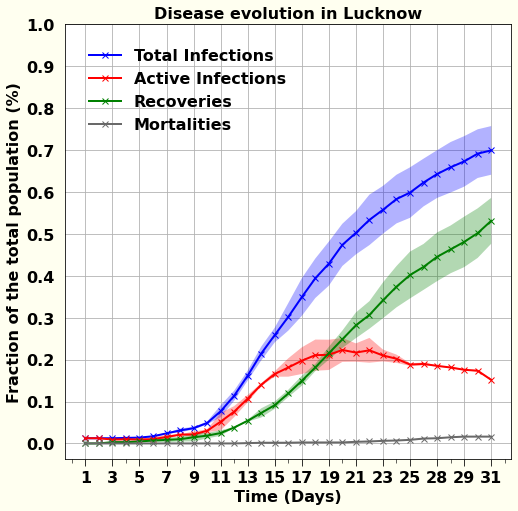

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

s = 96

t=96*31

x = (np.arange(0,t,step=s)/96)+1

cinf_mean = ((FinalTimeSeries[0]/Population)*100).cpu().detach().numpy()
cinf_std = ((FinalTimeSeries[8]/Population)*100).cpu().detach().numpy()

ainf_mean = ((FinalTimeSeries[2]/Population)*100).cpu().detach().numpy()
ainf_std = ((FinalTimeSeries[10]/Population)*100).cpu().detach().numpy()

recovered_mean = ((FinalTimeSeries[3]/Population)*100).cpu().detach().numpy()
recovered_std = ((FinalTimeSeries[11]/Population)*100).cpu().detach().numpy()

deceased_mean = ((FinalTimeSeries[4]/Population)*100).cpu().detach().numpy()
deceased_std = ((FinalTimeSeries[12]/Population)*100).cpu().detach().numpy() 
# cinf_mean = (m[0]/Population)*100
# cinf_std = (m[8]/Population)*100

# ainf_mean = (m[2]/Population)*100
# ainf_std = (m[10]/Population)*100

rinf_mean = recovered_mean
rinf_std = recovered_std

dinf_mean = deceased_mean
dinf_std = deceased_std
data = np.array([0.012,0.012,0.012,0.012,0.013,0.013,0.013,0.014,0.014,0.014,0.015,
                 0.015,0.017,0.018,0.019,0.019,0.021,0.022,0.023,0.023,0.024,0.025,
                 0.026,0.027,0.028,0.030,0.031,0.032,0.033,0.034,0.035])

plt.plot(x,cinf_mean[np.arange(0,t,step=s)],'x-',color='blue',linewidth=2,linestyle='-')
ax.fill_between(x, np.clip(cinf_mean[np.arange(0,t,step=s)]-cinf_std[np.arange(0,t,step=s)],0,np.inf), np.clip(cinf_mean[np.arange(0,t,step=s)]+cinf_std[np.arange(0,t,step=s)],0,np.inf) ,alpha=0.3, facecolor='blue')

plt.plot(x,ainf_mean[np.arange(0,t,step=s)],'x-',color='r',linewidth=2,linestyle='-')
ax.fill_between(x, np.clip(ainf_mean[np.arange(0,t,step=s)]-ainf_std[np.arange(0,t,step=s)],0,np.inf), np.clip(ainf_mean[np.arange(0,t,step=s)]+ainf_std[np.arange(0,t,step=s)],0,np.inf) ,alpha=0.3, facecolor='r')

plt.plot(x,rinf_mean[np.arange(0,t,step=s)],'x-',color='g',linewidth=2,linestyle='-')
ax.fill_between(x, np.clip(rinf_mean[np.arange(0,t,step=s)]-rinf_std[np.arange(0,t,step=s)],0,np.inf), np.clip(rinf_mean[np.arange(0,t,step=s)]+rinf_std[np.arange(0,t,step=s)],0,np.inf) ,alpha=0.3, facecolor='g')

plt.plot(x,dinf_mean[np.arange(0,t,step=s)],'x-',color='dimgray',linewidth=2,linestyle='-')
ax.fill_between(x, np.clip(dinf_mean[np.arange(0,t,step=s)]-dinf_std[np.arange(0,t,step=s)],0,np.inf), np.clip(dinf_mean[np.arange(0,t,step=s)]+dinf_std[np.arange(0,t,step=s)],0,np.inf) ,alpha=0.3, facecolor='dimgray')

#plt.plot(np.arange(1,32,step=1),data,'o-',color='black',linewidth=2)

plt.rcParams['figure.facecolor'] = 'ivory'

plt.rcParams["font.weight"] = "bold"

plt.rcParams["axes.labelweight"] = "bold"

ax.grid()

ax.set_axisbelow(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(16))
ax.tick_params(which='major', length=7, color='black')
ax.tick_params(which='minor', length=4, color='black' )
ax.xaxis.set_minor_locator(plt.MaxNLocator())

ax.tick_params(which='both', # Options for both major and minor ticks
               top=False, # turn off top ticks
               left=False, # turn off left ticks
               right=False,  # turn off right ticks
               bottom=True) # turn off bottom ticks
ax.set_xticks(np.arange(1,32,step=2))
ax.set_xticklabels(["1","3","5","7","9","11","13","15","17","19","21","23","25",
                    "28","29","31"])

plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(np.arange(0,1.1,step=0.1),fontsize=16,fontweight='bold')

plt.xlabel('Time (Days)',fontsize=16,fontweight='bold')

plt.ylabel('Fraction of the total population (%)',fontsize=16,fontweight='bold')

plt.legend(['Total Infections','Active Infections','Recoveries','Mortalities'], #'Data'
           fontsize=16,loc="upper left",fancybox=True, 
           framealpha=0.0, shadow=False, borderpad=1)

plt.title('Disease evolution in Lucknow',fontsize=16,fontweight='bold')

plt.savefig('FL_2.pdf',format='pdf', bbox_inches='tight',Transparent=True)

files.download('FL_2.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

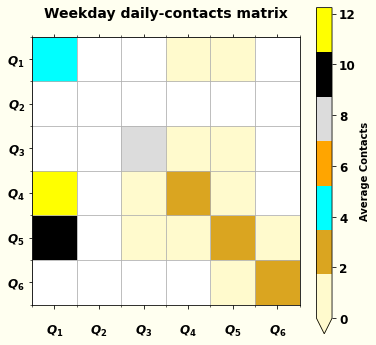

In [ ]:
fig,ax = plt.subplots(figsize=(6, 6))

data1 = InteractionsFinal[0].cpu().detach().numpy()

data1 = np.ma.masked_where(data1 == 0, data1)

data2 = InteractionsFinal[0].cpu().detach().numpy()

data1[0,0] = 5.2

data2[0,0] = 5.2

data1 = np.ma.masked_where(data1 == 0, data1)

alpha = ['$Q_{1}$','$Q_{2}$','$Q_{3}$','$Q_{4}$','$Q_{5}$','$Q_{6}$']

vmin = np.min(np.array([data1,data2]))

vmax = np.max(np.array([data1,data2]))

alpha = ['$Q_{1}$','$Q_{2}$','$Q_{3}$','$Q_{4}$','$Q_{5}$','$Q_{6}$']

cmap = ListedColormap(["lemonchiffon","goldenrod","cyan","orange","gainsboro", "black","yellow"])

cax = ax.matshow(data1,interpolation='nearest',cmap=cmap, rasterized=True, vmin=vmin, vmax=vmax)

cbar=fig.colorbar(cax,extend='min', label='Average Contacts')

plt.gca().set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')

plt.gca().set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')

plt.grid(which='minor')

cmap.set_bad(color='white')

ax.set_xticklabels(['']+alpha,y=-0.15,fontsize=12)

ax.set_yticklabels(['']+alpha,fontsize=12)

cbar.ax.tick_params(labelsize=12)

plt.title('Weekday daily-contacts matrix',fontweight='bold',fontsize=14)

plt.savefig('IFL_2.pdf',format='pdf', bbox_inches='tight',Transparent=True)

files.download('IFL_2.pdf')

In [ ]:
!pip install hickle
import hickle as hk
from google.colab import files
hk.dump(FinalTimeSeries.cpu().detach().numpy(),'TS_FL_2.hkl', mode='w')
hk.dump(FinalConstants.cpu().detach().numpy(),'C_FL_2.hkl', mode='w')
hk.dump(InteractionsFinal.cpu().detach().numpy(),'I_FL_2.hkl', mode='w')
files.download('TS_FL_2.hkl')
files.download('C_FL_2.hkl')
files.download('I_FL_2.hkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Unlock Phase 3

In [ ]:
%reset -f
!pip install faiss-gpu
!pip install celluloid
import faiss
import numpy as np
from scipy.stats import norm
import time
import torch
from google.colab import files
import random
from sklearn.neighbors import NearestNeighbors
device = 'cuda'
res = faiss.StandardGpuResources()
select = 0
MonteCarlo = 2
Residence = torch.tensor(np.loadtxt('lucknow_agent_location.dat'),dtype=torch.double,device='cuda')
Age = torch.tensor(np.loadtxt('lucknow_Age.dat'),dtype=torch.long,device='cuda')
H_Size = torch.tensor(np.loadtxt('lucknow_Age_House.dat'),dtype=torch.long,device='cuda')
H_Size[H_Size==0] = 1
H_Number = torch.tensor(np.loadtxt('lucknow_House_number.dat'),dtype=torch.long,device='cuda')
H_location = torch.tensor(np.loadtxt('lucknow_household_location.dat'),dtype=torch.long,device='cuda')
# Total Population
Population = 64560
# Number of Children (0), Adults (1), Seniors (2) and Infections (3)
Demography = torch.tensor([round(0.2516*Population),
                           round(0.6835*Population),
                           0,
                           0,
                           8],dtype=torch.long,device='cuda')
Demography[2] = Population-torch.sum(Demography[:2]) 
Demography[3] = 20
# Layout Size: XMinimum (0), XMaximum (1), YMinimum (2), YMaximum (3), Grid Resolution (4)
Layout = torch.tensor([0,5000,0,2000,1000],dtype=torch.double,device='cuda')
# Minimum (0), Maximum (1), Inner (2), Innermost (3) Allowed Speeds
VelocityParameters = torch.tensor([-500,500,200,10,1],dtype=torch.long,device='cuda')
# Collision Radius (0), Infection Radius (1), OuterCircle (2), InnerCircle (3), Reached Goal (4)
Radii = torch.tensor([5,2,570,120,5],dtype=torch.long,device='cuda') # Infection Radius(20) > Collision Radius(5/50) --> no social distancing
# Total time (days), Resolution(minutes)
Time = torch.tensor([31,15],dtype=torch.long, device='cuda') 
# TimeSteps in a day (1 step = 15mins) and total
TimeStepsDay = torch.div(24*60,Time[1].item())
# Total time steps in 31 days
TimeStepsTotal = TimeStepsDay*Time[0].long()
# Re-assign x and y initial positions
# Assign positions within unit radius
adjustment = 0.5
Residence = H_location[H_Number] + torch.DoubleTensor(Population,2).uniform_(-adjustment,adjustment).cuda()
# Check if the newly assigned x co-ordinate is within the boundary
Residence[Residence[:,0]>Layout[1],0] = (torch.DoubleTensor(Population).uniform_(Layout[1]-adjustment,Layout[1]).cuda())[Residence[:,0]>Layout[1]]
Residence[Residence[:,0]<Layout[0],0] = (torch.DoubleTensor(Population).uniform_(Layout[0],Layout[0]+adjustment).cuda())[Residence[:,0]<Layout[0]]
# Check if the newly assigned y co-ordinate is within the boundary
Residence[Residence[:,1]>Layout[3],1] = (torch.DoubleTensor(Population).uniform_(Layout[3]-adjustment,Layout[3]).cuda())[Residence[:,1]>Layout[3]]
Residence[Residence[:,1]<Layout[2],1] = (torch.DoubleTensor(Population).uniform_(Layout[2],Layout[2]+adjustment).cuda())[Residence[:,1]<Layout[2]]
Activities = np.zeros((20,96),dtype=np.float32)
# Children
# Errands 
Activities[0,24:36]=0.005*norm.pdf(np.arange(6,9,step=0.25), 7.5, 1) # 6-9
Activities[0,36:56]=0.01*norm.pdf(np.arange(9,14,step=0.25), 11.5, 1) # 9-14
Activities[0,56:72]=0.025*norm.pdf(np.arange(14,18,step=0.25), 17, 1) # 14-21
# Adults
# Errands 
Activities[8,24:36]=0.025*norm.pdf(np.arange(6,9,step=0.25), 7.5, 1) # 6-9
Activities[8,36:56]=0.05*norm.pdf(np.arange(9,14,step=0.25), 11.5, 1) # 9-14
Activities[8,56:72]=0.075*norm.pdf(np.arange(14,18,step=0.25), 17, 1) # 14-21
# Nomadic
Activities[12,24:48] = 0.1*norm.pdf(np.arange(6,12,step=0.25), 10, 1) # 6-12
Activities[12,48:72] = 0.25*norm.pdf(np.arange(12,18,step=0.25), 16, 1) # 12-21
# Nomads go home (18) # Weekday
Activities[18,0:24] = np.ones(24)
Activities[18,84:96] = np.ones(12)
# Nomads go home (19) # Weekend
Activities[19,0:96] = np.ones(96)
# Children
# Market
Activities[1,24:48]=0.01*norm.pdf(np.arange(6,12,step=0.25), 10, 1) # 6-12
Activities[1,48:72]=0.02*norm.pdf(np.arange(12,18,step=0.25), 16, 1) # 12-21
# Adults
# Market
Activities[9,24:48]=0.015*norm.pdf(np.arange(6,12,step=0.25), 10, 1) # 6-12
Activities[9,48:72]=0.03*norm.pdf(np.arange(12,18,step=0.25), 17, 1) # 12-21
# Office 
Activities[10,24:48]= 2*norm.pdf(np.arange(6,12,step=0.25), 9, 1) # 6-12
Activities[11,48:72] = 2*norm.pdf(np.arange(12,18,step=0.25), 16, 1) # 12-21
# School
Activities[2,24:40]=2*norm.pdf(np.arange(6,10,step=0.25), 8, 1) # 6-10
# Go home from school:
Activities[3,60:72]=2*norm.pdf(np.arange(15,18,step=0.25), 16.5, 1) # 3-6
# Weekday Activities
Limits = torch.tensor([0,0,0,0,0,0,1,100,1,100,0,0,
                       0,0,5,100,0,0,1,100,1,100,0,0,
                       0,0,0,0,9,100,2,100,2,100,0,0,
                       5,100,1,100,2,100,1,100,3,100,0,0,
                       8,100,1,100,4,100,1,100,1,100,1,100,
                       0,0,0,0,0,0,0,0,1,100,1,100],dtype=torch.long,device='cuda')


# Weekend Activities                    
Limits_Weekend = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0,
                               0,0,0,0,0,0,0,0,0,0,0,0],dtype=torch.long,device='cuda')
Location_one = torch.tensor([12,13,14,15,16,17],dtype=torch.long,device='cuda') # Location of i
Location_two = torch.tensor([[12,0,0,15,16,0],
                             [0,13,0,15,16,0], 
                             [0,0,14,15,16,0],
                             [12,13,14,15,16,0],
                             [12,13,14,15,16,17],
                             [0,0,0,0,16,17]],dtype=torch.long,device='cuda') # Corresponding locations of j   
def goal_assign(x,y,minbias,maxbias,xhalfmark,yhalfmark):
  '''
  Generate Random Goals
  '''
  # ordinate
  l = torch.zeros((Population),dtype=torch.double,device='cuda')
  # abscissa
  m = torch.zeros((Population),dtype=torch.double,device='cuda')
  temp = x -  torch.FloatTensor(Population).uniform_(minbias,maxbias).cuda()
  l[x>xhalfmark] = temp[x>xhalfmark] 
  temp = y -  torch.FloatTensor(Population).uniform_(minbias,maxbias).cuda()
  m[y>yhalfmark] = temp[y>yhalfmark] 
  temp = x +  torch.FloatTensor(Population).uniform_(minbias,maxbias).cuda()
  l[x<xhalfmark] = temp[x<xhalfmark] 
  temp = y +  torch.FloatTensor(Population).uniform_(minbias,maxbias).cuda()
  m[y<yhalfmark] = temp[y<yhalfmark] 
  return l,m   

def generateMatrix(agents,matrixone,limits,Population, H_Number, index,con_one, con_two,Time_Daily,matrixthree,distance,radius):
  '''
  Generate a conditional contact matrix
  '''
  # Store end result
  matrixtwo = torch.zeros((2,Population,20),dtype=torch.double,device='cuda')
  count=0
  for i in range(6):
    vec_con1 = torch.zeros((Population),device='cuda',dtype=torch.bool)
    vec_con1 += (agents==con_one[i])
    Time_Daily[vec_con1==True,i]+=1
    for j in range(6):
      temp = torch.zeros((Population,20),device='cuda',dtype=torch.int32)
      vec_con2 = torch.zeros((Population,20),device='cuda',dtype=torch.bool)      
      if (con_two[i][j]!=0):
        if (count==0):          
          vec_con2 = torch.logical_and(H_Number[index]==H_Number[:,None],(agents[index]==con_two[i][j]))
        else:
          vec_con2 = (agents[index]==con_two[i][j])
        temp = vec_con1[:,None]*vec_con2
        #matrixone[:,count] += torch.sum(temp,1)
        matrixone[:,count] += torch.sum(torch.logical_and(temp,distance<radius),1)
        if (count!=0):
          matrixone[matrixone[:,count]>limits[:,count],count] = limits[matrixone[:,count]>limits[:,count],count]
        #tempone = temp*(1-(torch.cumsum(torch.logical_and(temp,distance<radius),axis=1)>matrixone[:,count][:,None]).long())
        tempone = temp*(1-(torch.cumsum(temp,axis=1)>matrixone[:,count][:,None]).long())
        matrixtwo[0] += tempone
        matrixtwo[1] = temp
        if (torch.where(vec_con1==True)[0].size(0)!=0):
          matrixthree[i,j] += torch.where(tempone==1)[0].size(0)/torch.where(vec_con1==True)[0].size(0)
      count+=1
  return matrixtwo[0],matrixtwo[1], matrixone, matrixthree, Time_Daily

def nearest_destination(Population,centroids,Residence): 
  '''
  Find the nearest destination: Office/School/Market
  '''
  distance = torch.zeros((Population,len(centroids)),device='cuda',dtype=torch.double)
  for i in range(len(centroids)):
    # Check the distance from the centroid of the zone to each household location
    distance[:,i] = torch.linalg.norm(Residence-Centroids[i],axis=1)
  return torch.argmin(distance,axis=1)

# Schools
# Co-ordinates of different schools
School=torch.tensor([[1500,2000,200,500],
                     [2000,2500,1000,1500],
                     [600,1000,1100,1500],
                     [3900,4500,500,700]],dtype=torch.long,device='cuda')
# Generate Destinations in different school zones
School_Positions = torch.zeros((Population,8),dtype=torch.double,device='cuda')
# x-co-ordinate
School_Positions[:,0] = torch.DoubleTensor(Population).uniform_(School[0,0],School[0,1])
School_Positions[:,2] = torch.DoubleTensor(Population).uniform_(School[1,0],School[1,1])
School_Positions[:,4] = torch.DoubleTensor(Population).uniform_(School[2,0],School[2,1])
School_Positions[:,6] = torch.DoubleTensor(Population).uniform_(School[3,0],School[3,1])
# y-co-ordinate
School_Positions[:,1] = torch.DoubleTensor(Population).uniform_(School[0,2],School[0,3])
School_Positions[:,3] = torch.DoubleTensor(Population).uniform_(School[1,2],School[1,3])
School_Positions[:,5] = torch.DoubleTensor(Population).uniform_(School[2,2],School[2,3])
School_Positions[:,7] = torch.DoubleTensor(Population).uniform_(School[3,2],School[3,3])

# Offices
# Co-ordinates of different offices
Office = torch.tensor([[0,500,500,1000],
                      [4000,4500,1000,1500],
                      [2000,3000,500,1000]],dtype=torch.long,device='cuda')
# Generate destinations in office zones
Office_Positions = torch.zeros((Population,6),dtype=torch.double,device='cuda')
# x co-ordinate
Office_Positions[:,0] = torch.DoubleTensor(Population).uniform_(Office[0,0],Office[0,1])
Office_Positions[:,2] = torch.DoubleTensor(Population).uniform_(Office[1,0],Office[1,1])
Office_Positions[:,4] = torch.DoubleTensor(Population).uniform_(Office[2,0],Office[2,1])
# y co-ordinate
Office_Positions[:,1] = torch.DoubleTensor(Population).uniform_(Office[0,2],Office[0,3])
Office_Positions[:,3] = torch.DoubleTensor(Population).uniform_(Office[1,2],Office[1,3])
Office_Positions[:,5] = torch.DoubleTensor(Population).uniform_(Office[2,2],Office[2,3])

# Markets
# Co-ordinates of different markets
Market = torch.tensor([[3000,3500,1500,2000],
                       [4600,5000,700,900],
                       [900,1500,600,1000],
                       [0,400,1000,1300],
                       [1000,1500,1500,2000]],dtype=torch.long,device='cuda')
# Generate destinations in market zones
Market_Positions = torch.zeros((Population,10),dtype=torch.double,device='cuda')
# x co-ordinate
Market_Positions[:,0] = torch.DoubleTensor(Population).uniform_(Market[0,0],Market[0,1])
Market_Positions[:,2] = torch.DoubleTensor(Population).uniform_(Market[1,0],Market[1,1])
Market_Positions[:,4] = torch.DoubleTensor(Population).uniform_(Market[2,0],Market[2,1])
Market_Positions[:,6] = torch.DoubleTensor(Population).uniform_(Market[3,0],Market[3,1])
Market_Positions[:,8] = torch.DoubleTensor(Population).uniform_(Market[4,0],Market[4,1])
# y co-ordinate
Market_Positions[:,1] = torch.DoubleTensor(Population).uniform_(Market[0,2],Market[0,3])
Market_Positions[:,3] = torch.DoubleTensor(Population).uniform_(Market[1,2],Market[1,3])
Market_Positions[:,5] = torch.DoubleTensor(Population).uniform_(Market[2,2],Market[2,3])
Market_Positions[:,7] = torch.DoubleTensor(Population).uniform_(Market[3,2],Market[3,3])
Market_Positions[:,9] = torch.DoubleTensor(Population).uniform_(Market[4,2],Market[4,3])

# Centroids of each zone
Centroids = torch.zeros((12,2),dtype=torch.double,device='cuda')
# Centroids of school zones
Centroids[:4,0] = School[:,0] + 0.5*School[:,1]
Centroids[:4,1] = School[:,2] + 0.5*School[:,3]
# Centroids of office zones
Centroids[4:7,0] = Office[:,0] + 0.5*Office[:,1]
Centroids[4:7,1] = Office[:,2] + 0.5*Office[:,3]
# Centroids of market zones
Centroids[7:12,0] = Market[:,0] + 0.5*Market[:,1]
Centroids[7:12,1] = Market[:,2] + 0.5*Market[:,3]

# Find nearest destination
Nearest = torch.zeros((Population,3),device='cuda',dtype=torch.long)
# Nearest school
Nearest[:,0] = nearest_destination(Population,Centroids[:4],Residence)
# Nearest office
Nearest[:,1] = nearest_destination(Population,Centroids[4:7],Residence)
# Nearest market
Nearest[:,2] = nearest_destination(Population,Centroids[7:12],Residence)
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Disease Transmission Parameters
# -------------------------------------

# States: SIT/SIN/AIT/AIN/SUT/SUN
States = torch.tensor(([0,0,0,0,0,1,2,3],
                       [0,0,0,1,0,0,0,0],
                       [6,7,6,7,0,0,0,0],
                       [9,9,9,9,0,0,0,0],
                       [0,0,0,0,0,0,0,0],
                       [0,1,2,3,4,5,6,7]),dtype=torch.int,device='cuda')
# Disease Transition Probabilities
Transition = torch.zeros((3,6,8),dtype=torch.double,device='cuda')
undercount = 0
# Children 
Transition[0] = torch.transpose(torch.tensor(([0,0,0.12495,0.00005,0,0.875],
                                              [0,0,0.09994,0.00006,undercount,0.9-undercount],
                                              [0,0.00998,0.19,0.00002,0,0.8],
                                              [0,0.02996,0.12,0.00004,undercount,0.85-undercount],
                                              [0.2537,0,0,0,0,0.7463],
                                              [0.2537,0,0,0,0,0.7463],
                                              [0.2537,0,0,0,0,0.7463],
                                              [0.2537,0,0,0,0,0.7463]),dtype=torch.double,device='cuda'),0,1) 
# Adults
Transition[1] = torch.transpose(torch.tensor(([0,0,0.124,0.001,0,0.875],
                                              [0,0,0.06,0.04,undercount,0.9-undercount],
                                              [0,0.03993,0.16,0.00007,0,0.8],
                                              [0,0.0493,0.1,0.0007,undercount,0.85-undercount],
                                              [0.5,0,0,0,0,0.5],
                                              [0.5,0,0,0,0,0.5],
                                              [0.5,0,0,0,0,0.5],
                                              [0.5,0,0,0,0,0.5]),dtype=torch.double,device='cuda'),0,1) 
# Seniors
Transition[2] = torch.transpose(torch.tensor(([0,0,0.065,0.06,0,0.875],
                                              [0,0,0.02,0.08,undercount,0.9-undercount],
                                              [0,0.08,0.1,0.02,0,0.8],
                                              [0,0.1,0.01,0.04,undercount,0.85-undercount],
                                              [0.5951,0,0,0,0,0.4049],
                                              [0.5951,0,0,0,0,0.4049],
                                              [0.5951,0,0,0,0,0.4049],
                                              [0.5951,0,0,0,0,0.4049]),dtype=torch.double,device='cuda'),0,1)
# Storage Parameters
# Outermost Loop (Scenario/Final Parameters)
# Disease Transmission: S/IT/INT/R/D/Total (7+7, Mean and Variance states) 
FinalTimeSeries = torch.zeros((65,(TimeStepsTotal.long().item())+1), dtype=torch.float,device='cuda')
# Time to infection, death, recovery (Mean - 0,1,2, Variance - 3,4,5)
FinalConstants = torch.zeros((20), dtype=torch.float,device='cuda')
InteractionsFinal = torch.zeros((2,6,6),dtype=torch.float,device='cuda')
# Outermost loop
# Second Loop (MonteCarlo Run Parameters)
# ResultsTimeSeries (Time Series for MC runs)(0-6)
ResultsTMC = torch.zeros((MonteCarlo,29,(TimeStepsTotal.long().item())+1), dtype=torch.float,device='cuda')
# Results Constants: Time to Infection: Overall(0), Recovery(1), Death(2)
ResultsCMC = torch.zeros((MonteCarlo,10,1), dtype=torch.float,device='cuda')
InteractionsMC = torch.zeros((MonteCarlo,2,6,6), dtype=torch.float,device='cuda') 
for mc in range(MonteCarlo): 
  # Create N agents;
  # Age = 0,     
  # x_position = 1, 
  # y_position = 2, 
  # x_velocity = 3, 
  # y_velocity = 4, 
  # occupation = 5,
  # current_task = 7, 
  # status_of_task = 8, 
  # goal_x = 9, 
  # goal_y = 10,
  # infection_status = 14, 
  # infection_state = 15, 
  # time_of_infectiousness = 16
  Agents = torch.zeros((Population,20),dtype=torch.double,device='cuda')
  # Assign Age 
  Agents[:,0] = Age
  # Indices of Children
  Children = torch.where(Agents[:,0]==0)[0]
  # Indices of Adults
  Adults = torch.where(Agents[:,0]==1)[0]
  # Indices of Seniors
  Seniors = torch.where(Agents[:,0]==2)[0]
  # Assign x and y Positions
  # PositionX (1)
  Agents[:,1] = Residence[:,0].detach().clone()
  # PositionY (2)
  Agents[:,2] = Residence[:,1].detach().clone()
  # Assign x and y Velocity Components
  # VelocityX (3)
  Agents[:,3] = torch.DoubleTensor(Population).uniform_(VelocityParameters[0],VelocityParameters[1])
  # VelocityY (4)
  Agents[:,4] = torch.DoubleTensor(Population).uniform_(VelocityParameters[0],VelocityParameters[1])
  # Social Distance:  
  SD = Radii[0]*torch.ones((Population),dtype=torch.long,device='cuda')
  # Fraction not following (0: Everyone, 1: No one)
  SD[torch.tensor([True,False],device='cuda')[torch.multinomial(torch.tensor([0.9,0.1]),Population,replacement=True)]] = 0
  # Occupation (5): 
  # School-going Children (1)
  Agents[Children[:int(0.75*Demography[0])],5] = 1
  # School-going Adults (1)
  Agents[Adults[:int(0.05*Demography[1])],5] = 1
  # School-going Seniors (1)
  Agents[Seniors[:int(0.02*Demography[2])],5] = 1
  # Stay-at-home adults (2)
  Agents[Adults[int(0.05*Demography[1]):int(0.25*Demography[1])],5] = 2
  # Office Going Adults (3)
  Agents[Adults[int(0.25*Demography[1]):int(0.85*Demography[1])],5] = 3
  # Nomadic Adults (4)
  Agents[Adults[int(0.85*Demography[1]):Demography[1]],5] = 4
  # Stay-at-home Seniors (5)
  Agents[Seniors[int(0.02*Demography[2]):int(0.62*Demography[2])],5] = 5 
  # Office Going Seniors (6)
  Agents[Seniors[int(0.62*Demography[2]):int(0.95*Demography[2])],5] = 6
  # Nomadic Seniors (7)
  Agents[Seniors[int(0.95*Demography[2]):Demography[2]],5] = 7
  # Assign Infection Status: Infected and Tested (1), Uninfect(0), Infected and Not Tested (3)
  # 0.5% infections among children, 49% infections among adults, 50.5% among seniors
  Agents[Children[:int(0.005*Demography[3])],14] = 3 # Infected 
  Agents[Adults[int(0.005*Demography[3]):int(0.49*Demography[3])],14] = 3 # Infected 
  Agents[Seniors[int(0.49*Demography[3]):Demography[3]],14] = 3 # Infected 
  Agents[torch.where(Agents[:,14]==3)[0][:int(Demography[4])],14] = 1 # Confirmed Infections
  # Assign Infection State: SIT=0, SIN=1, AIT=2, AIN=3, SUT=4, SUN=5, AUT=6, AUN=7
  # Infected
  # 80% of the infections are asymptomatic
  # 20% of the infections are symptomatic
  Agents[torch.where(Agents[:,14]==3)[0][:int(0.8*Demography[3])],15] = 3 # AIN
  Agents[torch.where(Agents[:,14]==3)[0][int(0.8*Demography[3]):Demography[3]],15] = 1 # SIN
  # Uninfected
  # 85% of the uninfected are asymptomatic
  # 15% of the uninfected are symptomatic
  Agents[torch.where(Agents[:,14]==0)[0][:int(0.85*(Population-Demography[3]))],15] = 7 # AUN
  Agents[torch.where(Agents[:,14]==0)[0][int(0.85*(Population-Demography[3])):Population-Demography[3]],15] = 5 # SUN
  Agents[torch.where(Agents[:,14]==1)[0],15] = 2
  # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  # Placeholder Variables
  # -------------------------------------

  # Vectors 
  Vectors = torch.zeros((12,Population),device='cuda',dtype=torch.double)
  # Distance Matrix(0), Index Matrix(1), Condition Matrix(2)
  Matrixs = torch.zeros((5,Population,20),dtype=torch.double,device='cuda')
  # Initial Position 
  CurrentPosition = torch.dstack((Agents[:,1],Agents[:,2]))
  # Initial Velocity
  Velocity = torch.dstack((Agents[:,3],Agents[:,4]))
  # All agents are initially at home (12)
  Agents[:,7] = 12
  # Status of the task is complete and initially at home (12)
  Agents[:,8] = Agents[:,7].detach().clone()
  # Ordinate of goal position
  Agents[:,9] = Agents[:,1].detach().clone()
  # Abscissa of goal position
  Agents[:,10] = Agents[:,2].detach().clone()
  # Initial Goals are to remain at home
  Destination = torch.dstack((Agents[:,1],Agents[:,2]))
  # Days 
  Days = torch.tensor([0],device='cuda')       
  # Distance
  Distance = torch.zeros((Population),dtype=torch.double,device='cuda')
  # Infection Status over Time
  # Overall
  Results = torch.tensor([torch.where(Agents[:,14]==0)[0].size()[0], #0:Uninfected
                          torch.where(Agents[:,14]==1)[0].size()[0], #1:Infected and Tested
                          torch.where(Agents[:,14]==2)[0].size()[0], #2:Unreported Recoveries
                          torch.where(Agents[:,14]==3)[0].size()[0], #3:Infected and Not Tested
                          torch.where(Agents[:,14]==4)[0].size()[0], #4:Unreported Deaths
                          torch.where(Agents[:,14]==5)[0].size()[0], #5:Reported Recoveries
                          torch.where(Agents[:,14]==6)[0].size()[0]],dtype=torch.long,device='cuda') #6:Reported Deaths  
  # Children
  ResultsC = torch.tensor([torch.where(Agents[Children,14]==0)[0].size()[0],
                          torch.where(Agents[Children,14]==1)[0].size()[0],
                          torch.where(Agents[Children,14]==2)[0].size()[0],
                          torch.where(Agents[Children,14]==3)[0].size()[0],
                          torch.where(Agents[Children,14]==4)[0].size()[0],
                          torch.where(Agents[Children,14]==5)[0].size()[0],
                          torch.where(Agents[Children,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')   
  # Adults  
  ResultsA = torch.tensor([torch.where(Agents[Adults,14]==0)[0].size()[0],
                          torch.where(Agents[Adults,14]==1)[0].size()[0],
                          torch.where(Agents[Adults,14]==2)[0].size()[0],
                          torch.where(Agents[Adults,14]==3)[0].size()[0],
                          torch.where(Agents[Adults,14]==4)[0].size()[0],
                          torch.where(Agents[Adults,14]==5)[0].size()[0],
                          torch.where(Agents[Adults,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')   
  # Seniors
  ResultsS = torch.tensor([torch.where(Agents[Seniors,14]==0)[0].size()[0],
                          torch.where(Agents[Seniors,14]==1)[0].size()[0],
                          torch.where(Agents[Seniors,14]==2)[0].size()[0],
                          torch.where(Agents[Seniors,14]==3)[0].size()[0],
                          torch.where(Agents[Seniors,14]==4)[0].size()[0],
                          torch.where(Agents[Seniors,14]==5)[0].size()[0],
                          torch.where(Agents[Seniors,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')   

  # Interactions: Weekday=0, Weekend=1, Contact_Matrix=2
  Interactions = torch.zeros((3,6,6),dtype=torch.double,device='cuda')
  # Weekday = 0, Weekend = 1
  Time_avg = torch.zeros((2,6),dtype=torch.double,device='cuda')
  Time_Daily = torch.zeros((Population,6),dtype=torch.long,device='cuda')
  # Number of contacts on a day to day basis: Daily_Contact=0, Contact_Limit=1
  Contacts = torch.zeros((2,Population,36),dtype=torch.long,device='cuda')
  StatusTime = Agents[:,8].detach().clone()
  for t in range(TimeStepsTotal.long().item()):

    Days = torch.floor(torch.div(t,TimeStepsDay).cuda())
    # Time of the day
    time_of_day = t%96 
    # Day of the week
    day_of_week = Days%7 

    # ------------------------------------------------
    # Store parameters from the previous run
    # ------------------------------------------------

    # Infection Status from previous iteration
    Vectors[4] = Agents[:,14].detach().clone()
    # Infection State from previous iteration
    Vectors[5] = Agents[:,15].detach().clone()
    # Rtime
    Vectors[6] = Vectors[1].detach().clone()

    # ---------------------------------------------
    # Find Limits for the day
    # ---------------------------------------------

    if time_of_day==0:
      # Assign contact limits for the weekend
      if torch.logical_or(day_of_week==5,day_of_week==6):
        for i in range(1,36):
            Contacts[1][:,i] = Limits_Weekend[2*i+1]
      else:
        # Assign contact limits for the weekday
        for i in range(1,36):
            Contacts[1][:,i] =  Limits[2*i+1]

    #Agents[:,15]: SIT=0, SIN=1, AIT=2, AIN=3, SUT=4, SUN=5, AUT=6, AUN=7
    #Unconfirmed to Confirmed (30 times underreported)
    Vectors[0] = torch.rand(Population,device='cuda').double()< 0.0000103#0.00000220627 #0.0000450422
    Vectors[7] = torch.logical_and(Agents[:,15]==1,Vectors[0]==True)
    Agents[Vectors[7].bool(),15] = 0 # SIN --> SIT
    Vectors[7] = torch.logical_and(Agents[:,15]==3,Vectors[0]==True)
    Agents[Vectors[7].bool(),15] = 2 # AIN --> AIT
    # Confirmed Cases
    # Infected and Tested
    Agents[:,14][torch.logical_or(Agents[:,15]==0,Agents[:,15]==2)] = 1
    # Unconfirmed
    Agents[:,14][torch.logical_or(Agents[:,15]==1,Agents[:,15]==3)] = 3  

    # ---------------------------------------------
    # State Transition of Infected Agents
    # ---------------------------------------------

    # Find all agents who have been infected for more than a day
    Vectors[8] = torch.logical_and(torch.logical_and(torch.logical_or(Vectors[4]==1,Vectors[4]==3),Agents[:,16]%TimeStepsDay==0),Agents[:,16]>0)
    #Vectors[8] = torch.logical_or(Vectors[4]==1,Vectors[4]==3)
    # SIT=0: Is the person in state 0 a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==0),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,0][torch.multinomial(Transition[0][:,0],Population,replacement=True)][Vectors[7].bool()].double()
    # SIT=0: Is the person in state 0 an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==0),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,0][torch.multinomial(Transition[1][:,0],Population,replacement=True)][Vectors[7].bool()].double()
    # SIT=0: Is the person in state 0 a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==0),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,0][torch.multinomial(Transition[2][:,0],Population,replacement=True)][Vectors[7].bool()].double()  
    # SIN=1: Is the person in state 1 a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==1),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,1][torch.multinomial(Transition[0][:,1],Population,replacement=True)][Vectors[7].bool()].double()
    # SIN=1: Is the person in state 1 an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==1),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,1][torch.multinomial(Transition[1][:,1],Population,replacement=True)][Vectors[7].bool()].double()
    # SIN=1: Is the person in state 1 a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==1),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,1][torch.multinomial(Transition[2][:,1],Population,replacement=True)][Vectors[7].bool()].double()
    # AIT=2: Is the person in state 2 a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==2),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,2][torch.multinomial(Transition[0][:,2],Population,replacement=True)][Vectors[7].bool()].double()
    # AIT=2: Is the person in state 2 an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==2),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,2][torch.multinomial(Transition[1][:,2],Population,replacement=True)][Vectors[7].bool()].double()
    # AIT=2: Is the person in state 2 a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==2),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,2][torch.multinomial(Transition[2][:,2],Population,replacement=True)][Vectors[7].bool()].double()
    # AIN=3: Is the person in state 3 a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==3),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,3][torch.multinomial(Transition[0][:,3],Population,replacement=True)][Vectors[7].bool()].double()
    # AIN=3: Is the person in state 3 an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==3),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,3][torch.multinomial(Transition[1][:,3],Population,replacement=True)][Vectors[7].bool()].double()
    # AIN=3: Is the person in state 3 a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==3),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,3][torch.multinomial(Transition[2][:,3],Population,replacement=True)][Vectors[7].bool()].double()
    # Recovery
    Agents[:,14][(Vectors[4]==1) & (Agents[:,15]==6)] = 5 # Reported recoveries
    Agents[:,14][(Vectors[4]==3) & (Agents[:,15]==7)] = 2 # Unreported recoveries
    # Deaths
    Agents[:,14][(Vectors[4]==1) & (Agents[:,15]==9)] = 6 # Reported recoveries
    Agents[:,14][(Vectors[4]==3) & (Agents[:,15]==9)] = 4 # Unreported recoveries  
    # Time Since Infection
    Vectors[8] = torch.logical_or(Agents[:,14]==1,Agents[:,14]==3)
    Agents[:,16][Vectors[8].bool()] = Agents[:,16][Vectors[8].bool()]+1
    Agents[:,17][Vectors[8].bool()] = torch.round(torch.div(Agents[:,16][Vectors[8].bool()],TimeStepsDay-1)) 

    # -----------------------------------------
    # State Transition of Uninfected Agents
    # -----------------------------------------  

    # Find agents in the vicinity
    CurrentPosition_numpy = np.float32(CurrentPosition[0].cpu().detach().numpy())
    # Create a faiss array
    index_flat = faiss.IndexFlatL2(CurrentPosition_numpy.shape[1])
    gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
    gpu_index_flat.add(CurrentPosition_numpy)                  
    m, n = gpu_index_flat.search(CurrentPosition_numpy, 20)
    Matrixs[1] = torch.from_numpy(n).long()
    #Matrixs[1] = torch.reshape(q[q!=torch.arange(0,Population,step=1)[:,None]],(Population,19))
    # Distances 
    Matrixs[0] = torch.squeeze(torch.cdist(CurrentPosition[0][:,None],CurrentPosition[0][Matrixs[1].long()],p=2))
    Matrixs[0][Matrixs[1]==torch.arange(0,Population,step=1).cuda()[:,None]] = float("Inf")
    # Location Matching and Contact Number Check
    Matrixs[2],Matrixs[4],Contacts[0],Interactions[2],Time_Daily = generateMatrix(Agents[:,8],Contacts[0],Contacts[1],Population,H_Number,Matrixs[1].long(),Location_one, Location_two,Time_Daily,Interactions[2],Matrixs[0],Radii[1])

    if time_of_day==0:
      # Over weekends
      if torch.logical_or(day_of_week==5,day_of_week==6):
        Time_avg[1] += torch.mean(Time_Daily.double(),0)
        Time_Daily = torch.zeros((Population,6),dtype=torch.long,device='cuda')
        Interactions[1] += Interactions[2]/48
        Interactions[2] = torch.zeros((6,6),dtype=torch.double,device='cuda')
        Contacts[0] = torch.zeros((Population,36),dtype=torch.long,device='cuda')
      else:
      # Over weekdays
        Time_avg[0] += torch.mean(Time_Daily.double(),0)
        Time_Daily = torch.zeros((Population,6),dtype=torch.long,device='cuda')
        Interactions[0] += Interactions[2]/48
        Interactions[2] = torch.zeros((6,6),dtype=torch.double,device='cuda')
        Contacts[0] = torch.zeros((Population,36),dtype=torch.long,device='cuda')
  
    # Find agents with infections in the vicinity
    Vectors[3] = torch.sum(torch.logical_and(torch.logical_and(Matrixs[2].bool()==True,Matrixs[0]<Radii[1]),torch.logical_or(Vectors[4][Matrixs[1].long()]==1,Vectors[4][Matrixs[1].long()]==3)),1)
    # Find all uninfected agents with infections in their vicinity
    Vectors[8] = torch.logical_and(Vectors[4]==0,Vectors[3].long()>0)
    # SUT=4: Is the susceptible person a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==4),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,4][torch.multinomial(Transition[0][:,4],Population,replacement=True)][Vectors[7].bool()].double()
    # SUT=4: Is the susceptible person an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==4),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,4][torch.multinomial(Transition[1][:,4],Population,replacement=True)][Vectors[7].bool()].double()
    # SUT=4: Is the susceptible person a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==4),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,4][torch.multinomial(Transition[2][:,4],Population,replacement=True)][Vectors[7].bool()].double()
    # SUN=5: Is the susceptible person a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==5),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,5][torch.multinomial(Transition[0][:,5],Population,replacement=True)][Vectors[7].bool()].double()
    # SUN=5: Is the susceptible person an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==5),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,5][torch.multinomial(Transition[1][:,5],Population,replacement=True)][Vectors[7].bool()].double()
    # SUN=5: Is the susceptible person a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==5),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,5][torch.multinomial(Transition[2][:,5],Population,replacement=True)][Vectors[7].bool()].double()
    # AUT=6: Is the susceptible person a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==6),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,6][torch.multinomial(Transition[0][:,6],Population,replacement=True)][Vectors[7].bool()].double()
    # AUT=6: Is the susceptible person an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==6),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,6][torch.multinomial(Transition[1][:,6],Population,replacement=True)][Vectors[7].bool()].double()
    # AUT=6: Is the susceptible person a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==6),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,6][torch.multinomial(Transition[2][:,6],Population,replacement=True)][Vectors[7].bool()].double()
    # AUN=7: Is the susceptible person a child
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==7),Agents[:,0]==0)
    Agents[:,15][Vectors[7].bool()] = States[:,7][torch.multinomial(Transition[0][:,7],Population,replacement=True)][Vectors[7].bool()].double()
    # AUN=7: Is the susceptible person an adult
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==7),Agents[:,0]==1)
    Agents[:,15][Vectors[7].bool()] = States[:,7][torch.multinomial(Transition[1][:,7],Population,replacement=True)][Vectors[7].bool()].double()
    # AUN=7: Is the susceptible person a senior
    Vectors[7] = torch.logical_and(torch.logical_and(Vectors[8]==1,Vectors[5]==7),Agents[:,0]==2)
    Agents[:,15][Vectors[7].bool()] = States[:,7][torch.multinomial(Transition[2][:,7],Population,replacement=True)][Vectors[7].bool()].double() 


    # -----------------------------------------
    # Task Allocation
    # ----------------------------------------- 

    # Weekday
    if day_of_week<5:
      
      # Children
      # School going children at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==0,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going children: School (1), Random (4), Market (7), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,4,7,12],device='cuda')[torch.multinomial(torch.tensor([Activities[2,time_of_day],Activities[0,time_of_day],Activities[1,time_of_day],1-Activities[0,time_of_day]-Activities[1,time_of_day]-Activities[2,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home kids
      Vectors[8] = torch.logical_and(Agents[:,5]==0, Agents[:,8]==12)
      # Destination for children: Random (4), Market (7), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([4,7,12],device='cuda')[torch.multinomial(torch.tensor([Activities[0,time_of_day],Activities[1,time_of_day],1-Activities[0,time_of_day]-Activities[1,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids at school
      Vectors[8] = Agents[:,8]==13
      # Remain in School: Stay at school (13), Go home (0) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,13],device='cuda')[torch.multinomial(torch.tensor([Activities[3,time_of_day],1-Activities[3,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==0,Agents[:,8]==15)
      # Stay there (15), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==0,Agents[:,8]==17)
      # Stay there (17), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      
      # Adults
      # School going adults at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==1,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going adults: School (1), Random (5), Market (8), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[2,time_of_day],Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[2,time_of_day]-Activities[8,time_of_day]-Activities[9,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Office going adults
      Vectors[8] = torch.logical_and(Agents[:,5]==3, Agents[:,8]==12)
      # Destination for office going adults: Office (2), Random (5), Market (8), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([2,5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[10,time_of_day],Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[8,time_of_day]-Activities[9,time_of_day]-Activities[10,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Stay at home adults
      Vectors[8] = torch.logical_and(Agents[:,5]==2,Agents[:,8]==12)  
      # Destination for adults: Random (5), Market (8), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[8,time_of_day]-Activities[9,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic adults at home
      Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(Agents[:,5]==4,Agents[:,8]==12))
      # Adults who are nomads: Go elsewhere (10), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([10,12],device='cuda')[torch.multinomial(torch.tensor([Activities[12,time_of_day],1-Activities[12,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic adults on the move
      Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(Agents[:,5]==4,Agents[:,8]==16)) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,10,16],device='cuda')[torch.multinomial(torch.tensor([Activities[18,time_of_day],Activities[12,time_of_day],1-Activities[18,time_of_day]-Activities[12,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults at the office
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==14)  
      # Stay there (14), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,14],device='cuda')[torch.multinomial(torch.tensor([Activities[11,time_of_day],1-Activities[11,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==15)  
      # Stay there (15), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==17)  
      # Stay there (17), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      
      # Seniors
      # School going seniors at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==2,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going seniors: School (1), Random (6), Market (9), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[2,time_of_day],Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[2,time_of_day]-Activities[8,time_of_day]-Activities[9,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Office going seniors
      Vectors[8] = torch.logical_and(Agents[:,5]==6, Agents[:,8]==12)  
      # Destination for office going seniors: Office (3), Random (6), Market (9), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([3,6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[10,time_of_day],Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[8,time_of_day]-Activities[9,time_of_day]-Activities[10,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home seniors
      Vectors[8] = torch.logical_and(Agents[:,5]==5,Agents[:,8]==12)  
      # Destination for seniors: Random (6), Market (9), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[8,time_of_day],Activities[9,time_of_day],1-Activities[8,time_of_day]-Activities[9,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic Seniors at home
      Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(Agents[:,5]==7,Agents[:,8]==12))  
      # Seniors who are nomads: Go elsewhere (11), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([11,12],device='cuda')[torch.multinomial(torch.tensor([Activities[12,time_of_day],1-Activities[12,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic Seniors on the move
      Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(Agents[:,5]==7,Agents[:,8]==16))  
      # Seniors who are nomads: Go home (0), Go elsewhere (11), Stay there (16)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,11,16],device='cuda')[torch.multinomial(torch.tensor([Activities[18,time_of_day],Activities[12,time_of_day],1-Activities[12,time_of_day]-Activities[18,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Seniors at office 
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==14)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,14],device='cuda')[torch.multinomial(torch.tensor([Activities[11,time_of_day],1-Activities[11,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()  
      # Seniors running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==15)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Seniors at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==17)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()

    else:

      # Children
      # School going children
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==0,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going children: School (1), Random (4), Market (7), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,4,7,12],device='cuda')[torch.multinomial(torch.tensor([Activities[6,time_of_day],Activities[4,time_of_day],Activities[5,time_of_day],1-Activities[4,time_of_day]-Activities[5,time_of_day]-Activities[6,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home kids
      Vectors[8] = torch.logical_and(Agents[:,5]==0, Agents[:,8]==12)
      # Destination for children: Random (4), Market (7), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([4,7,12],device='cuda')[torch.multinomial(torch.tensor([Activities[4,time_of_day],Activities[5,time_of_day],1-Activities[4,time_of_day]-Activities[5,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids at school
      Vectors[8] = Agents[:,8]==13
      # Remain in School: Stay at school (13), Go home (0) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,13],device='cuda')[torch.multinomial(torch.tensor([Activities[7,time_of_day],1-Activities[7,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==0,Agents[:,8]==15)
      # Stay there (15), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Kids at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==0,Agents[:,8]==17)
      # Stay there Market (17), Go home (0)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      
      # Adults
      # School going adults at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==1,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going adults: School (1), Random (5), Market (8), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[6,time_of_day],Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[6,time_of_day]-Activities[13,time_of_day]-Activities[14,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Office going adults 
      Vectors[8] = torch.logical_and(Agents[:,5]==3, Agents[:,8]==12)  
      # Destination for office going adults: Office (2), Random (5), Market (8), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([2,5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[15,time_of_day],Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[13,time_of_day]-Activities[14,time_of_day]-Activities[15,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home adults
      Vectors[8] = torch.logical_and(Agents[:,5]==2,Agents[:,8]==12)  
      # Destination for adults: Random (5), Market (8), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([5,8,12],device='cuda')[torch.multinomial(torch.tensor([Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[13,time_of_day]-Activities[14,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic adults at home
      Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(Agents[:,5]==4,Agents[:,8]==12))
      # Adults who are nomads: Go elsewhere (10), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([10,12],device='cuda')[torch.multinomial(torch.tensor([Activities[17,time_of_day],1-Activities[17,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic adults on the move
      Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(Agents[:,5]==4,Agents[:,8]==16))
      # Adults who are nomads: Go home (0), Go elsehwere (10),Stay there (16)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,10,16],device='cuda')[torch.multinomial(torch.tensor([Activities[19,time_of_day],Activities[17,time_of_day],1-Activities[17,time_of_day]-Activities[19,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==15)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults returning from market
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==17)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Adults returning from office
      Vectors[8] = torch.logical_and(Agents[:,0]==1,Agents[:,8]==14)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,14],device='cuda')[torch.multinomial(torch.tensor([Activities[16,time_of_day],1-Activities[16,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      
      # Seniors
      # School going seniors at home
      Vectors[8] = torch.logical_and(torch.logical_and(Agents[:,0]==2,Agents[:,5]==1), Agents[:,8]==12)  
      # Destination for school going adults: School (1), Random (6), Market (9), Stay at home (12) 
      Agents[:,7][Vectors[8]==1] = torch.tensor([1,6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[6,time_of_day],Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[6,time_of_day]-Activities[13,time_of_day]-Activities[14,time_of_day]]),Population,replacement=True)][Vectors[8]==1].double()
      # Office going seniors
      Vectors[8] = torch.logical_and(Agents[:,5]==6, Agents[:,8]==12)  
      # Destination for office going seniors: Office (3), Random (6), Market (9), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([3,6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[15,time_of_day],Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[13,time_of_day]-Activities[14,time_of_day]-Activities[15,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Stay-at-home seniors
      Vectors[8] = torch.logical_and(Agents[:,5]==5,Agents[:,8]==12)  
      # Destination for seniors: Random (6), Market (9), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([6,9,12],device='cuda')[torch.multinomial(torch.tensor([Activities[13,time_of_day],Activities[14,time_of_day],1-Activities[13,time_of_day]-Activities[14,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic Seniors at home
      Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(Agents[:,5]==7,Agents[:,8]==12))  
      # Seniors who are nomads: Go elsewhere (11), Stay home (12)
      Agents[:,7][Vectors[8]==1] = torch.tensor([11,12],device='cuda')[torch.multinomial(torch.tensor([Activities[17,time_of_day],1-Activities[17,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Nomadic Seniors on the move
      Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(Agents[:,5]==7,Agents[:,8]==16))  
      # Seniors who are nomads: Go home(0), Go elsewhere (11), Stay there (16)
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,11,16],device='cuda')[torch.multinomial(torch.tensor([Activities[19,time_of_day],Activities[17,time_of_day],1-Activities[19,time_of_day]-Activities[17,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Seniors at office 
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==14)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,14],device='cuda')[torch.multinomial(torch.tensor([Activities[16,time_of_day],1-Activities[16,time_of_day]],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()  
      # Seniors running errands
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==15)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,15],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
      # Seniors at the market
      Vectors[8] = torch.logical_and(Agents[:,0]==2,Agents[:,8]==17)  
      Agents[:,7][Vectors[8]==1] = torch.tensor([0,17],device='cuda')[torch.multinomial(torch.tensor([0.7,0.3],device='cuda'),Population,replacement=True)][Vectors[8]==1].double()
    
    # --------------------------------
    # Assign Task-based Goal Positions
    # --------------------------------

    for i in range(len(School)):
      # Goal of School Going Children
      Vectors[8] = torch.logical_and(Nearest[:,0]==i,torch.logical_and(Agents[:,8]==12,Agents[:,7]==1))# Stay at home (12) --> Go to School (1)
      Agents[:,9][Vectors[8]==1] = School_Positions[Vectors[8]==1,2*i]
      Agents[:,10][Vectors[8]==1] = School_Positions[Vectors[8]==1,2*i+1]
    for i in range(len(Office)):
      # Goal of Office Going Adults and Seniors
      Vectors[8] = torch.logical_and(Nearest[:,0]==i,torch.logical_and(Agents[:,8]==12,torch.logical_or(Agents[:,7]==2,Agents[:,7]==3)))# Stay at home --> Office (Adults/Seniors)
      Agents[:,9][Vectors[8]==1] = Office_Positions[Vectors[8]==1,2*i]
      Agents[:,10][Vectors[8]==1] = Office_Positions[Vectors[8]==1,2*i+1]
    for i in range(len(Market)):
      # Goal of Market Going Adults/Seniors/Children
      Vectors[8] = torch.logical_and(Nearest[:,1]==i,torch.logical_and(Agents[:,8]==12,torch.logical_or(torch.logical_or(Agents[:,7]==7,Agents[:,7]==8),Agents[:,7]==9))) # Home --> Market
      temp1 = torch.where(Vectors[8]==1)[0].size(0)
      Agents[:,9][Vectors[8]==1] = Market_Positions[torch.randperm(Population)[:int(temp1)],2*i]
      Agents[:,10][Vectors[8]==1] = Market_Positions[torch.randperm(Population)[:int(temp1)],2*i+1]
    # Goal of Adults running mobile jobs
    mobile = goal_assign(CurrentPosition[0][:,0],CurrentPosition[0][:,1],300,800,0.5*Layout[1],0.5*Layout[3]) #300,800
    Vectors[8] = torch.logical_and(Agents[:,0]==1,torch.logical_and(torch.logical_or(Agents[:,8]==16,Agents[:,8]==12),Agents[:,7]==10))
    temp1 = torch.where(Vectors[8]==1)[0].size(0)
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1]
    # Goal of Seniors running mobile jobs
    mobile = goal_assign(CurrentPosition[0][:,0],CurrentPosition[0][:,1],300,800,0.5*Layout[1],0.5*Layout[3]) #300,800
    Vectors[8] = torch.logical_and(Agents[:,0]==2,torch.logical_and(torch.logical_or(Agents[:,8]==16,Agents[:,8]==12),Agents[:,7]==11))
    temp1 = torch.where(Vectors[8]==1)[0].size(0)
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1]
    # Goal of kids running errands
    Vectors[8] = torch.logical_and(Agents[:,8]==12,Agents[:,7]==4)
    mobile = goal_assign(Agents[:,1].clone(),Agents[:,2].clone(),300,500,0.5*Layout[1],0.5*Layout[3])#300,500
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1]
    # Goal of adults running errands
    Vectors[8] = torch.logical_and(Agents[:,8]==12,Agents[:,7]==5)
    mobile = goal_assign(Agents[:,1].clone(),Agents[:,2].clone(),300,800,0.5*Layout[1],0.5*Layout[3])#300,800
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1]
    # Goal of seniors running errands
    Vectors[8] = torch.logical_and(Agents[:,8]==12,Agents[:,7]==6)
    mobile = goal_assign(Agents[:,1].clone(),Agents[:,2].clone(),300,800,0.5*Layout[1],0.5*Layout[3])#300,800
    Agents[:,9][Vectors[8]==1] = mobile[0][Vectors[8]==1]
    Agents[:,10][Vectors[8]==1] = mobile[1][Vectors[8]==1] 
    # Goal of Agents Going Home
    Vectors[8] = torch.logical_or(torch.logical_and(Agents[:,8]==12,Agents[:,7]==12),Agents[:,7]==0)
    Agents[:,9][Vectors[8]==1] = Agents[Vectors[8]==1,1].clone().detach()
    Agents[:,10][Vectors[8]==1] = Agents[Vectors[8]==1,2].clone().detach()
    
    # -----------------------------
    # Move Towards a Goal
    # -----------------------------

    # New goal position corresponding to the assigned task
    Destination = torch.dstack((Agents[:,9],Agents[:,10]))
    # Distance between the current position and assigned goal
    Distance = torch.linalg.norm(CurrentPosition[0]-Destination[0],dim=1)
    # Goal following velocity vector
    Velocity[0] += Destination[0]-CurrentPosition[0]

    # ------------------------------
    # Collision Avoidance 
    # ------------------------------

    # Reset avoidance vector in every iteration
    VRule = torch.zeros((Population,2),dtype=torch.double,device='cuda') 
    # Find agents inside critical radius 
    Matrixs[3] = torch.logical_and(torch.logical_and(Matrixs[0]<SD[:,None],Matrixs[0]!=0),Matrixs[4]==True)
    # Collision Avoidance Vector
    Difference = CurrentPosition[0][:,None]-CurrentPosition[0][Matrixs[1].long()]
    Difference[~Matrixs[3].bool()] = 0
    # Number of agents inside the critical radius
    Vectors[9] = torch.sum(Matrixs[3],1)
    # Normalizing the displacement vector
    Difference[Matrixs[3].bool()]/=torch.square(Matrixs[0][Matrixs[3].bool()])[:,None]
    VRule[Vectors[9]>0] = torch.div(torch.sum(Difference,1)[Vectors[9]>0],torch.sum(Matrixs[3],1)[Vectors[9]>0][:,None]).double()
    # Total Collision avoidance vector component
    VRule[Vectors[9]>0] -= Velocity[0][Vectors[9]>0].clone().detach()

    # --------------------
    # Update Velocity
    # --------------------

    # Update the velocity of agents
    Vectors[8] = torch.logical_and(torch.sum(Matrixs[3],1)>0,Agents[:,8]>=12)
    Velocity[0][Vectors[8]==1] += VRule[Vectors[8]==1].clone().detach()

    # ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Limit Speed  
    # --------------------  

    # Speed is MaximumVelocity when outside the outer circle
    Velocity[0][Distance>Radii[2]] = torch.div(Velocity[0][Distance>Radii[2]],torch.norm(Velocity[0],dim=1)[Distance>Radii[2]][:,None])*VelocityParameters[1]   
    Vectors[8] = torch.logical_and(Distance<=Radii[2],torch.linalg.norm(Velocity[0],dim=1)!=0)
    # Adjustment of velocity according to an exponential function in the intermediate region
    Velocity[0][Vectors[8]==1] = torch.div(Velocity[0][Vectors[8]==1],torch.norm(Velocity[0],dim=1)[Vectors[8]==1][:,None])*(1000*torch.exp(-0.009*(Radii[2]-Distance[Vectors[8]==1][:,None])))
    Vectors[8] = torch.logical_and(Distance<=Radii[4],torch.linalg.norm(Velocity[0],dim=1)!=0)
    # Adjustment of velocity in the innermost circle
    Velocity[0][Vectors[8]==1] = torch.div(Velocity[0][Vectors[8]==1],torch.norm(Velocity[0],dim=1)[Vectors[8]==1][:,None])*VelocityParameters[4]
    Vectors[8] = torch.logical_and(Distance<=Radii[4],torch.linalg.norm(Velocity[0],dim=1)==0)
    # Minimum velocity in the innermost circle
    Velocity[0][Vectors[8]==1] = torch.sign(Velocity[0][Vectors[8]==1])*torch.tensor([0.4,0.4],dtype=torch.double,device='cuda')

    # --------------------
    # Update Position
    # --------------------

    # Update the position of agents
    CurrentPosition[0] += Velocity[0]

    # ---------------
    # Retention
    # ---------------
    
    # Change position if an agent goes out of the box (Wrap-around)
    CurrentPosition[0][CurrentPosition[0][:,0] > Layout[1],0] = torch.DoubleTensor(1).uniform_(Layout[1]-10,Layout[1]).cuda()
    CurrentPosition[0][CurrentPosition[0][:,0] < Layout[0],0] = torch.DoubleTensor(1).uniform_(Layout[0],Layout[0]+10).cuda()
    CurrentPosition[0][CurrentPosition[0][:,1] > Layout[3],1] = torch.DoubleTensor(1).uniform_(Layout[3]-10,Layout[3]).cuda()
    CurrentPosition[0][CurrentPosition[0][:,1] < Layout[2],1] = torch.DoubleTensor(1).uniform_(Layout[2],Layout[2]+10).cuda()

    # -------------------
    # Current Task Status
    # -------------------

    # Set status of those within 10 units of their destination as reached, rest in process (9)
    # Find distance between current location and goal
    Vectors[10] = torch.linalg.norm(CurrentPosition[0]-Destination[0],dim=1)
    # If distance is greater than 10, agent is moving towards the goal
    Agents[torch.logical_and(Vectors[10]>=Radii[4],Agents[:,7]<=11),8] = Agents[torch.logical_and(Vectors[10]>=Radii[4],Agents[:,7]<=11),7]
    # Reached goal
    # At home
    Agents[torch.logical_or(Agents[:,7]==12,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==0)),8] = 12
    # At school
    Agents[torch.logical_or(Agents[:,7]==13,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==1)),8] = 13
    # Adults in office
    Agents[torch.logical_and(Agents[:,0]==1,torch.logical_or(Agents[:,7]==14,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==2))),8] = 14
    # Seniors in office
    Agents[torch.logical_and(Agents[:,0]==2,torch.logical_or(Agents[:,7]==14,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==3))),8] = 14
    # Kids running errands
    Agents[torch.logical_and(Agents[:,0]==0,torch.logical_or(Agents[:,7]==15,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==4))),8] = 15
    # Adults running errands
    Agents[torch.logical_and(Agents[:,0]==1,torch.logical_or(Agents[:,7]==15,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==5))),8] = 15
    # Seniors running errands
    Agents[torch.logical_and(Agents[:,0]==2,torch.logical_or(Agents[:,7]==15,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==6))),8] = 15
    # Nomadic adults
    Agents[torch.logical_and(Agents[:,0]==1,torch.logical_or(Agents[:,7]==16,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==10))),8] = 16
    # Nomadic seniors
    Agents[torch.logical_and(Agents[:,0]==2,torch.logical_or(Agents[:,7]==16,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==11))),8] = 16
    # Kids at market
    Agents[torch.logical_and(Agents[:,0]==0,torch.logical_or(Agents[:,7]==17,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==7))),8] = 17
    # Adults at market
    Agents[torch.logical_and(Agents[:,0]==1,torch.logical_or(Agents[:,7]==17,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==8))),8] = 17
    # Seniors at market
    Agents[torch.logical_and(Agents[:,0]==2,torch.logical_or(Agents[:,7]==17,torch.logical_and(Vectors[10]<Radii[4],Agents[:,7]==9))),8] = 17

    # ---------------
    # Compute Time 
    # --------------

    # Time to infection
    Vectors[1][Vectors[4]==0] += 1

    # ----------------------------
    # Compute Reproduction Number
    # ----------------------------
    # With confirmed infections in vicinity
    Vectors[8] = torch.logical_and(Vectors[4]==0,Agents[:,14]==3)
    Matrixs[0][torch.logical_and(torch.logical_and(Matrixs[2].bool()==True,Matrixs[0]<Radii[1]),torch.logical_or(Vectors[4][Matrixs[1].long()]==1,Vectors[4][Matrixs[1].long()]==3))==False] = float('inf')
    if torch.where(Vectors[8]==True)[0].size()[0]>0:
      # Find the nearest individual who infected me 
      temp = torch.min(Matrixs[0][Vectors[8]==True],1)[1]
      for l in range(temp.size()[0]):
        Vectors[2][(Matrixs[1].long())[temp[l]]]+=1

    # ---------------------------------------------
    # Store Values of the Current Iteration
    # ---------------------------------------------
    StatusTime = torch.dstack((StatusTime,Agents[:,8]))

    # Store Infection status for the next iteration
    Results = torch.dstack((Results,torch.tensor([torch.where(Agents[:,14]==0)[0].size()[0],
                                                  torch.where(Agents[:,14]==1)[0].size()[0],
                                                  torch.where(Agents[:,14]==2)[0].size()[0],
                                                  torch.where(Agents[:,14]==3)[0].size()[0],
                                                  torch.where(Agents[:,14]==4)[0].size()[0],
                                                  torch.where(Agents[:,14]==5)[0].size()[0],
                                                  torch.where(Agents[:,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')))

    ResultsC = torch.dstack((ResultsC,torch.tensor([torch.where(Agents[Children,14]==0)[0].size()[0],
                                                    torch.where(Agents[Children,14]==1)[0].size()[0],
                                                    torch.where(Agents[Children,14]==2)[0].size()[0],
                                                    torch.where(Agents[Children,14]==3)[0].size()[0],
                                                    torch.where(Agents[Children,14]==4)[0].size()[0],
                                                    torch.where(Agents[Children,14]==5)[0].size()[0],
                                                    torch.where(Agents[Children,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')))
    
    ResultsA = torch.dstack((ResultsA,torch.tensor([torch.where(Agents[Adults,14]==0)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==1)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==2)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==3)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==4)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==5)[0].size()[0],
                                                    torch.where(Agents[Adults,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')))
    
    ResultsS = torch.dstack((ResultsS,torch.tensor([torch.where(Agents[Seniors,14]==0)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==1)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==2)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==3)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==4)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==5)[0].size()[0],
                                                    torch.where(Agents[Seniors,14]==6)[0].size()[0]],dtype=torch.long,device='cuda')))
  ResultsTMC[mc][0:7][:] = Results[0] # Disease
  ResultsTMC[mc][7:14][:] = ResultsC[0] # Children
  ResultsTMC[mc][14:21][:] = ResultsA[0] # Adults
  ResultsTMC[mc][21:28][:] = ResultsS[0] # Seniors
  # Overall: Time to Infection, Time to Recover, Time to Death
  ResultsCMC[mc][0:3] = torch.tensor([[torch.mean(Vectors[1][Vectors[1]>0])/TimeStepsDay.item()],
                                    [torch.mean(Agents[:,17][torch.logical_or(Vectors[4]==2,Vectors[4]==5)].double())],
                                    [torch.mean(Agents[:,17][torch.logical_or(Vectors[4]==4,Vectors[4]==6)].double())]],device='cuda',dtype=torch.double)
  # Overall: Effective Reproduction Number
  ResultsCMC[mc][3] = torch.mean(Vectors[2][Vectors[4]!=0])
  # Overall: Average time of infectiousness
  ResultsCMC[mc][4] = torch.mean(Agents[Vectors[4]!=0,16]/96)

  # Overall: Time to Infection, Time to Recover, Time to Death
  ResultsCMC[mc][5:8] = torch.tensor([[torch.mean(Vectors[1][Vectors[1]>0])/TimeStepsDay.item()],
                                    [torch.mean(Agents[:,17][Vectors[4]==5].double())],
                                    [torch.mean(Agents[:,17][Vectors[4]==6].double())]],device='cuda',dtype=torch.double)
  # Overall: Effective Reproduction Number
  ResultsCMC[mc][8] = torch.mean(Vectors[2][torch.logical_and(Vectors[4]!=0,torch.logical_or(Vectors[4]==1,((Vectors[4]==5)|(Vectors[4]==6))))])
  # Overall: Average time of infectiousness
  ResultsCMC[mc][9] = torch.mean(Agents[torch.logical_and(Vectors[4]!=0,torch.logical_or(Vectors[4]==1,((Vectors[4]==5)|(Vectors[4]==6)))),16]/96)

  # # Contact Matrix
  # InteractionsMC[mc][0][0] = Interactions[0][0]/Population/23
  # InteractionsMC[mc][0][1] = Interactions[0][1]/23/torch.where(Agents[:,5]==1)[0].size(0)
  # InteractionsMC[mc][0][2] = Interactions[0][2]/23/torch.where(torch.logical_or(Agents[:,5]==3,Agents[:,5]==6)==True)[0].size(0)
  # InteractionsMC[mc][0][3] = Interactions[0][3]/23
  # InteractionsMC[mc][0][4] = Interactions[0][4]/torch.where(torch.logical_or(Agents[:,5]==4,Agents[:,5]==7)==True)[0].size(0)/23
  # InteractionsMC[mc][0][5] = Interactions[0][5]/23
  # InteractionsMC[mc][1][0] = Interactions[1][0]/Population/8
  # InteractionsMC[mc][1][1] = Interactions[1][1]/8/torch.where(Agents[:,5]==1)[0].size(0)
  # InteractionsMC[mc][1][2] = Interactions[1][2]/8/torch.where(torch.logical_or(Agents[:,5]==3,Agents[:,5]==6)==True)[0].size(0)
  # InteractionsMC[mc][1][3] = Interactions[1][3]/Population/8
  # InteractionsMC[mc][1][4] = Interactions[1][4]/torch.where(torch.logical_or(Agents[:,5]==4,Agents[:,5]==7)==True)[0].size(0)/8
  # InteractionsMC[mc][1][5] = Interactions[1][5]/Population/8

  InteractionsMC[mc][0][0] = Interactions[0][0]/23
  InteractionsMC[mc][0][1] = Interactions[0][1]/23
  InteractionsMC[mc][0][2] = Interactions[0][2]/23
  InteractionsMC[mc][0][3] = Interactions[0][3]/23
  InteractionsMC[mc][0][4] = Interactions[0][4]/23
  InteractionsMC[mc][0][5] = Interactions[0][5]/23
  InteractionsMC[mc][1][0] = Interactions[1][0]/8
  InteractionsMC[mc][1][1] = Interactions[1][1]/8
  InteractionsMC[mc][1][2] = Interactions[1][2]/8
  InteractionsMC[mc][1][3] = Interactions[1][3]/8
  InteractionsMC[mc][1][4] = Interactions[1][4]/8
  InteractionsMC[mc][1][5] = Interactions[1][5]/8

# Overall: Confirmed and Cumulative=0, Total Infections (T/N)=1,
# Confirmed Infections=2, Confirmed Recoveries=3, Confirmed Deaths=4,
# Total Recoveries=5, Total Deaths=6, Cumulative (T/N) = 7
FinalTimeSeries[0][:] = torch.mean((ResultsTMC[:][:,1]+ResultsTMC[:][:,6]+ResultsTMC[:][:,5]).double(),0)
FinalTimeSeries[1][:] = torch.mean((ResultsTMC[:][:,3]+ResultsTMC[:][:,1]).double(),0)
FinalTimeSeries[2][:] = torch.mean(ResultsTMC[:][:,1].double(),0)
FinalTimeSeries[3][:] = torch.mean(ResultsTMC[:][:,5].double(),0)
FinalTimeSeries[4][:] = torch.mean(ResultsTMC[:][:,6].double(),0)
FinalTimeSeries[5][:] = torch.mean((ResultsTMC[:][:,5]+ResultsTMC[:][:,2]).double(),0)
FinalTimeSeries[6][:] = torch.mean((ResultsTMC[:][:,6]+ResultsTMC[:][:,4]).double(),0)
FinalTimeSeries[7][:] = torch.mean((ResultsTMC[:][:,1]+ResultsTMC[:][:,3]+ResultsTMC[:][:,5]+ResultsTMC[:][:,2]+ResultsTMC[:][:,4]+ResultsTMC[:][:,6]).double(),0)
FinalTimeSeries[8][:] = torch.std((ResultsTMC[:][:,1]+ResultsTMC[:][:,6]+ResultsTMC[:][:,5]).double(),0)
FinalTimeSeries[9][:] = torch.std((ResultsTMC[:][:,1]+ResultsTMC[:][:,3]).double(),0)
FinalTimeSeries[10][:] = torch.std(ResultsTMC[:][:,1].double(),0)
FinalTimeSeries[11][:] = torch.std(ResultsTMC[:][:,5].double(),0)
FinalTimeSeries[12][:] = torch.std(ResultsTMC[:][:,6].double(),0)
FinalTimeSeries[13][:] = torch.std((ResultsTMC[:][:,2]+ResultsTMC[:][:,5]).double(),0)
FinalTimeSeries[14][:] = torch.std((ResultsTMC[:][:,4]+ResultsTMC[:][:,6]).double(),0)
FinalTimeSeries[15][:] = torch.std((ResultsTMC[:][:,1]+ResultsTMC[:][:,3]+ResultsTMC[:][:,2]+ResultsTMC[:][:,5]+ResultsTMC[:][:,4]+ResultsTMC[:][:,6]).double(),0)

# Children: Confirmed and Cumulative=16, Total Infections (T/N)=17,
# Confirmed Infections=18, Confirmed Recoveries=19, Confirmed Deaths=20,
# Total Recoveries=21, Total Deaths=22, Cumulative (T/N) = 23
FinalTimeSeries[16][:] = torch.mean((ResultsTMC[:][:,8]+ResultsTMC[:][:,12]+ResultsTMC[:][:,13]).double(),0)
FinalTimeSeries[17][:] = torch.mean((ResultsTMC[:][:,8]+ResultsTMC[:][:,10]).double(),0)
FinalTimeSeries[18][:] = torch.mean(ResultsTMC[:][:,8].double(),0)
FinalTimeSeries[19][:] = torch.mean(ResultsTMC[:][:,12].double(),0)
FinalTimeSeries[20][:] = torch.mean(ResultsTMC[:][:,13].double(),0)
FinalTimeSeries[21][:] = torch.mean((ResultsTMC[:][:,12]+ResultsTMC[:][:,9]).double(),0)
FinalTimeSeries[22][:] = torch.mean((ResultsTMC[:][:,13]+ResultsTMC[:][:,11]).double(),0)
FinalTimeSeries[23][:] = torch.mean((ResultsTMC[:][:,8]+ResultsTMC[:][:,9]+ResultsTMC[:][:,10]+ResultsTMC[:][:,11]+ResultsTMC[:][:,12]+ResultsTMC[:][:,13]).double(),0)                                                                                                                              
FinalTimeSeries[24][:] = torch.std((ResultsTMC[:][:,8]+ResultsTMC[:][:,12]+ResultsTMC[:][:,13]).double(),0)
FinalTimeSeries[25][:] = torch.std((ResultsTMC[:][:,8]+ResultsTMC[:][:,10]).double(),0)
FinalTimeSeries[26][:] = torch.std(ResultsTMC[:][:,8].double(),0)
FinalTimeSeries[27][:] = torch.std(ResultsTMC[:][:,12].double(),0)
FinalTimeSeries[28][:] = torch.std(ResultsTMC[:][:,13].double(),0)
FinalTimeSeries[29][:] = torch.std((ResultsTMC[:][:,12]+ResultsTMC[:][:,9]).double(),0)
FinalTimeSeries[30][:] = torch.std((ResultsTMC[:][:,13]+ResultsTMC[:][:,11]).double(),0)
FinalTimeSeries[31][:] = torch.std((ResultsTMC[:][:,8]+ResultsTMC[:][:,9]+ResultsTMC[:][:,10]+ResultsTMC[:][:,11]+ResultsTMC[:][:,12]+ResultsTMC[:][:,13]).double(),0)

# Adults: Confirmed and Cumulative=32, Total Infections (T/N)=33,
# Confirmed Infections=34, Confirmed Recoveries=35, Confirmed Deaths=36,
# Total Recoveries=37, Total Deaths=38, Cumulative (T/N) = 39
FinalTimeSeries[32][:] = torch.mean((ResultsTMC[:][:,15]+ResultsTMC[:][:,19]+ResultsTMC[:][:,20]).double(),0)
FinalTimeSeries[33][:] = torch.mean((ResultsTMC[:][:,15]+ResultsTMC[:][:,17]).double(),0)
FinalTimeSeries[34][:] = torch.mean(ResultsTMC[:][:,15].double(),0)
FinalTimeSeries[35][:] = torch.mean(ResultsTMC[:][:,19].double(),0)
FinalTimeSeries[36][:] = torch.mean(ResultsTMC[:][:,20].double(),0)
FinalTimeSeries[37][:] = torch.mean((ResultsTMC[:][:,19]+ResultsTMC[:][:,16]).double(),0)
FinalTimeSeries[38][:] = torch.mean((ResultsTMC[:][:,20]+ResultsTMC[:][:,18]).double(),0)
FinalTimeSeries[39][:] = torch.mean((ResultsTMC[:][:,15]+ResultsTMC[:][:,16]+ResultsTMC[:][:,17]+ResultsTMC[:][:,18]+ResultsTMC[:][:,19]+ResultsTMC[:][:,20]).double(),0)
FinalTimeSeries[40][:] = torch.std((ResultsTMC[:][:,15]+ResultsTMC[:][:,19]+ResultsTMC[:][:,20]).double(),0)
FinalTimeSeries[41][:] = torch.std((ResultsTMC[:][:,15]+ResultsTMC[:][:,17]).double(),0)
FinalTimeSeries[42][:] = torch.std(ResultsTMC[:][:,15].double(),0)
FinalTimeSeries[43][:] = torch.std(ResultsTMC[:][:,19].double(),0)
FinalTimeSeries[44][:] = torch.std(ResultsTMC[:][:,20].double(),0)
FinalTimeSeries[45][:] = torch.std((ResultsTMC[:][:,19]+ResultsTMC[:][:,16]).double(),0)
FinalTimeSeries[46][:] = torch.std((ResultsTMC[:][:,20]+ResultsTMC[:][:,18]).double(),0)
FinalTimeSeries[47][:] = torch.std((ResultsTMC[:][:,15]+ResultsTMC[:][:,16]+ResultsTMC[:][:,17]+ResultsTMC[:][:,18]+ResultsTMC[:][:,19]+ResultsTMC[:][:,20]).double(),0)

# Seniors: Confirmed and Cumulative=48, Total Infections (T/N)=49,
# Confirmed Infections=50, Confirmed Recoveries=51, Confirmed Deaths=52,
# Total Recoveries=53, Total Deaths=54, Cumulative (T/N) = 55
FinalTimeSeries[48][:] = torch.mean((ResultsTMC[:][:,22]+ResultsTMC[:][:,26]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[49][:] = torch.mean((ResultsTMC[:][:,22]+ResultsTMC[:][:,24]).double(),0)
FinalTimeSeries[50][:] = torch.mean(ResultsTMC[:][:,22].double(),0)
FinalTimeSeries[51][:] = torch.mean(ResultsTMC[:][:,26].double(),0)
FinalTimeSeries[52][:] = torch.mean(ResultsTMC[:][:,27].double(),0)
FinalTimeSeries[53][:] = torch.mean((ResultsTMC[:][:,23]+ResultsTMC[:][:,26]).double(),0)
FinalTimeSeries[54][:] = torch.mean((ResultsTMC[:][:,25]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[55][:] = torch.mean((ResultsTMC[:][:,22]+ResultsTMC[:][:,23]+ResultsTMC[:][:,24]+ResultsTMC[:][:,25]+ResultsTMC[:][:,26]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[56][:] = torch.std((ResultsTMC[:][:,22]+ResultsTMC[:][:,26]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[57][:] = torch.std((ResultsTMC[:][:,22]+ResultsTMC[:][:,24]).double(),0)
FinalTimeSeries[58][:] = torch.std(ResultsTMC[:][:,22].double(),0)
FinalTimeSeries[59][:] = torch.std(ResultsTMC[:][:,26].double(),0)
FinalTimeSeries[60][:] = torch.std(ResultsTMC[:][:,27].double(),0)
FinalTimeSeries[61][:] = torch.std((ResultsTMC[:][:,23]+ResultsTMC[:][:,26]).double(),0)
FinalTimeSeries[62][:] = torch.std((ResultsTMC[:][:,25]+ResultsTMC[:][:,27]).double(),0)
FinalTimeSeries[63][:] = torch.std((ResultsTMC[:][:,22]+ResultsTMC[:][:,23]+ResultsTMC[:][:,24]+ResultsTMC[:][:,25]+ResultsTMC[:][:,26]+ResultsTMC[:][:,27]).double(),0)

# Overall: Time to Infection=0, Time to Recover=1, Time to Death=2, Rep Number=3, Time of Infectiousness=4
# Confirmed: Time to Infection=5, Time to Recover=6, Time to Death=7, Rep Number=8, Time of Infectiousness=9
FinalConstants[0] = torch.mean(ResultsCMC[:][:,0][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,0]),ResultsCMC[:][:,0]==0)==False)].double(),0)
FinalConstants[1] = torch.mean(ResultsCMC[:][:,1][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,1]),ResultsCMC[:][:,1]==0)==False)].double(),0)
FinalConstants[2] = torch.mean(ResultsCMC[:][:,2][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,2]),ResultsCMC[:][:,2]==0)==False)].double(),0)
FinalConstants[3] = torch.std(ResultsCMC[:][:,0][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,0]),ResultsCMC[:][:,0]==0)==False)].double(),0)
FinalConstants[4] = torch.std(ResultsCMC[:][:,1][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,1]),ResultsCMC[:][:,1]==0)==False)].double(),0)
FinalConstants[5] = torch.std(ResultsCMC[:][:,2][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,2]),ResultsCMC[:][:,2]==0)==False)].double(),0) 
FinalConstants[6] = torch.mean(ResultsCMC[:][:,3].double())
FinalConstants[7] = torch.std(ResultsCMC[:][:,3].double())
FinalConstants[8] = torch.mean(ResultsCMC[:][:,4].double())
FinalConstants[9] = torch.std(ResultsCMC[:][:,4].double())
FinalConstants[10] = torch.mean(ResultsCMC[:][:,5][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,5]),ResultsCMC[:][:,5]==0)==False)].double(),0)
FinalConstants[11] = torch.mean(ResultsCMC[:][:,6][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,6]),ResultsCMC[:][:,6]==0)==False)].double(),0)
FinalConstants[12] = torch.mean(ResultsCMC[:][:,7][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,7]),ResultsCMC[:][:,7]==0)==False)].double(),0)
FinalConstants[13] = torch.std(ResultsCMC[:][:,5][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,5]),ResultsCMC[:][:,5]==0)==False)].double(),0)
FinalConstants[14] = torch.std(ResultsCMC[:][:,6][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,6]),ResultsCMC[:][:,6]==0)==False)].double(),0)
FinalConstants[15] = torch.std(ResultsCMC[:][:,7][torch.where(torch.logical_or(torch.isnan(ResultsCMC[:][:,7]),ResultsCMC[:][:,7]==0)==False)].double(),0) 
FinalConstants[16] = torch.mean(ResultsCMC[:][:,8].double())
FinalConstants[17] = torch.std(ResultsCMC[:][:,8].double())
FinalConstants[18] = torch.mean(ResultsCMC[:][:,9].double())
FinalConstants[19] = torch.std(ResultsCMC[:][:,9].double())

InteractionsFinal[0] = torch.mean(InteractionsMC[:][:,0],0)
InteractionsFinal[1] = torch.mean(InteractionsMC[:][:,1],0)

## Plots

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import HTML
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import collections as matcoll
from matplotlib import cm
import numpy as np
from scipy.stats import norm

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

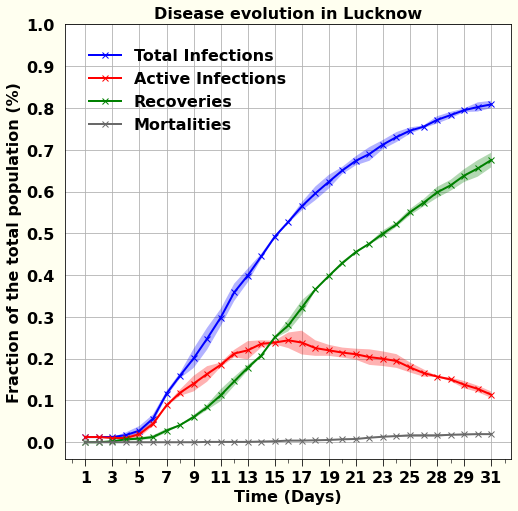

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

s = 96

t=96*31

x = (np.arange(0,t,step=s)/96)+1

cinf_mean = ((FinalTimeSeries[0]/Population)*100).cpu().detach().numpy()
cinf_std = ((FinalTimeSeries[8]/Population)*100).cpu().detach().numpy()

ainf_mean = ((FinalTimeSeries[2]/Population)*100).cpu().detach().numpy()
ainf_std = ((FinalTimeSeries[10]/Population)*100).cpu().detach().numpy()

recovered_mean = ((FinalTimeSeries[3]/Population)*100).cpu().detach().numpy()
recovered_std = ((FinalTimeSeries[11]/Population)*100).cpu().detach().numpy()

deceased_mean = ((FinalTimeSeries[4]/Population)*100).cpu().detach().numpy()
deceased_std = ((FinalTimeSeries[12]/Population)*100).cpu().detach().numpy() 
# cinf_mean = (m[0]/Population)*100
# cinf_std = (m[8]/Population)*100

# ainf_mean = (m[2]/Population)*100
# ainf_std = (m[10]/Population)*100

rinf_mean = recovered_mean
rinf_std = recovered_std

dinf_mean = deceased_mean
dinf_std = deceased_std
data = np.array([0.012,0.012,0.012,0.012,0.013,0.013,0.013,0.014,0.014,0.014,0.015,
                 0.015,0.017,0.018,0.019,0.019,0.021,0.022,0.023,0.023,0.024,0.025,
                 0.026,0.027,0.028,0.030,0.031,0.032,0.033,0.034,0.035])

plt.plot(x,cinf_mean[np.arange(0,t,step=s)],'x-',color='blue',linewidth=2,linestyle='-')
ax.fill_between(x, np.clip(cinf_mean[np.arange(0,t,step=s)]-cinf_std[np.arange(0,t,step=s)],0,np.inf), np.clip(cinf_mean[np.arange(0,t,step=s)]+cinf_std[np.arange(0,t,step=s)],0,np.inf) ,alpha=0.3, facecolor='blue')

plt.plot(x,ainf_mean[np.arange(0,t,step=s)],'x-',color='r',linewidth=2,linestyle='-')
ax.fill_between(x, np.clip(ainf_mean[np.arange(0,t,step=s)]-ainf_std[np.arange(0,t,step=s)],0,np.inf), np.clip(ainf_mean[np.arange(0,t,step=s)]+ainf_std[np.arange(0,t,step=s)],0,np.inf) ,alpha=0.3, facecolor='r')

plt.plot(x,rinf_mean[np.arange(0,t,step=s)],'x-',color='g',linewidth=2,linestyle='-')
ax.fill_between(x, np.clip(rinf_mean[np.arange(0,t,step=s)]-rinf_std[np.arange(0,t,step=s)],0,np.inf), np.clip(rinf_mean[np.arange(0,t,step=s)]+rinf_std[np.arange(0,t,step=s)],0,np.inf) ,alpha=0.3, facecolor='g')

plt.plot(x,dinf_mean[np.arange(0,t,step=s)],'x-',color='dimgray',linewidth=2,linestyle='-')
ax.fill_between(x, np.clip(dinf_mean[np.arange(0,t,step=s)]-dinf_std[np.arange(0,t,step=s)],0,np.inf), np.clip(dinf_mean[np.arange(0,t,step=s)]+dinf_std[np.arange(0,t,step=s)],0,np.inf) ,alpha=0.3, facecolor='dimgray')

#plt.plot(np.arange(1,32,step=1),data,'o-',color='black',linewidth=2)

plt.rcParams['figure.facecolor'] = 'ivory'

plt.rcParams["font.weight"] = "bold"

plt.rcParams["axes.labelweight"] = "bold"

ax.grid()

ax.set_axisbelow(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(16))
ax.tick_params(which='major', length=7, color='black')
ax.tick_params(which='minor', length=4, color='black' )
ax.xaxis.set_minor_locator(plt.MaxNLocator())

ax.tick_params(which='both', # Options for both major and minor ticks
               top=False, # turn off top ticks
               left=False, # turn off left ticks
               right=False,  # turn off right ticks
               bottom=True) # turn off bottom ticks
ax.set_xticks(np.arange(1,32,step=2))
ax.set_xticklabels(["1","3","5","7","9","11","13","15","17","19","21","23","25",
                    "28","29","31"])

plt.xticks(fontsize=16,fontweight='bold')
plt.yticks(np.arange(0,1.1,step=0.1),fontsize=16,fontweight='bold')

plt.xlabel('Time (Days)',fontsize=16,fontweight='bold')

plt.ylabel('Fraction of the total population (%)',fontsize=16,fontweight='bold')

plt.legend(['Total Infections','Active Infections','Recoveries','Mortalities'], #'Data'
           fontsize=16,loc="upper left",fancybox=True, 
           framealpha=0.0, shadow=False, borderpad=1)

plt.title('Disease evolution in Lucknow',fontsize=16,fontweight='bold')

plt.savefig('FL_3.pdf',format='pdf', bbox_inches='tight',Transparent=True)

files.download('FL_3.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

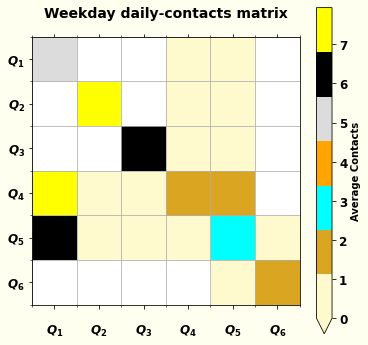

In [ ]:
fig,ax = plt.subplots(figsize=(6, 6))

data1 = InteractionsFinal[0].cpu().detach().numpy()

data1 = np.ma.masked_where(data1 == 0, data1)

data2 = InteractionsFinal[0].cpu().detach().numpy()

data1[0,0] = 5.2

data2[0,0] = 5.2

data1 = np.ma.masked_where(data1 == 0, data1)

alpha = ['$Q_{1}$','$Q_{2}$','$Q_{3}$','$Q_{4}$','$Q_{5}$','$Q_{6}$']

vmin = np.min(np.array([data1,data2]))

vmax = np.max(np.array([data1,data2]))

alpha = ['$Q_{1}$','$Q_{2}$','$Q_{3}$','$Q_{4}$','$Q_{5}$','$Q_{6}$']

cmap = ListedColormap(["lemonchiffon","goldenrod","cyan","orange","gainsboro", "black","yellow"])

cax = ax.matshow(data1,interpolation='nearest',cmap=cmap, rasterized=True, vmin=vmin, vmax=vmax)

cbar=fig.colorbar(cax,extend='min', label='Average Contacts')

plt.gca().set_xticks([x - 0.5 for x in plt.gca().get_xticks()][1:], minor='true')

plt.gca().set_yticks([y - 0.5 for y in plt.gca().get_yticks()][1:], minor='true')

plt.grid(which='minor')

cmap.set_bad(color='white')

ax.set_xticklabels(['']+alpha,y=-0.15,fontsize=12)

ax.set_yticklabels(['']+alpha,fontsize=12)

cbar.ax.tick_params(labelsize=12)

plt.title('Weekday daily-contacts matrix',fontweight='bold',fontsize=14)

plt.savefig('IFL_3.pdf',format='pdf', bbox_inches='tight',Transparent=True)

files.download('IFL_3.pdf')

In [ ]:
!pip install hickle
import hickle as hk
from google.colab import files
hk.dump(FinalTimeSeries.cpu().detach().numpy(),'TS_FL_3.hkl', mode='w')
hk.dump(FinalConstants.cpu().detach().numpy(),'C_FL_3.hkl', mode='w')
hk.dump(InteractionsFinal.cpu().detach().numpy(),'I_FL_3.hkl', mode='w')
files.download('TS_FL_3.hkl')
files.download('C_FL_3.hkl')
files.download('I_FL_3.hkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>